## Analysis based on tenancy, person, property, property class, property style 

#### Importing all necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from datetime import date
import holidays  
from matplotlib.ticker import FuncFormatter

### Fetching all the data needed for this objective

For Windows

In [2]:
job =  pd.read_excel(r'.\UPDATED DATA\04. Repairs\Job.xlsx')
pty_codes = pd.read_excel(r'.\UPDATED DATA\04. Repairs\Pty.xlsx')
sor = pd.read_excel(r'.\UPDATED DATA\04. Repairs\SORTrd.xlsx')
person = pd.read_excel(r'.\UPDATED DATA\02. Person\per.xlsx')
tenancy = pd.read_excel(r'.\UPDATED DATA\03. Tenancy\mis_tncy.xlsx')
properties = pd.read_excel(r'.\UPDATED DATA\01. Property\Pr.xlsx')
property_class = pd.read_excel(r'.\UPDATED DATA\01. Property\PrCls.xlsx')
property_style = pd.read_excel(r'.\UPDATED DATA\01. Property\APrStyle.xlsx')
property_street_add = pd.read_excel(r'.\UPDATED DATA\01. Property\Str.xlsx')
property_size = pd.read_excel(r'.\UPDATED DATA\01. Property\PrTypeSize.xlsx')

For Mac

In [ ]:
# job = pd.read_excel(r'./UPDATED DATA/04. Repairs/Job.xlsx')
# pty_codes = pd.read_excel(r'./UPDATED DATA/04. Repairs/Pty.xlsx')
# sor = pd.read_excel(r'./UPDATED DATA/04. Repairs/SORTrd.xlsx')
# person = pd.read_excel(r'./UPDATED DATA/02. Person/per.xlsx')
# tenancy = pd.read_excel(r'./UPDATED DATA/03. Tenancy/mis_tncy.xlsx')
# properties = pd.read_excel(r'./UPDATED DATA/01. Property/Pr.xlsx')
# property_class = pd.read_excel(r'./UPDATED DATA/01. Property/PrCls.xlsx')
# property_style = pd.read_excel(r'./UPDATED DATA/01. Property/APrStyle.xlsx')
# property_street_add = pd.read_excel(r'./UPDATED DATA/01. Property/Str.xlsx')
# property_size = pd.read_excel(r'./UPDATED DATA/01. Property/PrTypeSize.xlsx')

### Assembling data for analysis

In [3]:
# getting all UK holidays from holidays library
uk_holidays = holidays.UnitedKingdom()

# getting priority codes and merging with repair data
pty_type = pty_codes[['pty_cde','pty_type']]
job['job_report_date'] = pd.to_datetime(job['reported-dat']).dt.date
job = job.merge(pty_type, how='left', left_on='pty-cde', right_on='pty_cde')

# dropping PTY_TYPE as it is not needed now
job = job.drop('pty_type', axis = 1)

# Mapping priority code of each report with priority classifcation of repair (routine, cyclic, emergency, void)
pty_map = dict(pty_codes[['pty_cde','pty_classification']].values)
job['priority'] = job['pty-cde'].map(pty_map)

# dropping PTY_CDE as there is no need for it now
job.drop('pty_cde', axis = 1, inplace = True)

# Replacing OLD SOR trade codes with NEW ones
job['sortrd-cde-1'].replace(['BR', 'C', 'E', 'E1', 'F', 'G','GF', 'H', 'MI', 'P', 'PD', 'PO','R', 'SC', 'TI', 'W'], 
                             ['0B','0C','0E', '0E', '0F','0Z','0G','HP','NS','0P', '0D','0D','0R', '0S', '0I','0C'], 
                             inplace=True)


##### mapping sor codes to text decriptions for codes

In [4]:
sor.set_index('cde', inplace = True)
sor_map = sor.to_dict()['dsc']
job['sor'] = job['sortrd-cde-1'].map(sor_map)


#### creating new dataframe with relevant features only (predictors)

In [5]:
job1 = job[['job_report_date', 'pr-seq-no', 'void-num', 'priority', 'right-to-repair', 'sor']].copy()

job1['Year'] = pd.to_datetime(job1['job_report_date']).dt.year
job1['Week'] = pd.to_datetime(job1['job_report_date']).dt.isocalendar().week
job1['Day'] = pd.to_datetime(job1['job_report_date']).dt.day
job1['Month'] = pd.to_datetime(job1['job_report_date']).dt.month
job1['WeekDay'] = pd.to_datetime(job1['job_report_date']).dt.dayofweek
job1['Holiday'] = job1['job_report_date'].isin(uk_holidays)
job1['BeginMonth'] = job1.Day.isin([1,2,3]).astype(int)
job1['Weekend'] = job1.WeekDay.isin([5,6]).astype(int)

job1.head()

job_report_date  pr-seq-no  void-num          priority  right-to-repair  \
0      1996-02-27      10257         0        Void Works                0   
1      2002-02-28      10333         0  Emergency Repair                0   
2      2004-11-16      15730         0        Void Works                0   
3      1996-02-27      15584         0             Other                0   
4      1996-02-27      16862         0    Routine Repair                0   

             sor  Year  Week  Day  Month  WeekDay  Holiday  BeginMonth  \
0        GLAZING  1996     9   27      2        1    False           0   
1    GAS FITTER.  2002     9   28      2        3    False           0   
2  NOT SPECIFIED  2004    47   16     11        1    False           0   
3      CARPENTRY  1996     9   27      2        1    False           0   
4      CARPENTRY  1996     9   27      2        1    False           0   

   Weekend  
0        0  
1        0  
2        0  
3        0  
4        0

#### Getting repair count per date

In [6]:
jobs_per_date = pd.DataFrame(job1.groupby('job_report_date').size())
jobs_per_date = jobs_per_date.reset_index()
jobs_per_date.columns = ['date', 'repair_count']
jobs_per_date.describe()

repair_count
count   8758.000000
mean      94.664193
std       80.645467
min        1.000000
25%       55.000000
50%       90.000000
75%      124.000000
max     1826.000000

#### There are an average of ~95 repairs per day

In [7]:
job_prop = job.merge(properties, how='inner', left_on='pr-seq-no', right_on='seq-no')
repairs_per_property = pd.DataFrame(job_prop.groupby('pr-seq-no').size())
repairs_per_property = repairs_per_property.reset_index()
repairs_per_property.columns = ['pr-seq-no', 'total_repair_count']
repairs_per_property['total_repair_count'].describe()

count    7987.000000
mean      103.801052
std       116.037417
min         1.000000
25%        15.000000
50%        99.000000
75%       158.000000
max      3081.000000
Name: total_repair_count, dtype: float64

#### There are an average of ~103 repairs per property

#### Merging property data with repairs data

In [8]:
property_size = property_size.drop(['Unnamed: 2','dsc'], axis = 1)
property_size.set_index('cde', inplace = True)
property_size_map = property_size.to_dict()['Unnamed: 3']
properties['property_size'] = properties['prtyp-cde'].map(property_size_map)


property_class.set_index('prcls_cde', inplace = True)
property_class_map = property_class.to_dict()['prcls_dsc']
properties['property_class'] = properties['prcls-cde'].map(property_class_map)

property_style.set_index('aprstyle-cde', inplace = True)
property_style_map = property_style.to_dict()['dsc']
properties['property_style'] = properties['aprstyle-cde'].map(property_style_map)

property_street_add.set_index('cde', inplace = True)
property_street_map = property_street_add.to_dict()['loc-cde']
properties['location_code'] = properties['str-cde'].map(property_street_map)

display(properties.head())

# replacing rest of the 'zero' construction years as they are unknown to the most frequently occuring. 
# replacing zero with most frequently occuring construction year for BLOCK type properties
na_const_1953_idx = properties[(properties['construction-yr']==0)&(properties['aprstyle-cde']=='BLOCK')].index
properties.loc[na_const_1953_idx,'construction-yr'] = 1953


prcls-cde  seq-no  co-own postcode rtb-dat demolish-dat  str-cde prtyp-cde  \
0         H   10000       1  GL2 4YR     NaT   1995-03-27        2    1BB 00   
1         S   17468       1      NaN     NaT          NaT        2       ZZS   
2         H   10001       1  GL3 1LR     NaT   1995-04-03        5    2BSD00   
3         S   17474       1      NaN     NaT          NaT        5       ZZS   
4         H   10002       1  GL3 2RU     NaT   1995-06-25        6    3BSD00   

   construction-yr                                      addr  ownership-%  \
0           1900.0    31 Darrell Close;Quedgeley;Gloucester;        100.0   
1              NaN       Darrell Close;Quedgeley;Gloucester;        100.0   
2           1900.0  70 Devereux Court;Churchdown;Gloucester;        100.0   
3              NaN     Devereux Court;Churchdown;Gloucester;        100.0   
4           1900.0     25 Pirton Lane;Churchdown;Gloucester;        100.0   

  disposal-dte aprstyle-cde property_size property_class property_style  \
0          NaT          NaN         1 Bed          House            NaN   
1          NaT          NaN         Other         Street            NaN   
2          NaT          NaN         2 Bed          House            NaN   
3          NaT          NaN         Other         Street            NaN   
4          NaT          NaN         3 Bed          House            NaN   

  location_code  
0           QUE  
1           QUE  
2           CHU  
3           CHU  
4           CHU

In [9]:
print('============== \n PERSON \n==============')
display(person.head())
print('============== \n TENANCY \n==============')
display(tenancy.head())
print('============== \n PROPERTIES \n==============')
display(properties.head())
print('============== \n PROPERTY CLASS  \n==============')
display(property_class.head())
print('============== \n PROPERTY STYLE  \n==============')
display(property_style.head())
print('============== \n PROPERTY STREET ADDD \n==============')
display(property_street_add.head())

 PERSON 


dob             fnam      snam ttl     num  sex death-dat  \
0  1968-12-19 00:00:00             Mark  Brickley  Mr  254561  1.0       NaT   
1  1982-12-13 00:00:00          Michael  Brickley  Mr  309664  1.0       NaT   
2  1998-10-25 00:00:00          Michael  Brickley  Mr  298658  1.0       NaT   
3  1982-02-13 00:00:00  Michael Stephen  Brickley  Mr  290692  1.0       NaT   
4  1988-01-19 00:00:00            Nicky  Brickley  Mr  298221  1.0       NaT   

  eth-cde lang-cde apermarsts-cde nat-cde religion-cde sex-orientation-cde  
0     NaN       EN              N     NaN          NaN                 NaN  
1      EW       EN              S     NaN          NaN                 NaN  
2     NaN       EN              N     NaN          NaN                 NaN  
3     NaN       EN              N     NaN          NaN                 NaN  
4     NaN       EN              N     NaN          NaN                 NaN

 TENANCY 


occ_num  per_num  pr_seq_no tenu_cde   comm_dat  tncy_reason_cde  \
0    10000   100001      16328       CT 1981-10-05              NaN   
1    10004   100041      14809       CT 1980-07-28              NaN   
2    10007   100071      10057       PP 1985-12-23              NaN   
3    10008   100081      10051       CT 1983-04-18              NaN   
4    10009   100091      10030       ET 1976-04-05              NaN   

    term_dat rntpaymd_cde main_arrrecgrp_cde ttncytyp_cde adisabil_cde  
0 1997-04-13         CASH                FCT           TF          NaN  
1 1998-04-05         CASH                FCT           TF          NaN  
2 1998-01-18         CASH               FPST           TF          NaN  
3 1995-02-12         CASH                FCT           TF          NaN  
4        NaT          FHB                RG1           TC          NaN

 PROPERTIES 


prcls-cde  seq-no  co-own postcode rtb-dat demolish-dat  str-cde prtyp-cde  \
0         H   10000       1  GL2 4YR     NaT   1995-03-27        2    1BB 00   
1         S   17468       1      NaN     NaT          NaT        2       ZZS   
2         H   10001       1  GL3 1LR     NaT   1995-04-03        5    2BSD00   
3         S   17474       1      NaN     NaT          NaT        5       ZZS   
4         H   10002       1  GL3 2RU     NaT   1995-06-25        6    3BSD00   

   construction-yr                                      addr  ownership-%  \
0           1900.0    31 Darrell Close;Quedgeley;Gloucester;        100.0   
1              NaN       Darrell Close;Quedgeley;Gloucester;        100.0   
2           1900.0  70 Devereux Court;Churchdown;Gloucester;        100.0   
3              NaN     Devereux Court;Churchdown;Gloucester;        100.0   
4           1900.0     25 Pirton Lane;Churchdown;Gloucester;        100.0   

  disposal-dte aprstyle-cde property_size property_class property_style  \
0          NaT          NaN         1 Bed          House            NaN   
1          NaT          NaN         Other         Street            NaN   
2          NaT          NaN         2 Bed          House            NaN   
3          NaT          NaN         Other         Street            NaN   
4          NaT          NaN         3 Bed          House            NaN   

  location_code  
0           QUE  
1           QUE  
2           CHU  
3           CHU  
4           CHU

 PROPERTY CLASS  


prcls_dsc
prcls_cde              
A          Communal Are
B                 Block
C            Commercial
F                  Flat
G                Garage

 PROPERTY STYLE  


dsc
aprstyle-cde                           
6574HO                 1965-1974 houses
BISF          British Iron & Steel Fed.
BLOCK                             Block
BUNGLO                        Bungalows
HRFLAT                  High rise flats

 PROPERTY STREET ADDD 


loc-cde               nam   loc-nam-1   loc-nam-2
cde                                                    
33100     GLO  ABBEYDALE ESTATE  Gloucester         NaN
36        KIN     Albion Street   Kingsholm  Gloucester
7000      LNG     Alder's Green    Longford  Gloucester
48        GLO     Alfred Street  Gloucester         NaN
50        GLO    Alington Close  Gloucester         NaN

#### Analysis of demolish date
828 properties = 1, demolished, remaining 7408 still erect
1 = demolished, otherwise 0
if there is demolish-dat entry then you set demolished to non-zero

In [10]:
#print(properties.isna().sum())
properties['demolish-dat'].isna().sum()
properties['demolished'] = (properties['demolish-dat'].notna() & properties['demolish-dat'].apply(lambda x: isinstance(x, pd.Timestamp) and not pd.isna(x))).astype(int)
properties['demolished'].value_counts()
# properties.isna().sum()


0    7754
1     826
Name: demolished, dtype: int64

#### Analysis of right to buy
Right to Buy Date = non zero means that property no longer owned or managed by GCH
rtb = 1 (no longer owned)
rtb = 0 (still owned by GCH)
properties['rtb'] = (properties['rtb-dat'].notna() & properties['rtb-dat'].apply(lambda x: isinstance(x, pd.Timestamp) and not pd.isna(x))).astype(int)
if there is demolish-dat entry then you set demolished to non-zero

##### Disposal Date = non zero   means that property no longer owned or managed by GCH
##### disposed = 1 (no longer owned)
##### disposed = 0 (still owned by GCH)

In [11]:
properties['rtb'] = (properties['rtb-dat'].notna() & properties['rtb-dat'].apply(lambda x: isinstance(x, pd.Timestamp))).astype(int)
properties['disposed'] = (properties['disposal-dte'].notna() & properties['disposal-dte'].apply(lambda x: isinstance(x, pd.Timestamp))).astype(int)

print(properties['rtb'].value_counts())
rtb = properties['rtb'].value_counts()[1]
print(f'\033[1mBought properties: {rtb}\033[0m')
print(properties['disposed'].value_counts())
disposed = properties['disposed'].value_counts()[1]
print(f'\033[1mDisposed properties: {disposed}\033[0m')

# selecting final columns from properties - keeping construction year (to calculate property age later based on job REPORT DATE)
prop_final = properties[['seq-no', 'co-own', 'postcode','property_size', 'property_class', 'property_style',
       'location_code','demolished', 'rtb', 'disposed', 'construction-yr','demolish-dat','rtb-dat','disposal-dte']]

0    7230
1    1350
Name: rtb, dtype: int64
Bought properties: 1350
0    8473
1     107
Name: disposed, dtype: int64
Disposed properties: 107


In [12]:
#fill in missing values for location codes based on analysing street code and textual 'address', assigning relevant location_code meticulously
prop_final['location_code'].isna().sum()

# identifying locations of missing location codes and filling them
prop_final.loc[[8552, 8553, 8564, 8565, 8566, 8567, 8568, 8569, 8570],'location_code'] = 'BKW'

prop_final.loc[[8554, 8555, 8556, 8557, 8558, 8559, 8579],'location_code'] = 'STR'

prop_final.isna().sum()


seq-no                0
co-own                0
postcode            588
property_size      3629
property_class        0
property_style     3158
location_code         0
demolished            0
rtb                   0
disposed              0
construction-yr     399
demolish-dat       7754
rtb-dat            7230
disposal-dte       8473
dtype: int64

# Tenancy 

There are 15796 formerly void and 610 currently void tenancies in record. 
i.e. 16406 tenancies with 'per_num' = 1. That is no person associated with a particular tenancy.

25039 rows(tenancies) with per_num !=0 (tenancies distributed among 18082 unique persons) 

41445 unique tenancies in record

16406 tenancies with 'per_num' = 1. Adding 'void' column to identify 'void' 'tenancies' - periods of time when property was void

Instead of discard all per_num = 1, ie. void tenancies, another column = void was added to identify void tenancies 
This may be a good predictor for void works

In [13]:
print(len(tenancy))
ten_void_idx = list(tenancy[tenancy['per_num']==1].index)
print(len(ten_void_idx))
tenancy['void'] = 0
# setting the value to 1 for indexes in 'ten_void_idx' (to denote void tenancy)
tenancy.loc[ten_void_idx, 'void'] = 1
print(tenancy['void'])

41445
16406
0        0
1        0
2        0
3        0
4        0
        ..
41440    0
41441    1
41442    1
41443    1
41444    1
Name: void, Length: 41445, dtype: int64


### Merge Tenancy and Person dataframes. 
For every tenancy, find the person who rented this and merge it with tenancy

This adds all info about the person who rented the property at that time to the tenancy row

In [14]:
tenancy_person = tenancy.merge(person, how='left', left_on='per_num', right_on='num')
# A lot of properties have been let many times to various tenants
print(tenancy_person)
tenancy_person['pr_seq_no'].value_counts()

       occ_num  per_num  pr_seq_no tenu_cde   comm_dat  tncy_reason_cde  \
0        10000   100001      16328       CT 1981-10-05              NaN   
1        10004   100041      14809       CT 1980-07-28              NaN   
2        10007   100071      10057       PP 1985-12-23              NaN   
3        10008   100081      10051       CT 1983-04-18              NaN   
4        10009   100091      10030       ET 1976-04-05              NaN   
...        ...      ...        ...      ...        ...              ...   
41440    67177   340587      15507       SS 2023-06-20              0.0   
41441    67178        1      18423       ST 2023-06-26              NaN   
41442    67179        1      10908       CT 2023-06-19              NaN   
41443    67180        1      12082       CT 2023-06-19              NaN   
41444    67181        1      18465       TM 2023-06-22              NaN   

        term_dat rntpaymd_cde main_arrrecgrp_cde ttncytyp_cde  ... ttl  \
0     1997-04-13         

17325    129
17330    120
17331    118
17321    114
17332    112
        ... 
15534      1
12362      1
14487      1
10301      1
18593      1
Name: pr_seq_no, Length: 7657, dtype: int64

#### Comments about using person data

creating column for Dead/Alive  based on 'death-dat' - if death-dat has a value (not NaN), it means person is dead, replacing value with 1, if NaN, means pereson is alive, assign 0
Dead
non Nan = 1
NaN = 0

Not using nationality AND religion AND Sexual orientation because of 30,000+ missing values for EACH
Not using 'disabil-cde' because 40,000+ values missing
Not using 'eth-cde' because 20,000+ values missing, and impossible to use imputation to guess ethnicity reliably
only few values missing for language and marital status, replace unknown by 'not stated' codes for each

In [15]:
tenancy_person['dead'] = np.where(tenancy_person['death-dat'].notna(), 1, 0)

In [16]:
tenancy_person['lang-cde'] = tenancy_person['lang-cde'].fillna('NS')
tenancy_person['apermarsts-cde'] = tenancy_person['apermarsts-cde'].fillna('N')

# there is only one instance (one person/tenant) whose 'sex' is not given. Replace value with most frequently occuring sex (mode)

tenancy_person['sex'] = tenancy_person['sex'].fillna(tenancy_person['sex'].mode().iloc[0])



#final tenancy_person frame. Keeping dob to calculate tenant_age (at the time of report) later using year of report

tenancy_person_final = tenancy_person[['per_num','pr_seq_no', 'tenu_cde', 'comm_dat','term_dat','void', 'sex','lang-cde',
       'apermarsts-cde','dead','dob', 'eth-cde', 'occ_num']]

## Merge Tenancy and Person and Property dataframes. 

In [17]:
tenancy_person_prop = tenancy_person_final.merge(prop_final, how='left', right_on='seq-no', left_on='pr_seq_no')
tenancy_person_prop

per_num  pr_seq_no tenu_cde   comm_dat   term_dat  void  sex lang-cde  \
0       100001      16328       CT 1981-10-05 1997-04-13     0  1.0       EN   
1       100041      14809       CT 1980-07-28 1998-04-05     0  1.0       EN   
2       100071      10057       PP 1985-12-23 1998-01-18     0  1.0       EN   
3       100081      10051       CT 1983-04-18 1995-02-12     0  1.0       EN   
4       100091      10030       ET 1976-04-05        NaT     0  1.0       EN   
...        ...        ...      ...        ...        ...   ...  ...      ...   
41440   340587      15507       SS 2023-06-20        NaT     0  0.0       EN   
41441        1      18423       ST 2023-06-26        NaT     1  1.0       EN   
41442        1      10908       CT 2023-06-19        NaT     1  1.0       EN   
41443        1      12082       CT 2023-06-19        NaT     1  1.0       EN   
41444        1      18465       TM 2023-06-22        NaT     1  1.0       EN   

      apermarsts-cde  dead  ... property_class            property_style  \
0                  L     0  ...           Flat  Low rise post 1945 flats   
1                  N     0  ...           Flat  Low rise post 1945 flats   
2                  N     0  ...         Garage                       NaN   
3                  N     0  ...         Garage                       NaN   
4                  M     0  ...          House                    Houses   
...              ...   ...  ...            ...                       ...   
41440              S     0  ...           Flat         Medium rise flats   
41441              N     0  ...           Flat      GCH New Builds 2016-   
41442              N     0  ...          House                 Bungalows   
41443              N     0  ...           Flat  Low rise post 1945 flats   
41444              N     0  ...           Flat      GCH New Builds 2016-   

       location_code  demolished  rtb disposed construction-yr demolish-dat  \
0                MAT           0    0        0          1953.0          NaT   
1                WES           0    0        0          1975.0          NaT   
2                HOL           0    0        0          1900.0          NaT   
3                HOL           0    0        0          1900.0          NaT   
4                HOL           0    0        0          1966.0          NaT   
...              ...         ...  ...      ...             ...          ...   
41440            WES           0    0        0          1977.0          NaT   
41441            GLO           0    0        0          2021.0          NaT   
41442            TUF           0    0        0          1971.0          NaT   
41443            TUF           0    0        0          1955.0          NaT   
41444            QUE           0    0        0          1990.0          NaT   

      rtb-dat disposal-dte  
0         NaT          NaT  
1         NaT          NaT  
2         NaT          NaT  
3         NaT          NaT  
4         NaT          NaT  
...       ...          ...  
41440     NaT          NaT  
41441     NaT          NaT  
41442     NaT          NaT  
41443     NaT          NaT  
41444     NaT          NaT  

[41445 rows x 27 columns]

for every tenancy (40,000+), merging each with its corresponding property information 8500+ unique properties. Each tenancy matched with its corresponding property, so property details will repeat for various tenancies
Certain properties do not have corresponding tenants and vice-versa
There are EIGHT (8) tenancies with pr_seq_nos that are not present in the 'final_property' dataframe. Drop these rows


In [18]:
len(properties['seq-no'].unique())

8580

In [19]:
no_prop_info_idx = tenancy_person_prop[tenancy_person_prop['seq-no'].isna()].index
tenancy_person_prop = tenancy_person_prop.drop(no_prop_info_idx, axis = 0)

tenancy_person_prop.isna().sum()

# out of 8580 GCH properties, 7654 were matched with corresponding tenant information  

len(tenancy_person_prop['pr_seq_no'].unique())

7657

## Comments about merging jobs with tenancy property and person


Every non-void tenancy was merged with the corresponding tenant information according to the person number in dataframe ‘person’ shared by GCH. Each tenancy was then merged with its associated property information. There were many tenancies with the same property sequence number as there were only 8580 unique properties in the property data shared by GCH. To ensure that the correct tenant was identified with the corresponding repair report, we first attached all possible tenants to potential repairs based on their respective property sequence numbers. First each job was attached to various tenants based on property number, then from all the potential tenants, only one was selected. Based on the principle that only a single tenancy is active for a particular property at a single time, the tenancy for which the repair report date lay between the tenancy duration (based on its commencement and termination dates) was selected. This resulted in the final dataframe which contained repair data as well as its corresponding property, tenancy, and tenant information. We then calculated tenant ages and tenancy lengths, and analysed the data with respect to repair demand. 
Now each tenancy and its associated person (tenant) is connected to the corresponding property 


In [20]:
job_tenancy_person_prop = job1.merge(tenancy_person_prop, how='left', left_on='pr-seq-no', right_on='pr_seq_no')

filtered_job_tenancy_person_prop = job_tenancy_person_prop[(job_tenancy_person_prop['job_report_date'] >= job_tenancy_person_prop['comm_dat']) & (job_tenancy_person_prop['job_report_date'] <= job_tenancy_person_prop['term_dat'])]

#### Calculating TENANT AGE and PROPERTY AGE 
Tenant Age at the time of report = Date (Year) of repair report - DOB (Year of Birth) of tenant

Property Age at the time of report = Date (Year) of repair report - Construction Year


In [21]:
# creating copy
filtered_job_tenancy_person_prop = filtered_job_tenancy_person_prop.copy()
# converting 'dob', 'job_report_date', and 'construction-yr' columns to datetime
filtered_job_tenancy_person_prop['dob'] = pd.to_datetime(filtered_job_tenancy_person_prop['dob'])
filtered_job_tenancy_person_prop['job_report_date'] = pd.to_datetime(filtered_job_tenancy_person_prop['job_report_date'])
filtered_job_tenancy_person_prop['construction-yr'] = pd.to_datetime(filtered_job_tenancy_person_prop['construction-yr'])

# TENANT AGE:

# calculating 'tenant_age' based on 'dob' and 'job_report_date'
filtered_job_tenancy_person_prop.loc[:, 'tenant_age'] = (filtered_job_tenancy_person_prop['job_report_date'].dt.year - filtered_job_tenancy_person_prop['dob'].dt.year)

# adjusting 'tenant_age' between 18 and 95
filtered_job_tenancy_person_prop['tenant_age'] = filtered_job_tenancy_person_prop['tenant_age'].clip(lower=18, upper=95)

# calculating median age
median_age = filtered_job_tenancy_person_prop['tenant_age'].median()

# filling missing values with median age
filtered_job_tenancy_person_prop['tenant_age'].fillna(median_age, inplace=True)

# PROPERTY AGE:

# calculating 'property_age' based on 'construction-yr' and 'job_report_date'
filtered_job_tenancy_person_prop.loc[:, 'property_age'] = (filtered_job_tenancy_person_prop['job_report_date'].dt.year - filtered_job_tenancy_person_prop['construction-yr'].dt.year)

# calculating 'length of tenancy' based on 'job_report_date' and 'comm_dat'
filtered_job_tenancy_person_prop.loc[:, 'length_of_tenancy'] = (filtered_job_tenancy_person_prop['job_report_date'].dt.year - filtered_job_tenancy_person_prop['comm_dat'].dt.year)

# wherever comm_date was defaulted to 1900, the tenancy_length is unnaturally long. 
# replacing tenancy_length with average value = 8, wherever comm_dat is 1900-01-02 (default date)
# average length of tenancy = 8
filtered_job_tenancy_person_prop.loc[filtered_job_tenancy_person_prop['comm_dat'] == '1900-01-02', 'length_of_tenancy'] = 8

# final DataFrame
filtered_job_tenancy_person_prop.isna().sum()


job_report_date           0
pr-seq-no                 0
void-num                  0
priority               1051
right-to-repair           0
sor                    3066
Year                      0
Week                      0
Day                       0
Month                     0
WeekDay                   0
Holiday                   0
BeginMonth                0
Weekend                   0
per_num                   0
pr_seq_no                 0
tenu_cde                  0
comm_dat                  0
term_dat                  0
void                      0
sex                       0
lang-cde                  0
apermarsts-cde            0
dead                      0
dob                    1090
eth-cde               89915
occ_num                   0
seq-no                    0
co-own                    0
postcode                736
property_size        306066
property_class            0
property_style        39424
location_code             0
demolished                0
rtb                 

# ANALYSIS STARTS HERE

### Count of each repair type

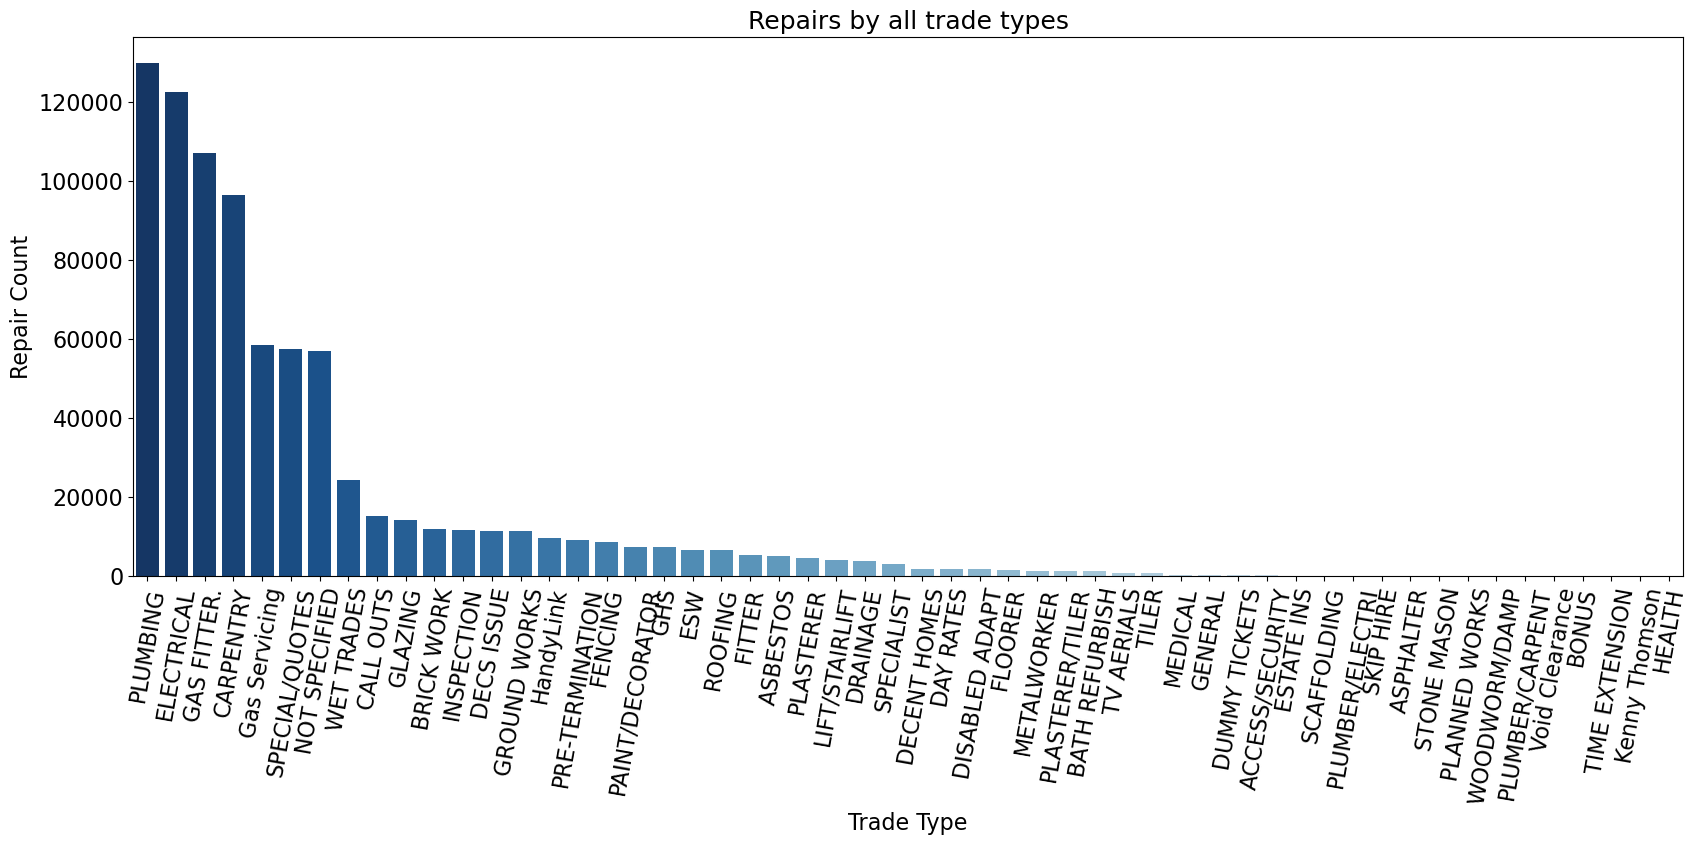

In [22]:
plt.figure(figsize = (20,7))
ax = sns.countplot(x = job1['sor'], order = job1['sor'].value_counts().index, palette = 'Blues_r')
plt.title('Repairs by all trade types', fontsize = 18)
ax.tick_params(axis='x', labelsize=16)  
ax.tick_params(axis='y', labelsize=16) 
ax.set_xlabel('Trade Type', fontsize=16)
ax.set_ylabel('Repair Count', fontsize=16)
plt.xticks(rotation = 80)
plt.grid(False)
plt.show()

### Count for each priority type

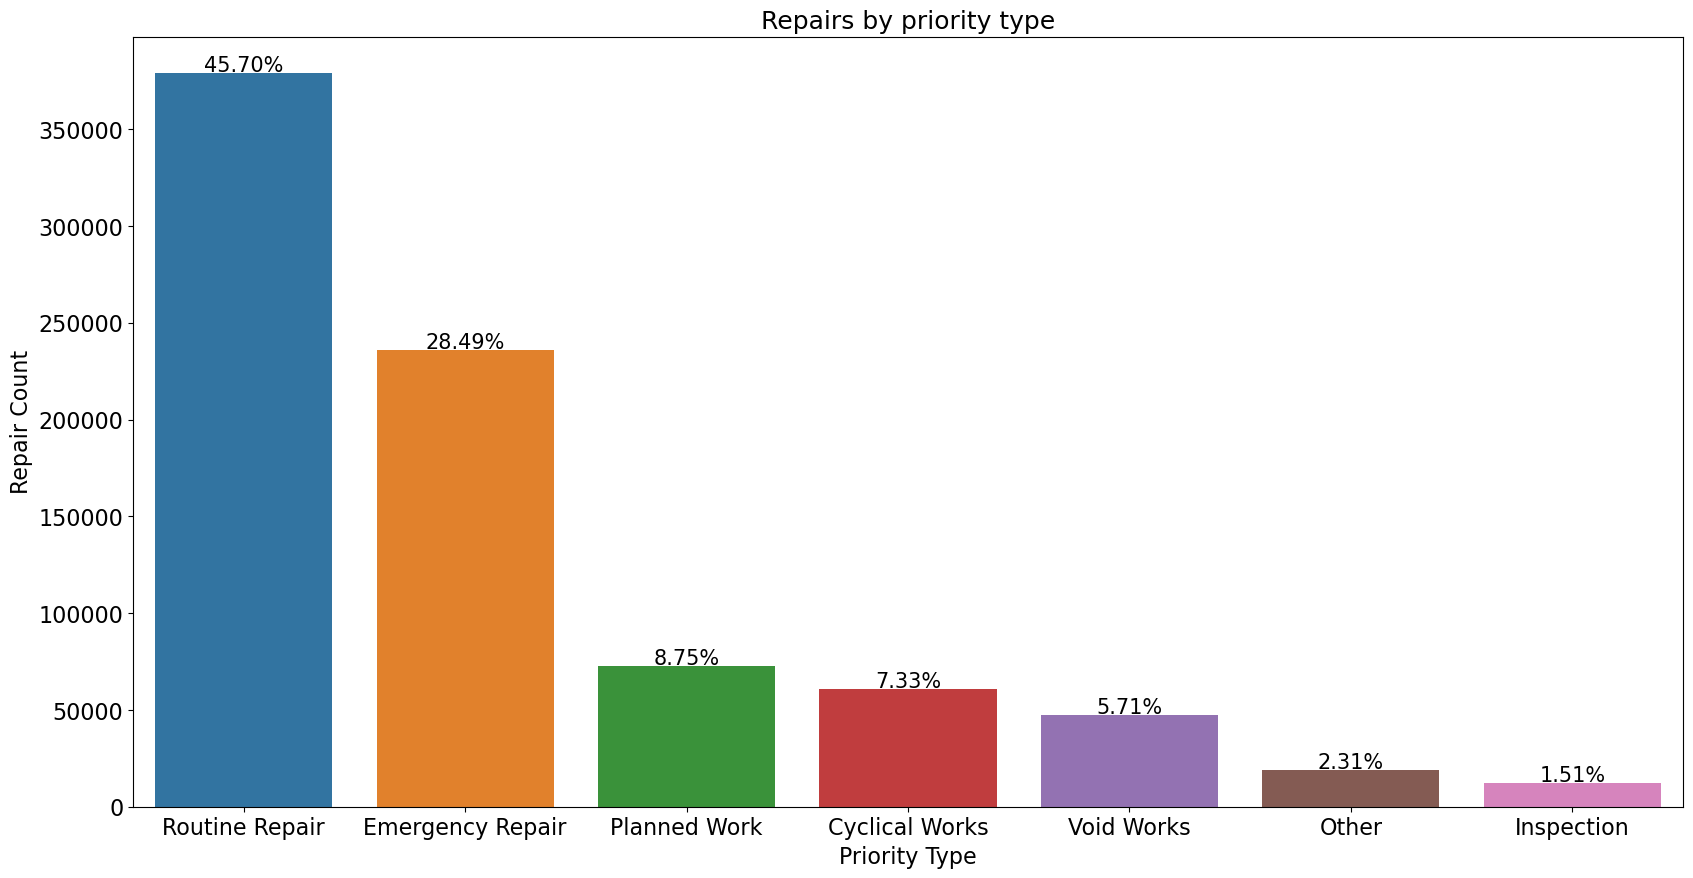

In [23]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='priority', data=job1,order = job1['priority'].value_counts().index )

total_count = len(job1)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 800, f'{(height / total_count) * 100:.02f}%', ha='center', fontsize=15)

plt.title('Repairs by priority type', fontsize = 18)
ax.tick_params(axis='x', labelsize=16)  
ax.tick_params(axis='y', labelsize=16) 
ax.set_xlabel('Priority Type', fontsize=16)
ax.set_ylabel('Repair Count', fontsize=16)
plt.grid(False)

plt.show()

### Repair count for Tenant Age
for repair for which tenancy data is available

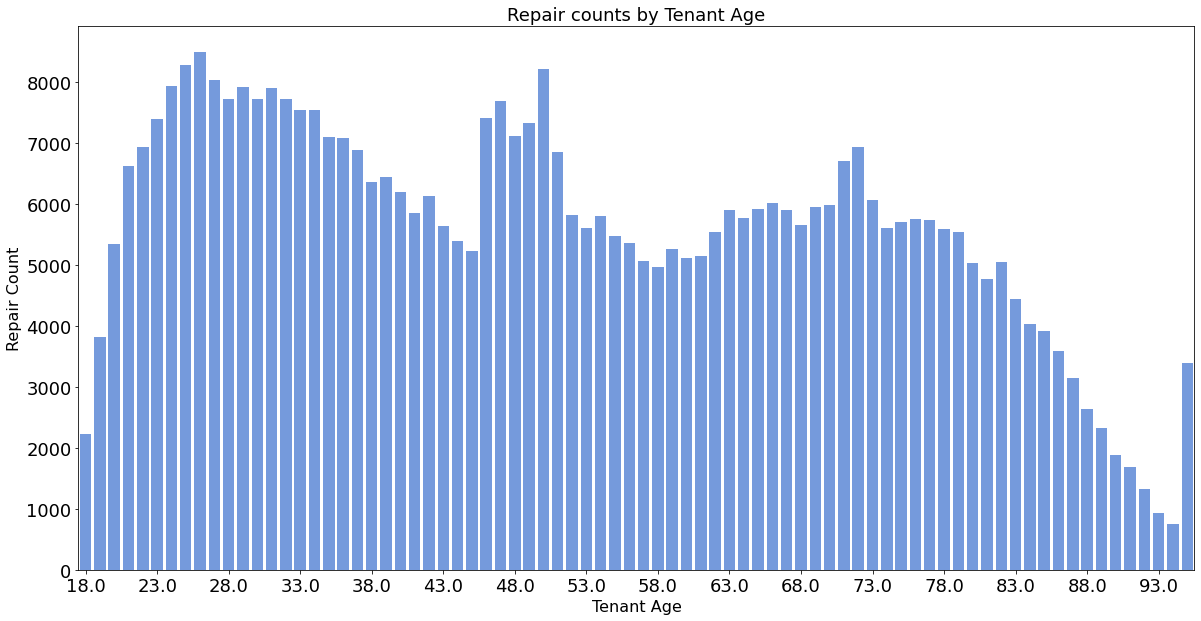

In [31]:
plt.figure(figsize = (20,10))

ax = sns.countplot(x='tenant_age', data=filtered_job_tenancy_person_prop, color = 'cornflowerblue' )

# Adjust x-axis tick frequency
tick_freq = 5  
ax.set_xticks(ax.get_xticks()[::tick_freq])
plt.title('Repair counts by Tenant Age', fontsize = 18)
ax.tick_params(axis='x', labelsize=18)  
ax.tick_params(axis='y', labelsize=18) 
ax.set_xlabel('Tenant Age', fontsize=16)
ax.set_ylabel('Repair Count', fontsize=16)
plt.show()

#### Distrbution of Tenants by Age

There are a larger number of younger tenants, and lower tenant age is correlated with higher repair demand. 

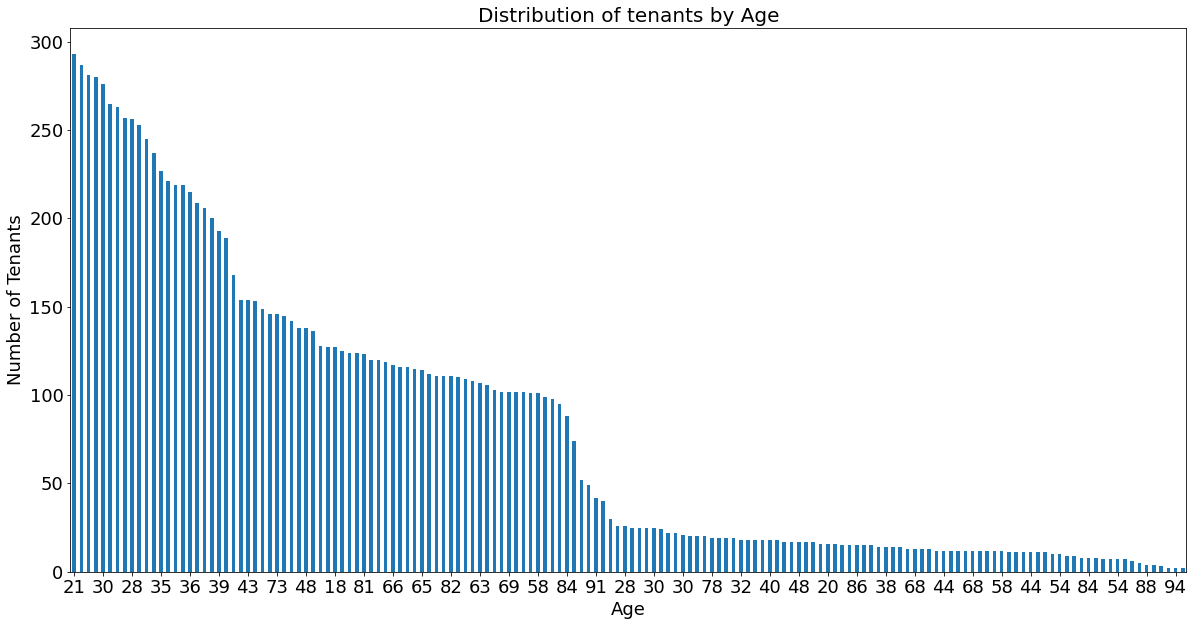

In [32]:
tenant_ages = pd.DataFrame(filtered_job_tenancy_person_prop.groupby('per_num')['tenant_age'].median())
tenant_ages = tenant_ages.iloc[1:, :]
age_count = pd.DataFrame(tenant_ages.value_counts())
age_count = age_count.reset_index()
age_count.columns = ['age','count']
age_count['age'] = age_count['age'].round(0)
age_count = age_count[1:]
age_count['age'] = age_count['age'].astype('int')


ax = age_count.plot(kind='bar', x= 'age',y = 'count', figsize = (20,10))
tick_freq = 4
ax.set_xticks(ax.get_xticks()[::tick_freq])
plt.title('Distribution of tenants by Age', fontsize=20)
ax.tick_params(axis='x', labelsize=18)  
ax.tick_params(axis='y', labelsize=18) 
labels = ax.set_xlabel('Age', fontsize=18)
ax.set_ylabel('Number of Tenants', fontsize=18)


plt.xticks(rotation = 0)
ax. get_legend(). set_visible(False)
plt.show()

### Repair Count for each weekday

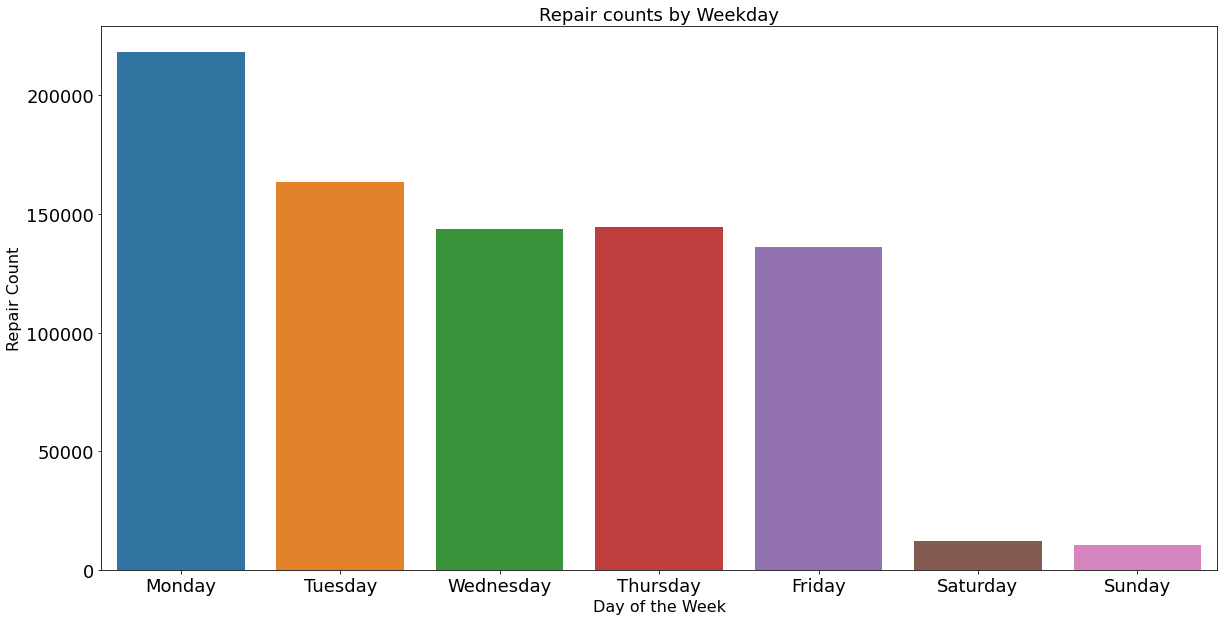

In [33]:
week_map_dict = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}


plt.figure(figsize=(20, 10))
ax = sns.countplot(x='WeekDay', data=job1)

# x-axis labels using weekday mapping dictionary
ax.set_xticklabels([week_map_dict[x] for x in range(7)])

plt.title('Repair counts by Weekday', fontsize=18)
ax.tick_params(axis='x', labelsize=18)  
ax.tick_params(axis='y', labelsize=18) 
ax.set_xlabel('Day of the Week', fontsize=16)
ax.set_ylabel('Repair Count', fontsize=16)
plt.show()

###### Repair counts by Weekday and Repair Priority Type

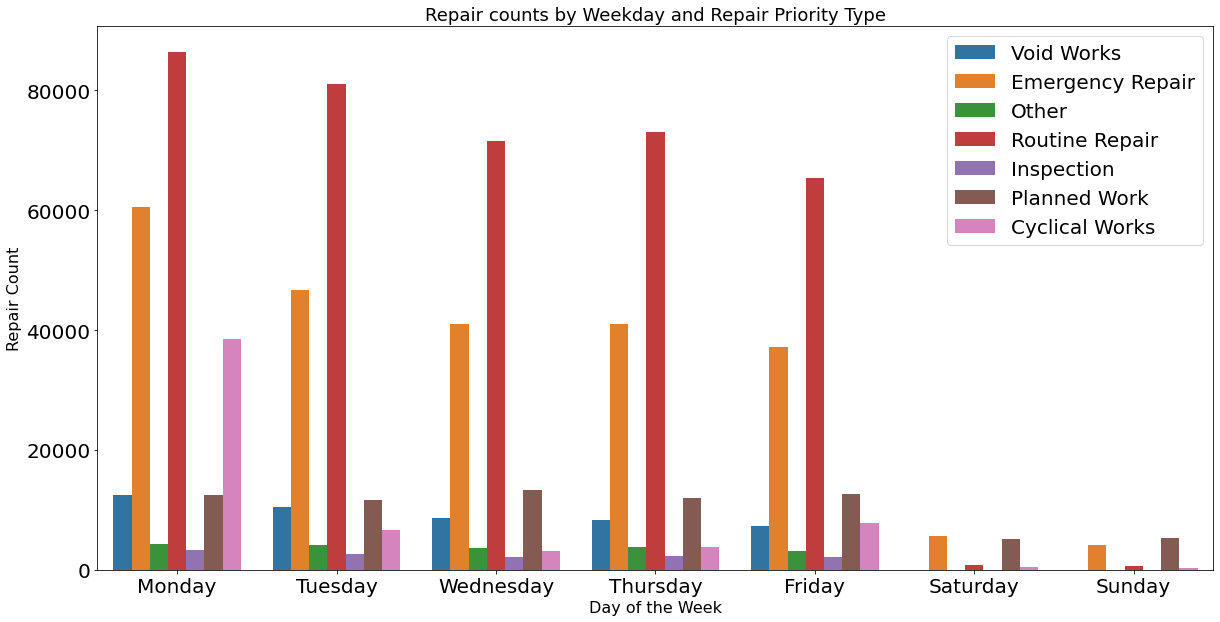

In [34]:
week_map_dict = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}


plt.figure(figsize=(20, 10))
ax = sns.countplot(x='WeekDay', data=job1, hue = 'priority')

# x-axis labels using weekday mapping dictionary
ax.set_xticklabels([week_map_dict[x] for x in range(7)])

plt.title('Repair counts by Weekday and Repair Priority Type', fontsize=18)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Day of the Week', fontsize=16)
ax.set_ylabel('Repair Count', fontsize=16)
plt.legend(fontsize = 20)
plt.show()

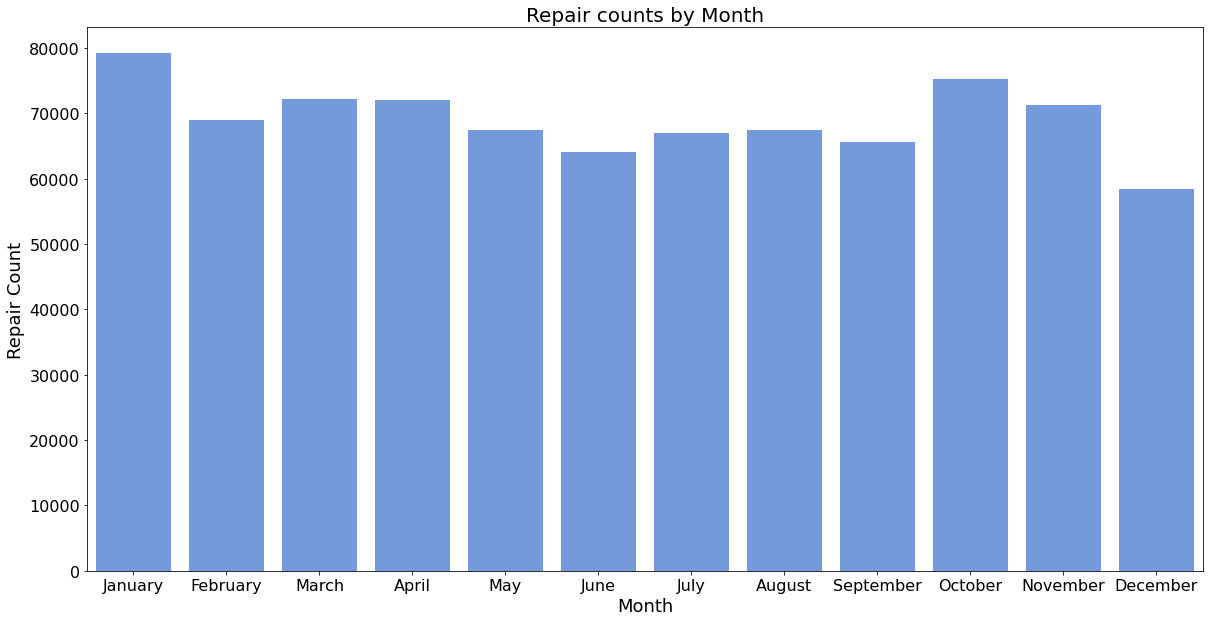

In [35]:
month_map_dict = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}


plt.figure(figsize = (20,10))
ax = sns.countplot(x='Month', data=job1, color = 'cornflowerblue')

# x-axis labels using month mapping dictionary
ax.set_xticklabels([month_map_dict[x] for x in range(1,13)])

plt.title('Repair counts by Month', fontsize = 20)
ax.tick_params(axis='x', labelsize=16)  
ax.tick_params(axis='y', labelsize=16) 
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Repair Count', fontsize=18)
plt.show()

###### Repair counts by Day of Month and Priority

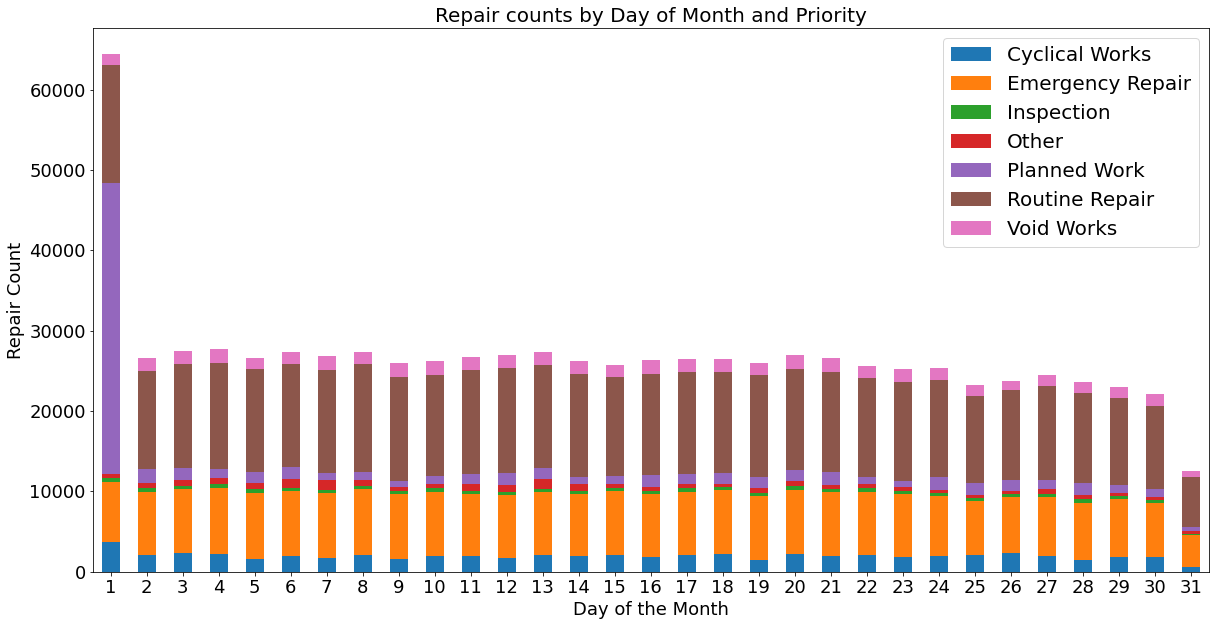

In [36]:

day_priority = job1.groupby(['priority', 'Day']).size().reset_index().pivot(columns='priority', index='Day', values=0)
ax = day_priority.plot(kind='bar', stacked=True, figsize = (20,10))
plt.title('Repair counts by Day of Month and Priority', fontsize=20)
ax.tick_params(axis='x', labelsize=18)  
ax.tick_params(axis='y', labelsize=18) 
ax.set_xlabel('Day of the Month', fontsize=18)
ax.set_ylabel('Repair Count', fontsize=18)
plt.xticks(rotation = 0)
plt.legend(fontsize = 20)
plt.show()

#### Number of properties by Year of Construction

For a small number of properties, 399 to be exact, the construction year is not available and is equal to zero for 219 properties. For a significant portion of these properties, approximately one-eight (1030), the construction year is 1900. The random assignment of the year 1900 as the year of construction was applied by employees at GCH to properties for whom this data was missing. These ambiguous values were later replaced by values imputed based on the most frequent construction year for the particular location or class the property belonged in. Not including ambiguous values of construction year, properties are mainly found to be constructed between 1950 and 1980, with a significant number constructed in the year 1928.

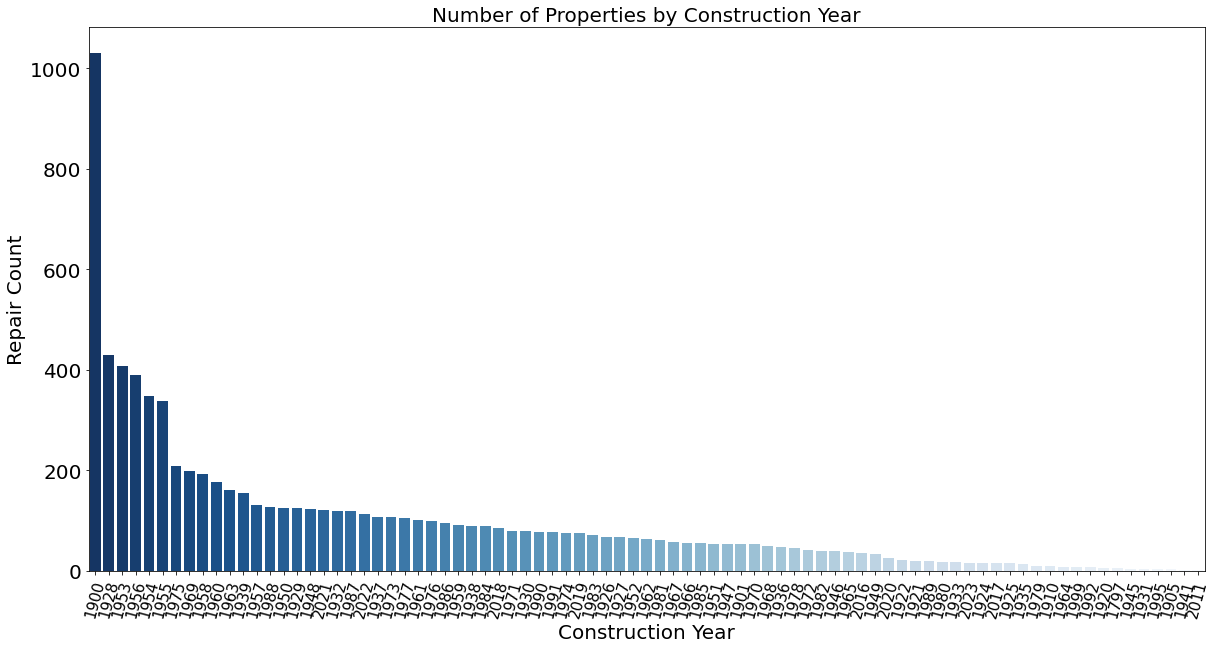

In [37]:
plt.figure(figsize = (20,10))

properties.loc[:, 'construction-yr'] = properties['construction-yr'].fillna(0).astype(int).astype(str)
properties = properties.drop(properties[properties['construction-yr']=='0'].index, axis = 0)
ax = sns.countplot(x='construction-yr', data=properties, order = properties['construction-yr'].value_counts().index, palette = 'Blues_r')

plt.title('Number of Properties by Construction Year', fontsize = 20)
ax.tick_params(axis='x', labelsize=15)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Construction Year', fontsize=20)
ax.set_ylabel('Repair Count', fontsize=20)
plt.xticks(rotation = 75)
plt.show()

### Repair Count by Property Age

C:\Users\adeel\AppData\Local\Temp/ipykernel_27108/175753022.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  job_prop.loc[:, 'construction-yr'] = job_prop['construction-yr'].fillna(0).astype(int)


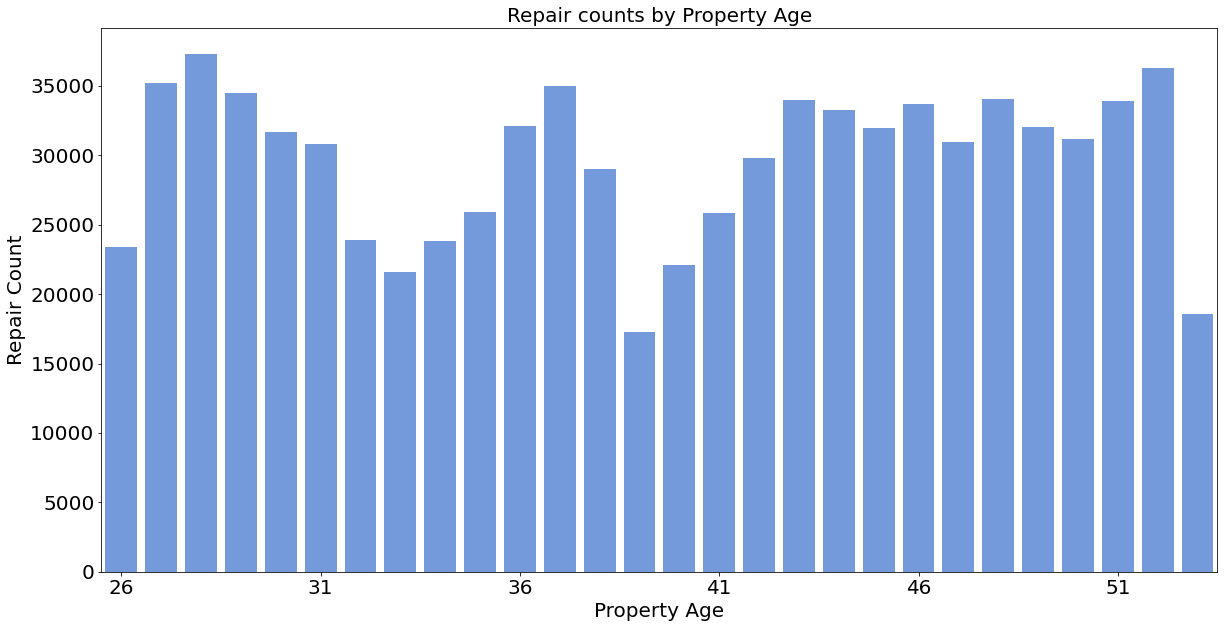

In [38]:
# merging jobs with properties to get job reapir count for all proerties

job_prop = job1.merge(prop_final, how='left', left_on='pr-seq-no', right_on='seq-no')
job_prop.loc[:, 'construction-yr'] = job_prop['construction-yr'].fillna(0).astype(int)
job_prop['job_report_date'] = pd.to_datetime(job_prop['job_report_date'])
job_prop['construction-yr'] = pd.to_datetime(job_prop['construction-yr'])

job_prop.loc[:, 'property_age'] = (job_prop['job_report_date'].dt.year - job_prop['construction-yr'].dt.year)

plt.figure(figsize = (20,10))

ax = sns.countplot(x='property_age', data=job_prop[job_prop['property_age']>1], color = 'cornflowerblue')

tick_freq = 5  
ax.set_xticks(ax.get_xticks()[::tick_freq])
plt.title('Repair counts by Property Age', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Age', fontsize=20)
ax.set_ylabel('Repair Count', fontsize=20)
plt.show()

##### for filtered dataset: those repairs for whom tenancy data is available
Properties that are newer tend to generate more repair reports


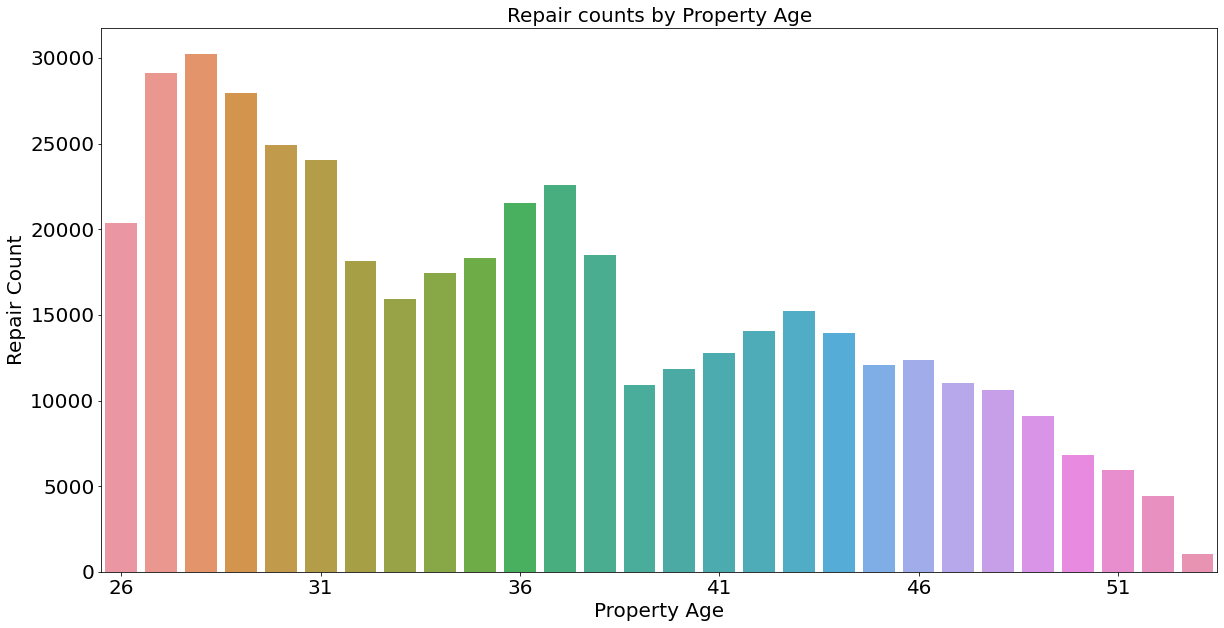

In [39]:
plt.figure(figsize = (20,10))

ax = sns.countplot(x='property_age', data=filtered_job_tenancy_person_prop)

# x-axis tick frequency adjustments
tick_freq = 5  
ax.set_xticks(ax.get_xticks()[::tick_freq])
plt.title('Repair counts by Property Age', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Age', fontsize=20)
ax.set_ylabel('Repair Count', fontsize=20)
plt.show()

# newer properties (age at the time of repair reported) have more repair reports 


### Repair Count by Tenancy Length 
##### tenancy length at the time of repair report

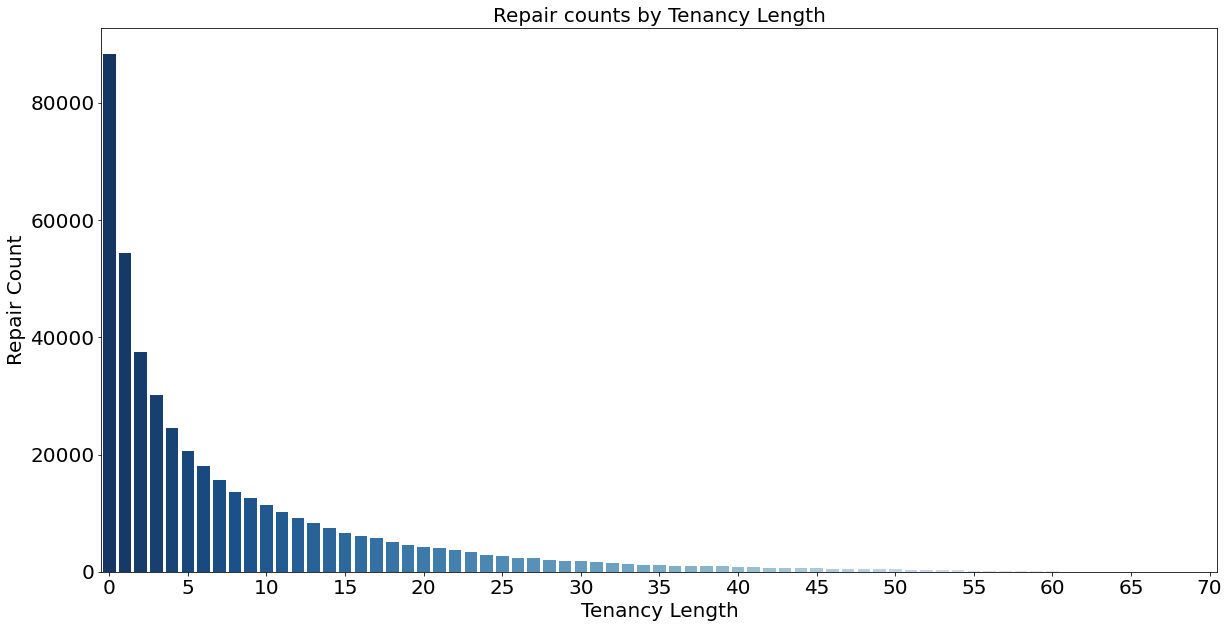

In [40]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='length_of_tenancy', data=filtered_job_tenancy_person_prop, palette = 'Blues_r')

tick_freq = 5  
ax.set_xticks(ax.get_xticks()[::tick_freq])
plt.title('Repair counts by Tenancy Length', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Tenancy Length', fontsize=20)
ax.set_ylabel('Repair Count', fontsize=20)
plt.show()


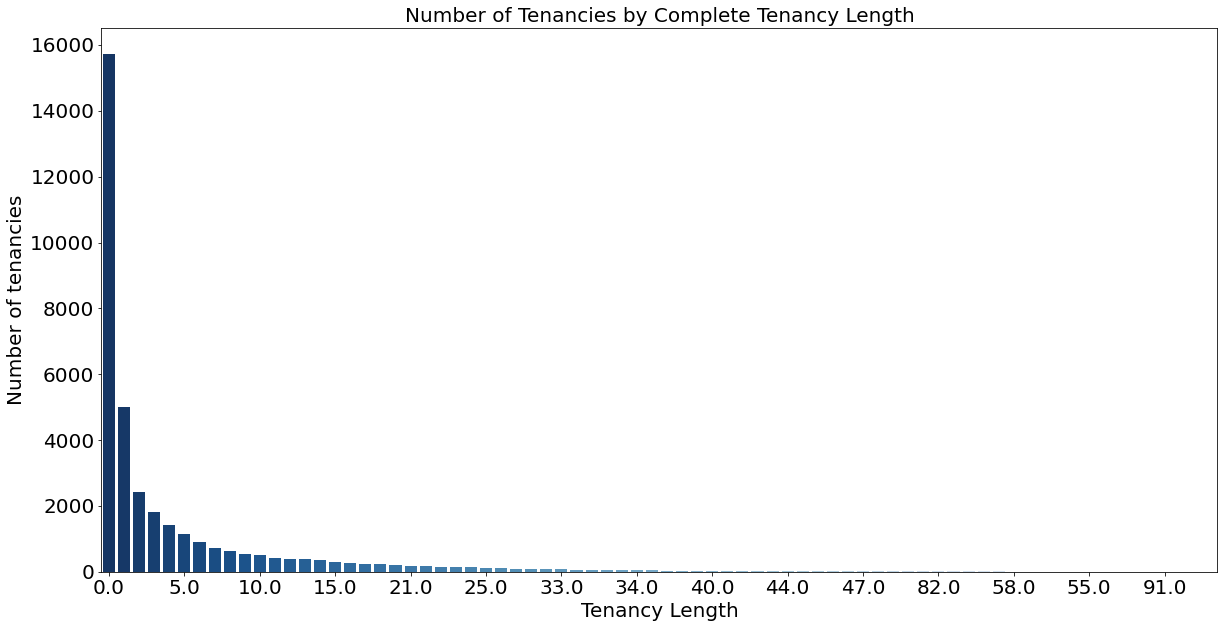

In [41]:
plt.figure(figsize = (20,10))
tenancy['complete_length_of_tenancy'] = (tenancy['term_dat'].dt.year - tenancy['comm_dat'].dt.year)
ax = sns.countplot(x='complete_length_of_tenancy', data=tenancy, palette = 'Blues_r', order = tenancy['complete_length_of_tenancy'].value_counts().index[:-25])

tick_freq = 5  
ax.set_xticks(ax.get_xticks()[::tick_freq])
plt.title('Number of Tenancies by Complete Tenancy Length', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Tenancy Length', fontsize=20)
ax.set_ylabel('Number of tenancies', fontsize=20)
plt.show()


#### Non-void vs void tenancies

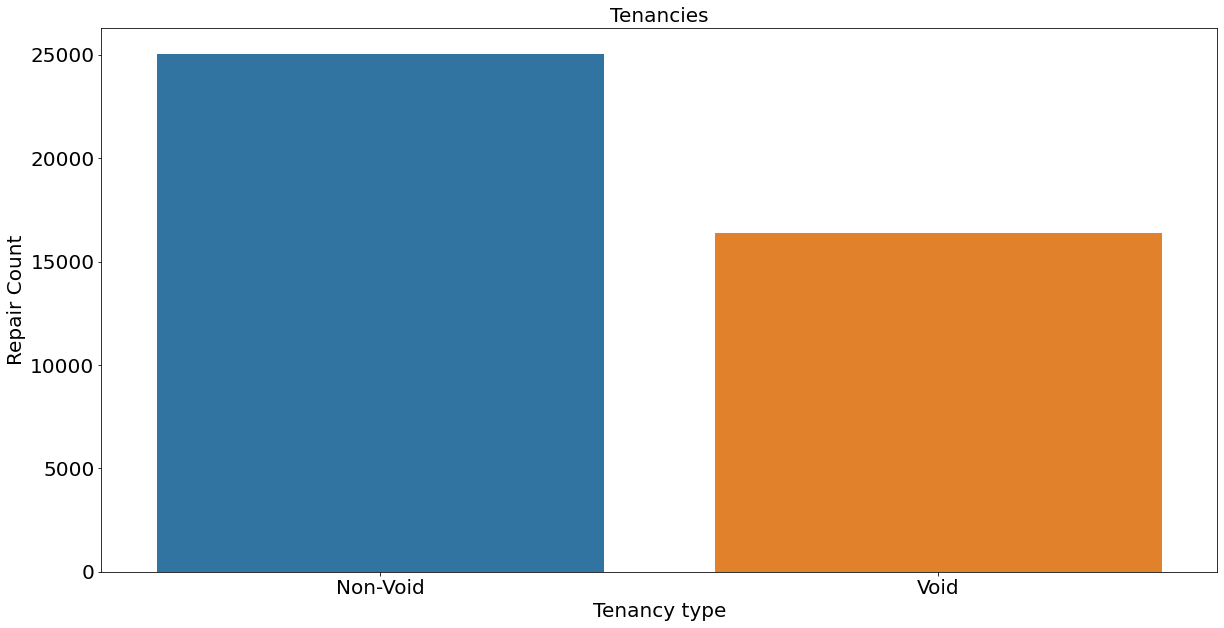

In [42]:
# plt.figure(figsize = (20,10))
# ax = sns.countplot(x='void', data=tenancy)
# plt.title('Tenancies', fontsize = 20)
# ax.set_xticklabels(['Non-Void', 'Void'], fontsize=20)
# ax.tick_params(axis='x', labelsize=20)  
# ax.tick_params(axis='y', labelsize=20) 
# ax.set_xlabel('Tenancy type', fontsize=20)
# ax.set_ylabel('Repair Count', fontsize=20)
# plt.show()

### Repair Count for each property class

##### Number of properties by property class

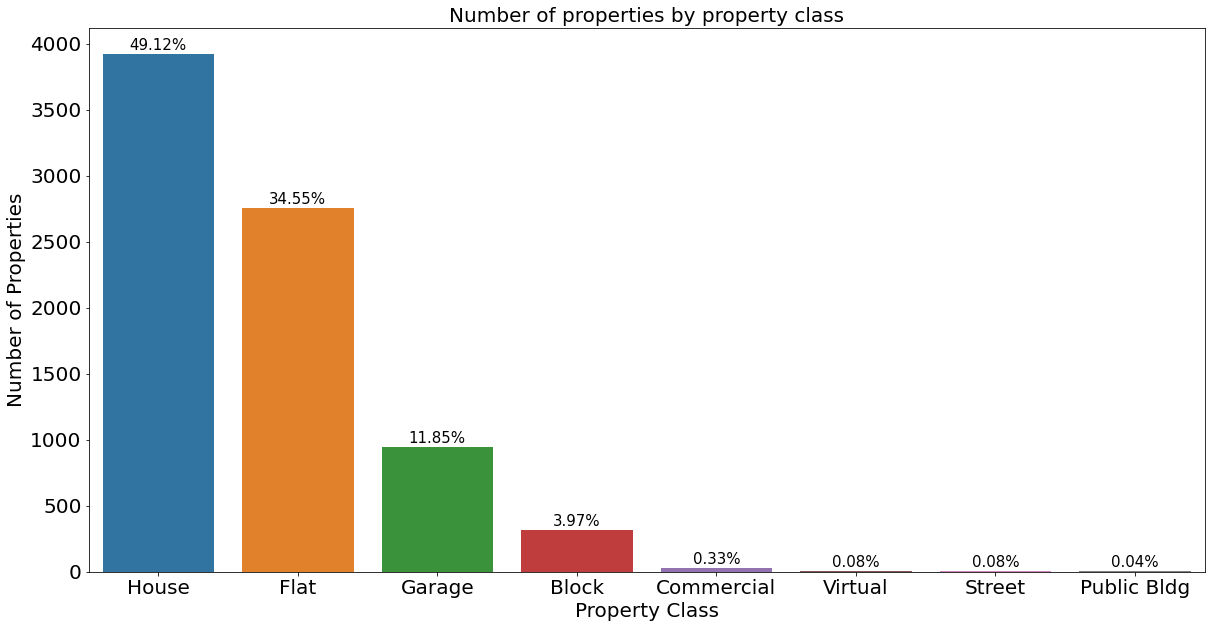

In [43]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='property_class', data=properties, order= properties['property_class'].value_counts().index)

total_count = len(properties)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, f'{(height / total_count) * 100:.02f}%', ha='center', fontsize=15)

plt.title('Number of properties by property class', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Class', fontsize=20)
ax.set_ylabel('Number of Properties', fontsize=20)
plt.show()

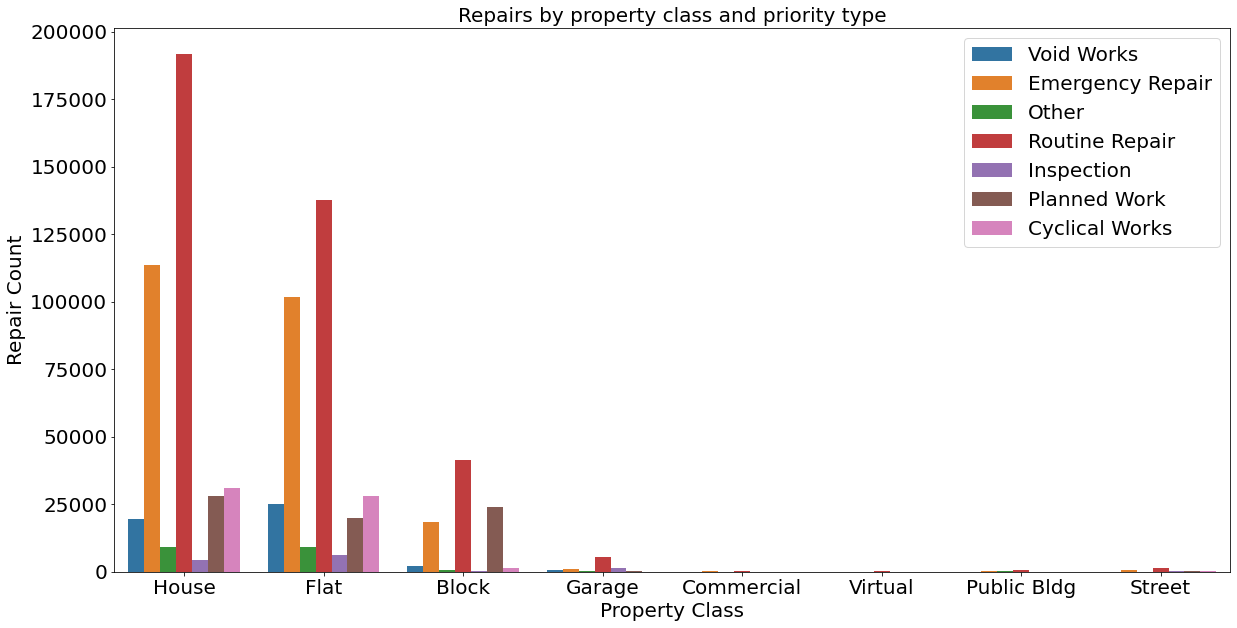

In [44]:

plt.figure(figsize = (20,10))
ax = sns.countplot(x='property_class', data=job_prop, hue = 'priority')

plt.title('Repairs by property class and priority type', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Class', fontsize=20)
ax.set_ylabel('Repair Count', fontsize=20)
plt.legend(loc = 'upper right', fontsize = 20)
plt.show()

### Repair Count for location code

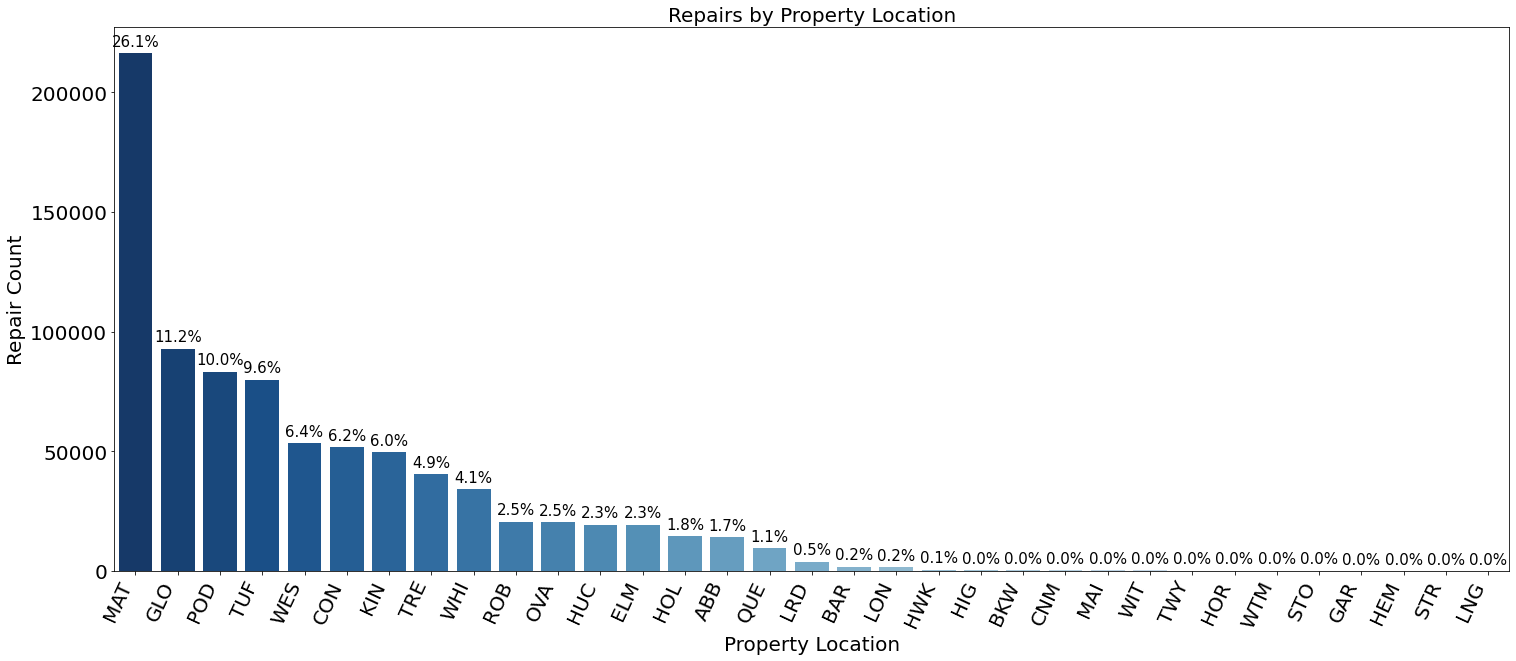

In [45]:
plt.figure(figsize = (25,10))
ax = sns.countplot(x='location_code', data=job_prop,  order = job_prop['location_code'].value_counts().index, palette = 'Blues_r')

total_count = len(job_prop)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3000, f'{(height / total_count) * 100:.01f}%', ha='center', fontsize=15)

plt.title('Repairs by Property Location', fontsize = 20,)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Location', fontsize=20)
ax.set_ylabel('Repair Count', fontsize=20)
plt.xticks(rotation = 65, ha = 'right')
plt.show()

### Number of Properties by location code

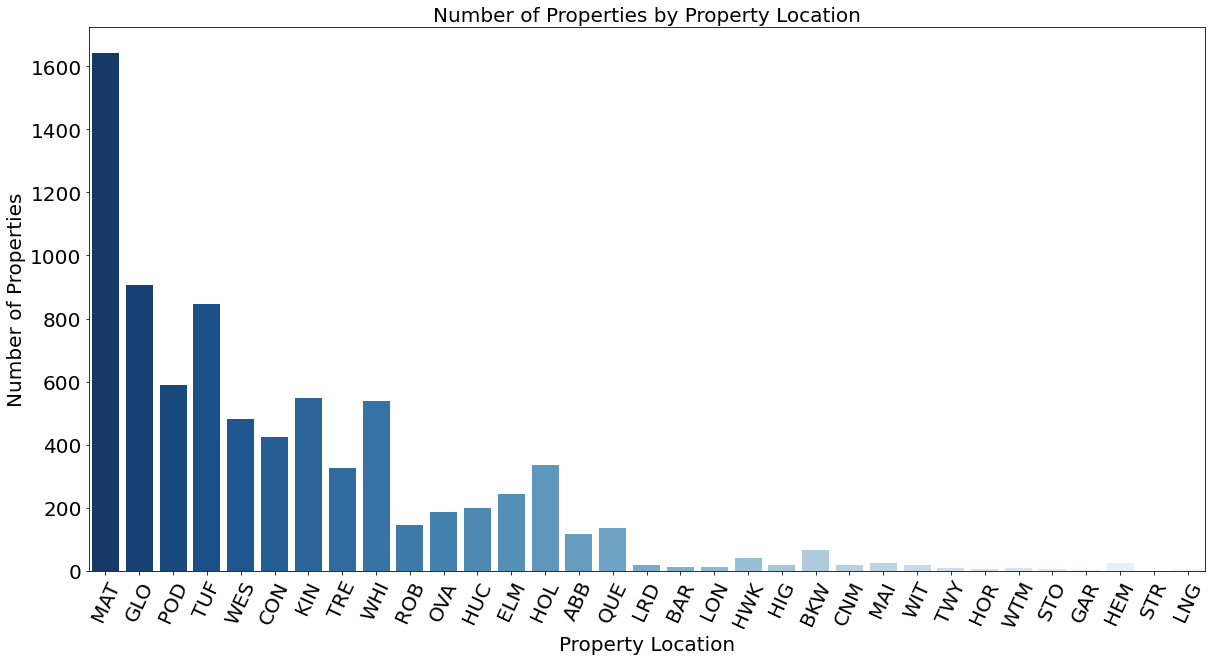

In [46]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='location_code', data=properties,  order = job_prop['location_code'].value_counts().index, palette = 'Blues_r')
plt.title('Number of Properties by Property Location', fontsize = 20,)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Location', fontsize=20)
ax.set_ylabel('Number of Properties', fontsize=20)
plt.xticks(rotation = 65)
plt.show()

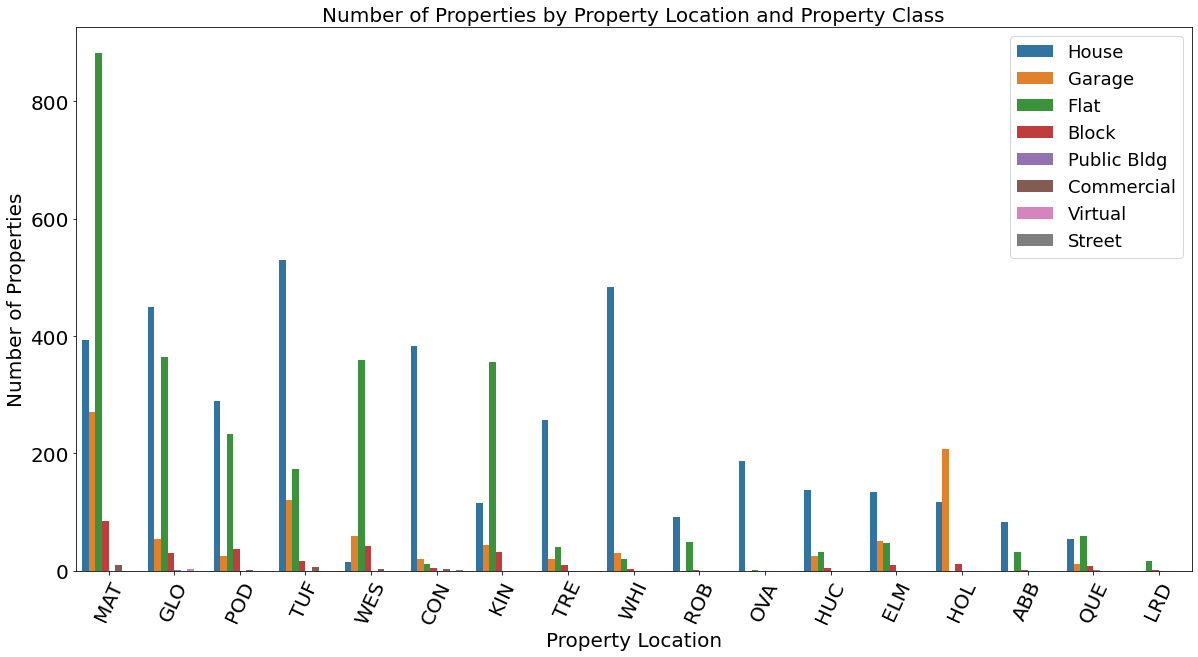

In [47]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='location_code', data=properties,  order = job_prop['location_code'].value_counts().index[:-16], hue = 'property_class')
plt.title('Number of Properties by Property Location and Property Class', fontsize = 20,)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Location', fontsize=20)
ax.set_ylabel('Number of Properties', fontsize=20)
plt.legend(loc='upper right', fontsize = 18)

plt.xticks(rotation = 65)
plt.show()

### Repair Count for property size

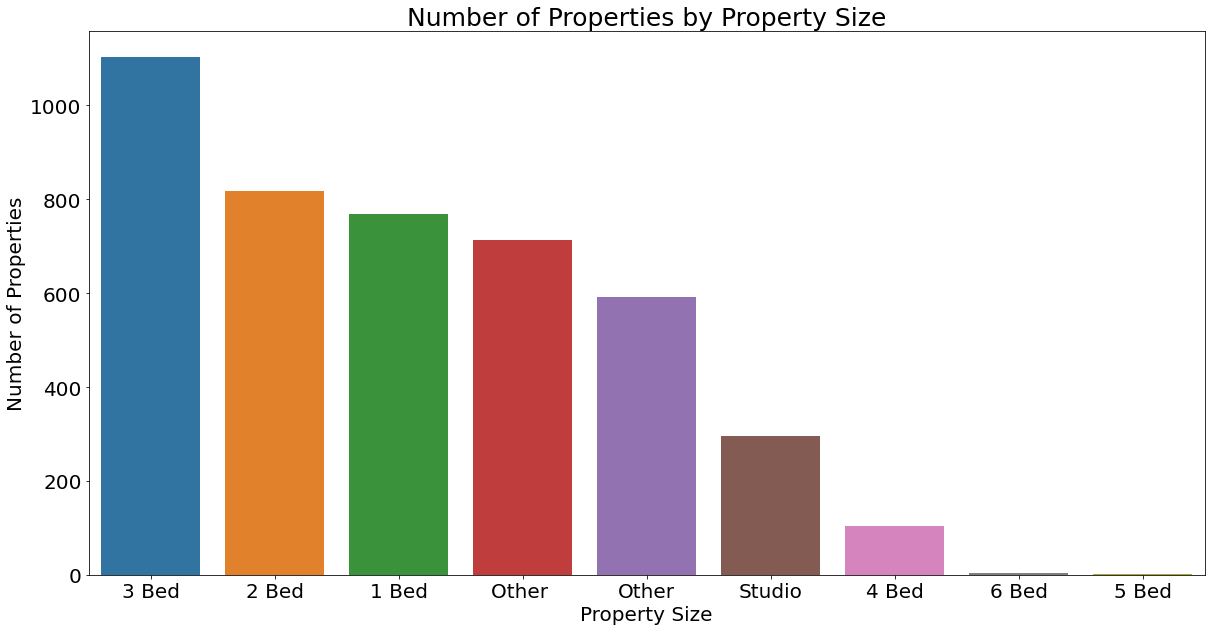

In [48]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='property_size', data=properties,  order = properties['property_size'].value_counts().index)
plt.title('Number of Properties by Property Size', fontsize = 25)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Size', fontsize=20)
ax.set_ylabel('Number of Properties', fontsize=20)
plt.show()

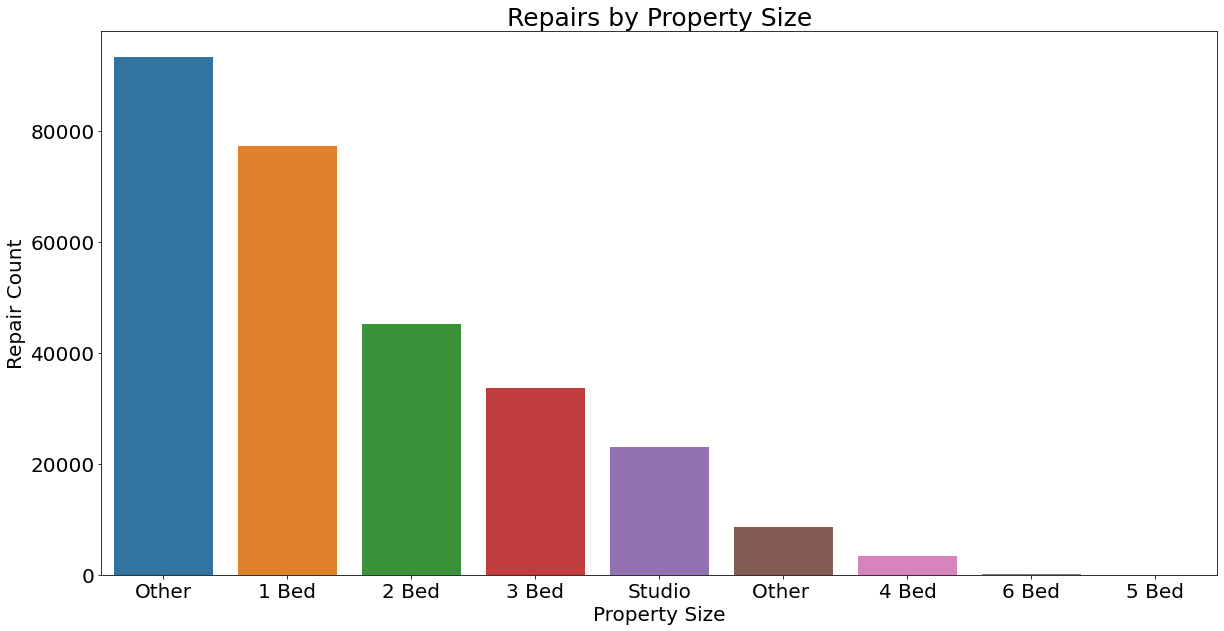

In [49]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='property_size', data=job_prop,  order = job_prop['property_size'].value_counts().index)
plt.title('Repairs by Property Size', fontsize = 25)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Size', fontsize=20)
ax.set_ylabel('Repair Count', fontsize=20)
plt.show()

#### Repair Count by property size
For those repair for which tenancy data is available

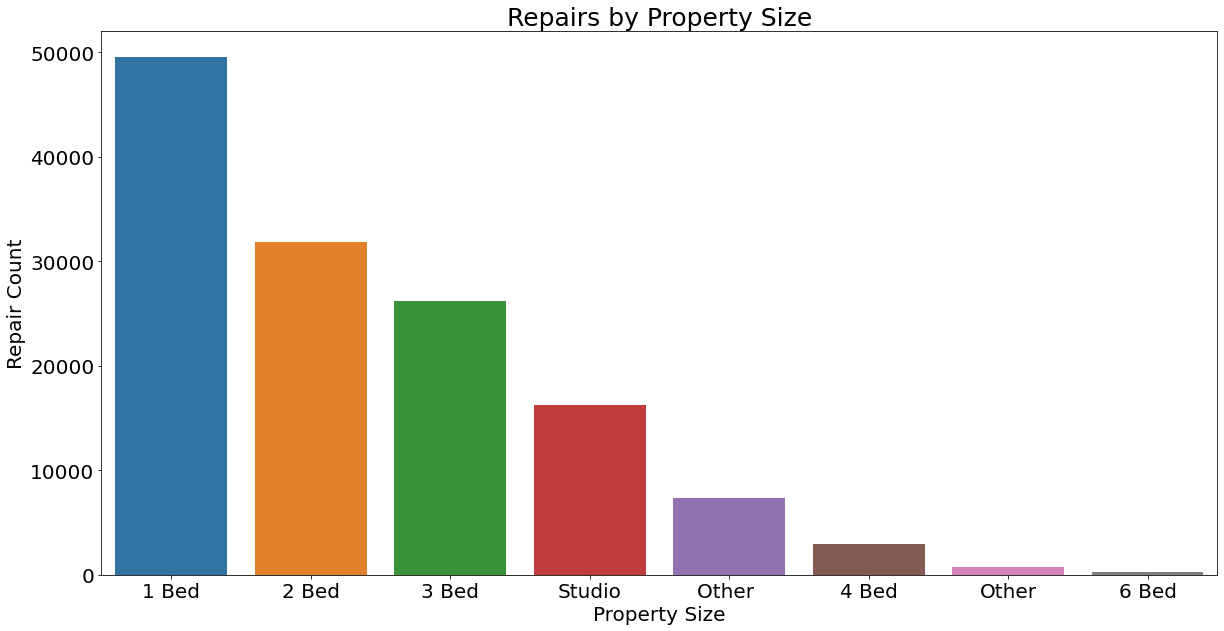

In [50]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='property_size', data=filtered_job_tenancy_person_prop,  order = filtered_job_tenancy_person_prop['property_size'].value_counts().index)
plt.title('Repairs by Property Size', fontsize = 25)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Size', fontsize=20)
ax.set_ylabel('Repair Count', fontsize=20)
plt.show()

### Repair Count by property style

#### Number of properties by property style


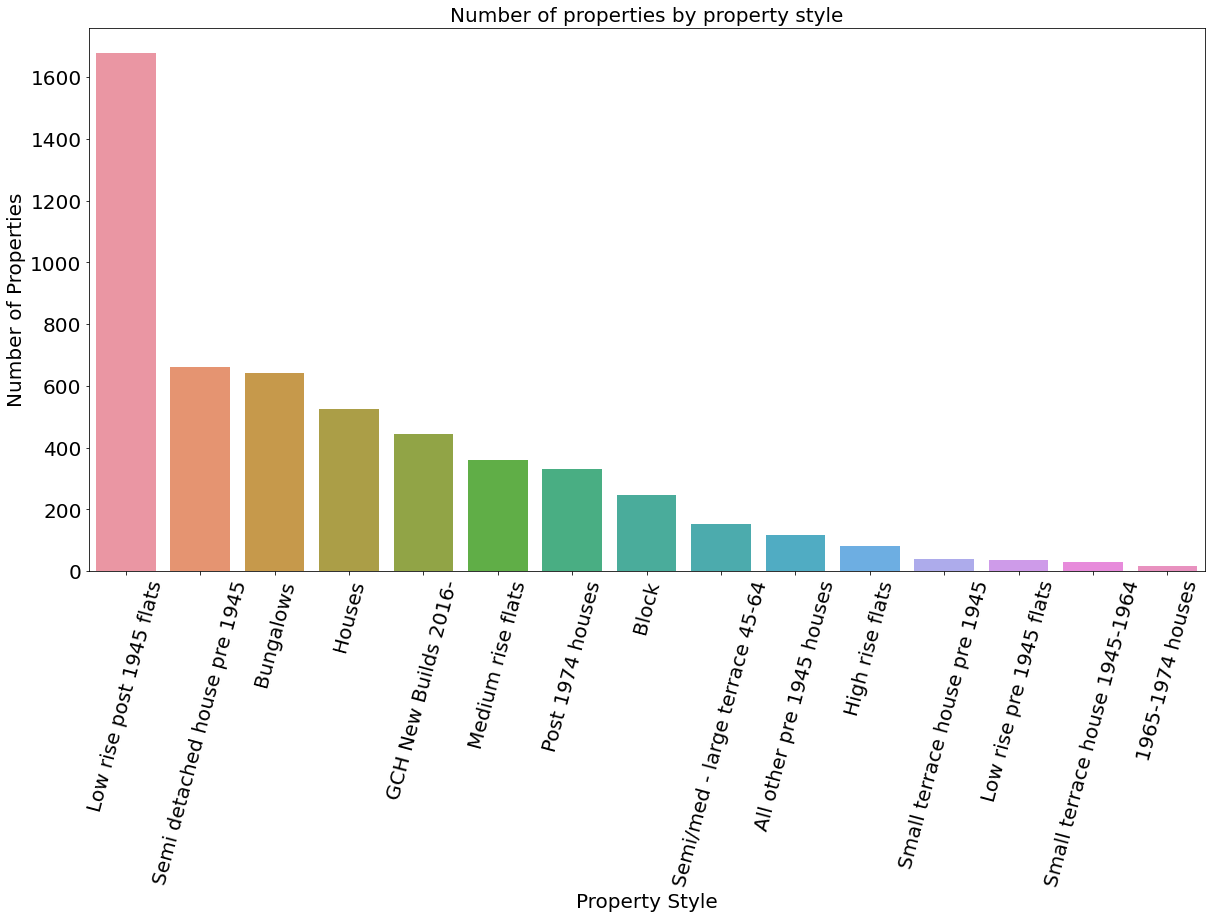

In [51]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='property_style', data=properties, order= properties['property_style'].value_counts().index)
plt.title('Number of properties by property style', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Style', fontsize=20)
ax.set_ylabel('Number of Properties', fontsize=20)
plt.xticks(rotation = 75)
plt.show()

#### Repair Count by property style (all properties)

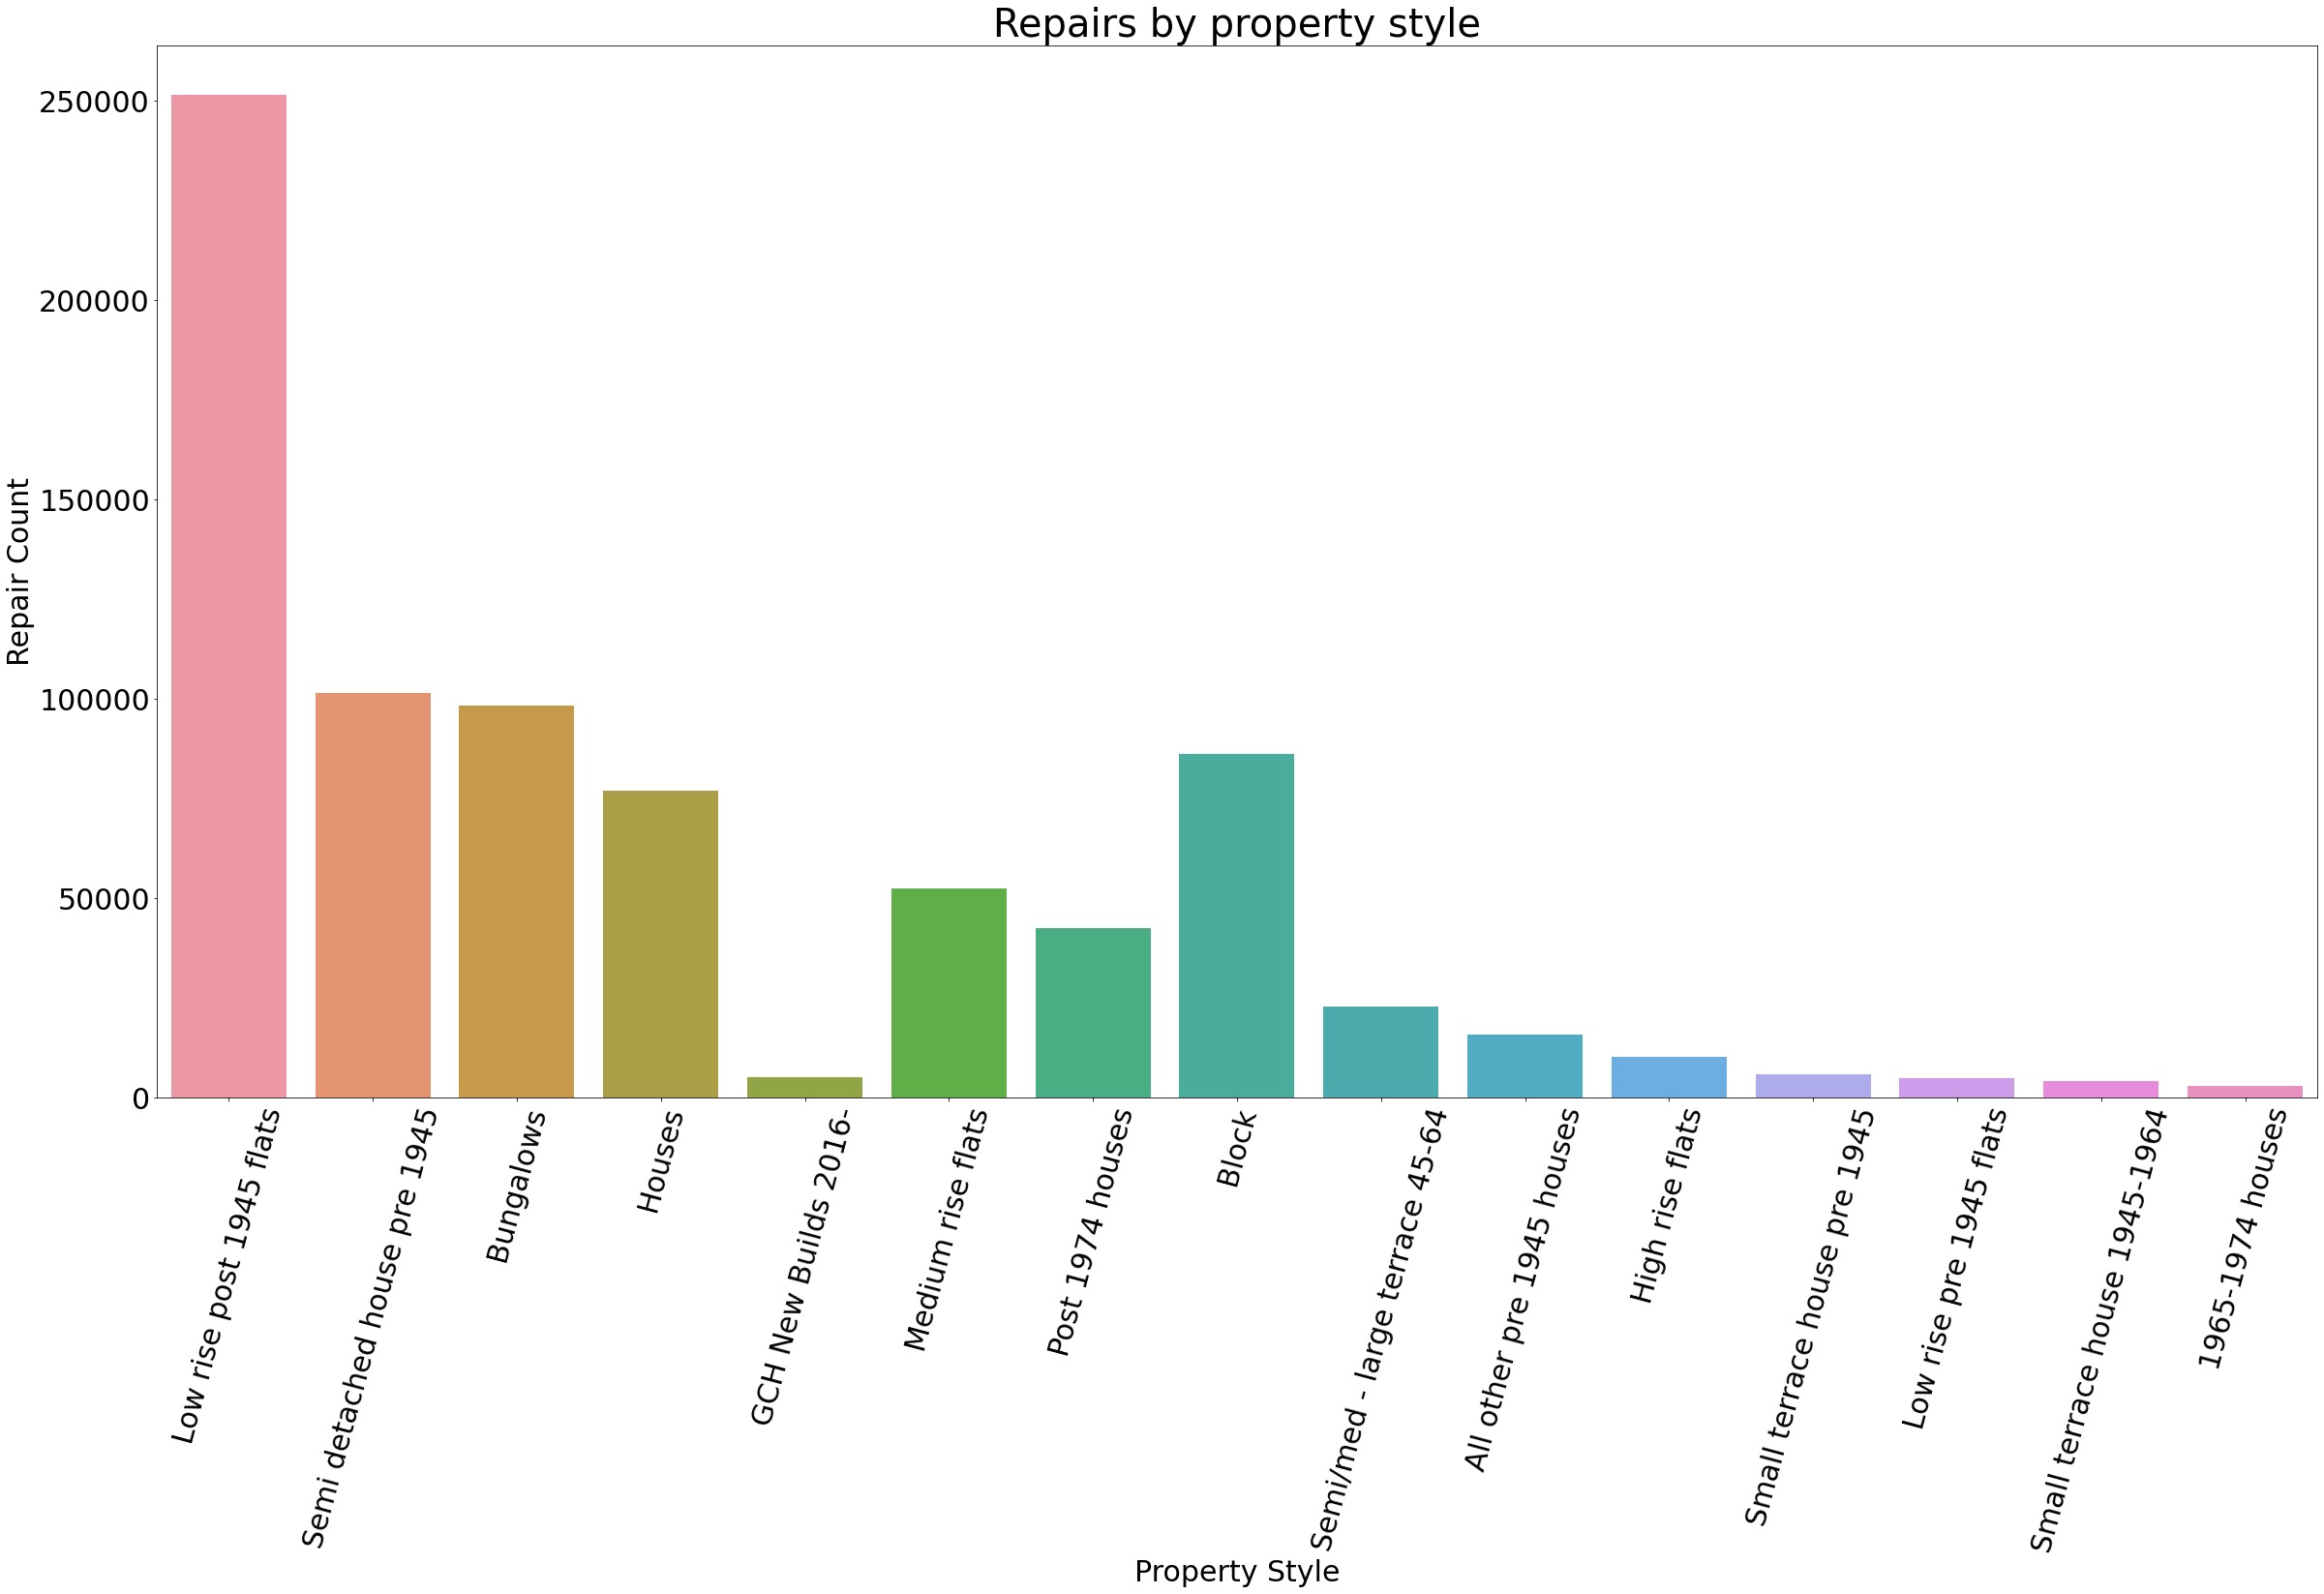

In [52]:
plt.figure(figsize = (40,20))
ax = sns.countplot(x='property_style', data=job_prop,  order = properties['property_style'].value_counts().index)
plt.title('Repairs by property style', fontsize = 40)
ax.tick_params(axis='x', labelsize=30)  
ax.tick_params(axis='y', labelsize=30) 
ax.set_xlabel('Property Style', fontsize=30)
ax.set_ylabel('Repair Count', fontsize=30)
plt.xticks(rotation = 75)
plt.show()

#### Repair Count by property style (properties whose tenancy data is available)

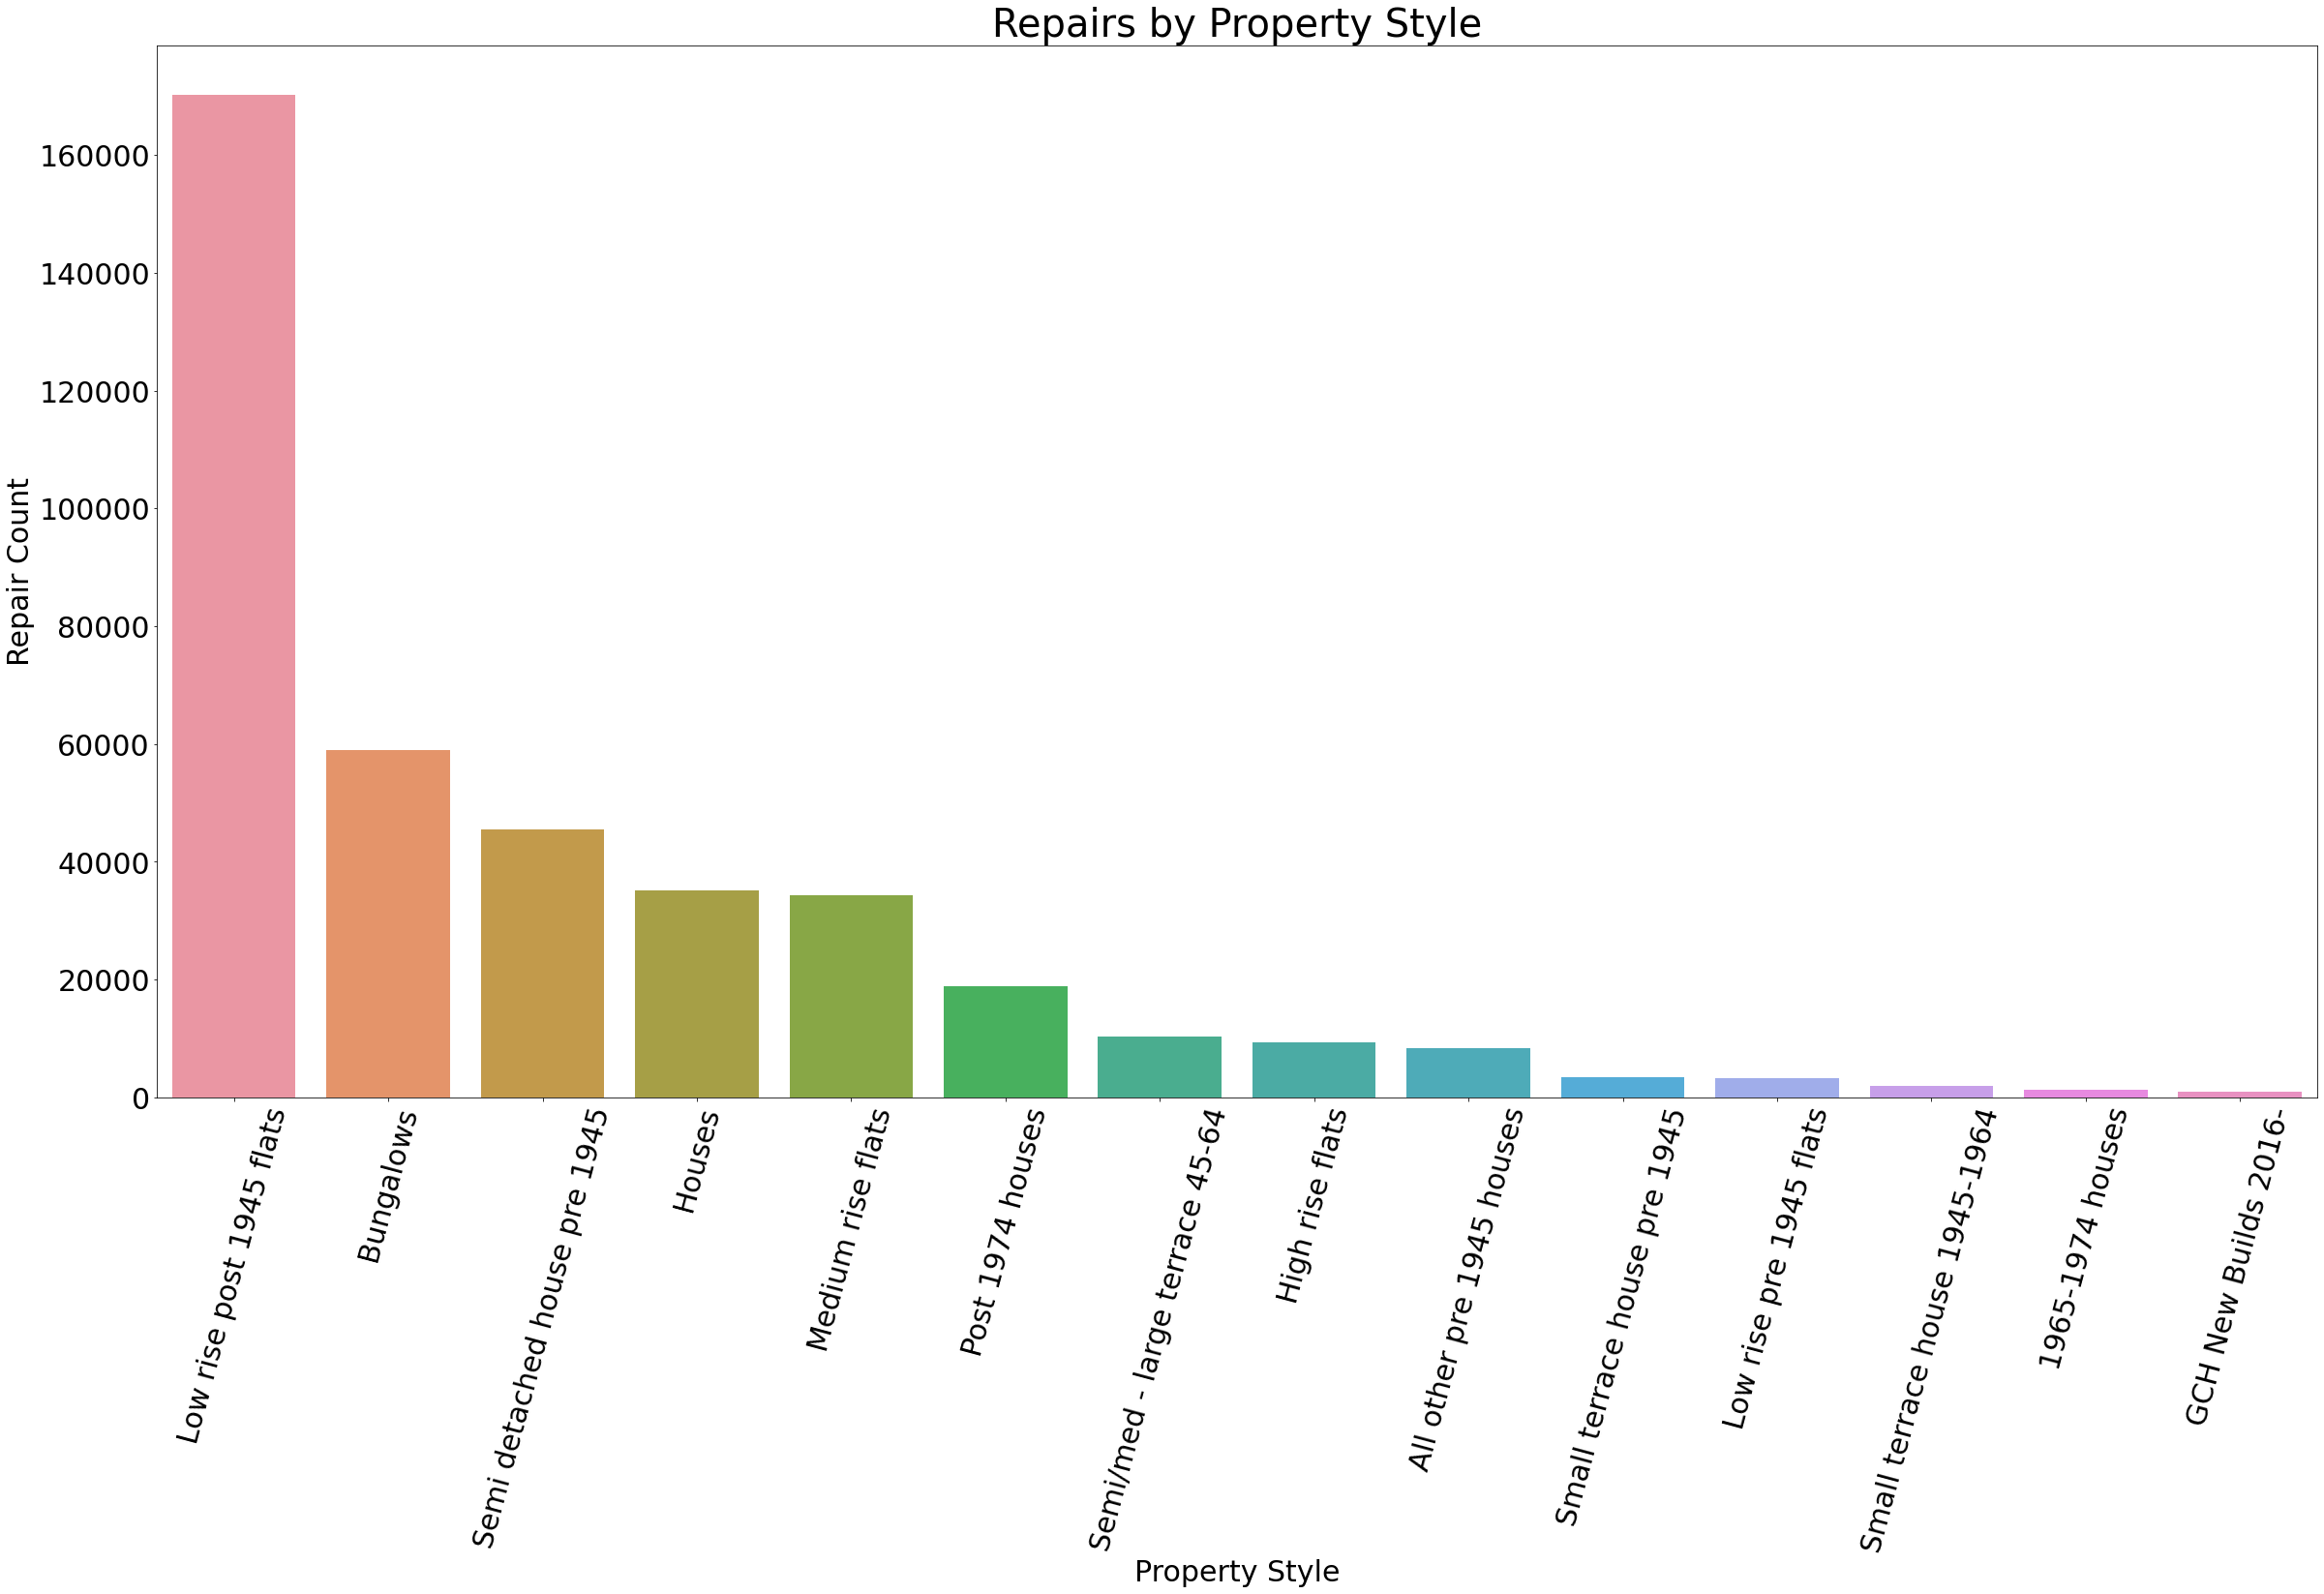

In [53]:
plt.figure(figsize = (40,20))
ax = sns.countplot(x='property_style', data=filtered_job_tenancy_person_prop, order = filtered_job_tenancy_person_prop['property_style'].value_counts().index)
plt.title('Repairs by Property Style', fontsize = 40)
ax.tick_params(axis='x', labelsize=30)  
ax.tick_params(axis='y', labelsize=30)
ax.set_xlabel('Property Style', fontsize=30)
ax.set_ylabel('Repair Count', fontsize=30)
plt.xticks(rotation = 75)
plt.show()

#### Number of properties and repair count by property class and style combined

##### Number of properties

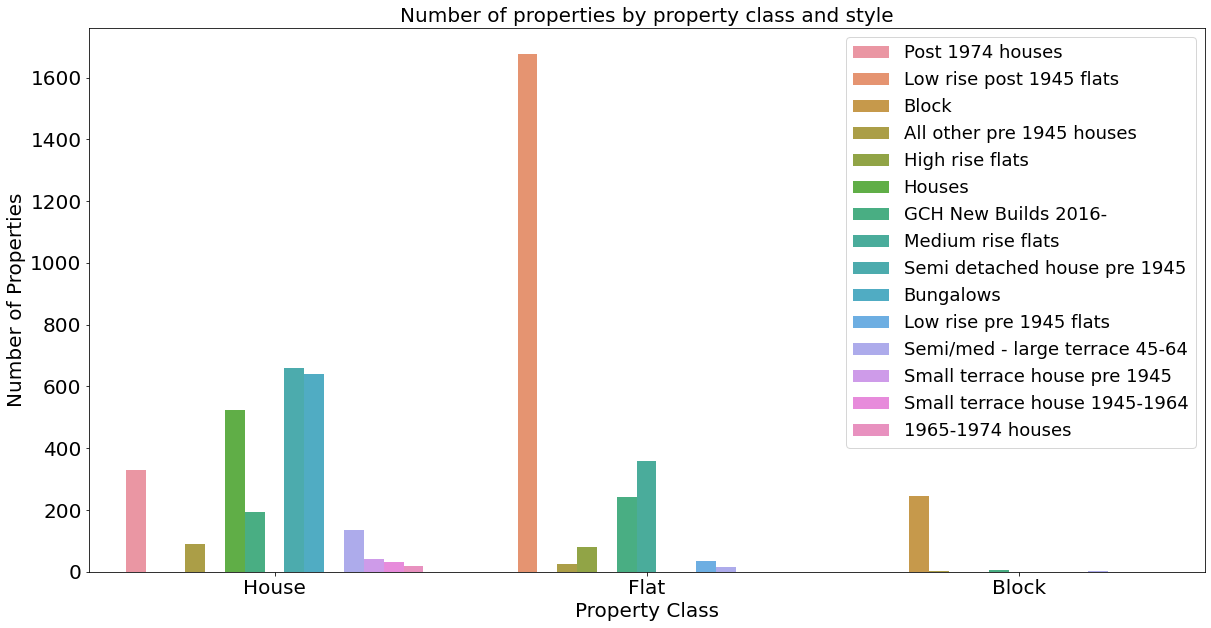

In [54]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='property_class', data=properties, order= job_prop['property_class'].value_counts().index[:-5], hue = 'property_style')
plt.title('Number of properties by property class and style', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Class', fontsize=20)
ax.set_ylabel('Number of Properties', fontsize=20)

plt.legend(loc = 'upper right', fontsize = 18)
plt.show()

##### Repair demand

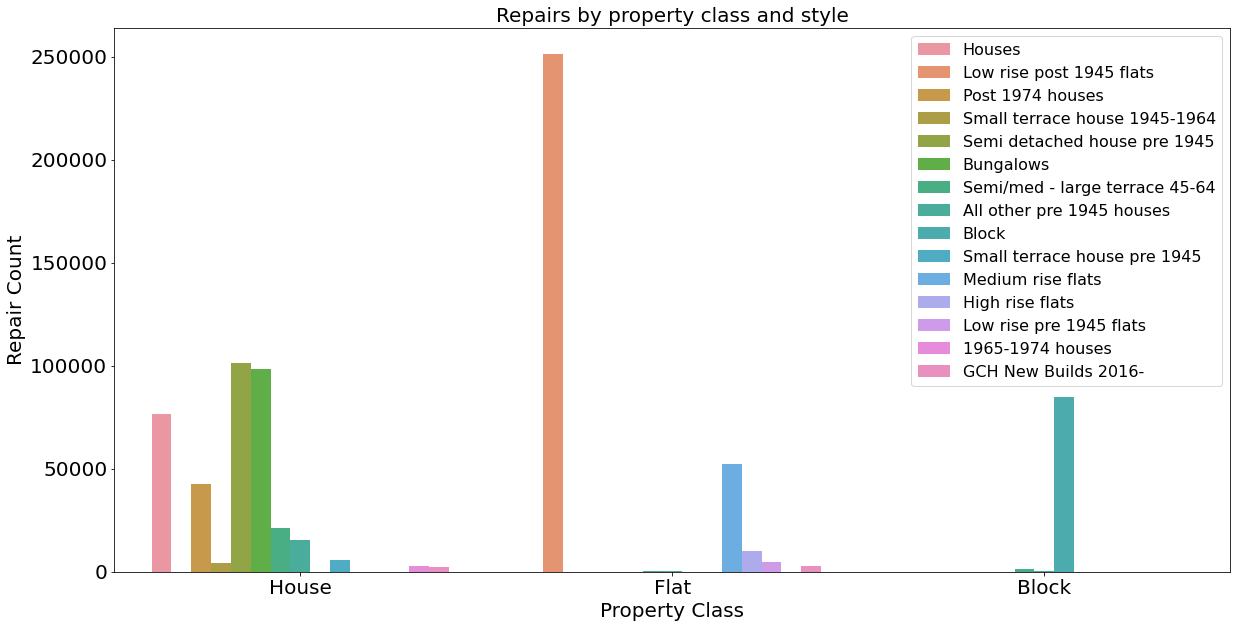

In [55]:
job_prop = job1.merge(prop_final, how='left', left_on='pr-seq-no', right_on='seq-no')
plt.figure(figsize = (20,10))
ax = sns.countplot(x='property_class', data=job_prop, hue = 'property_style', order = job_prop['property_class'].value_counts().index[:-5])
plt.title('Repairs by property class and style', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Class', fontsize=20)
ax.set_ylabel('Repair Count', fontsize=20)
plt.legend(loc = 'upper right', fontsize = 16)
plt.show()

#### Repair count by property class (only houses and flats) and size

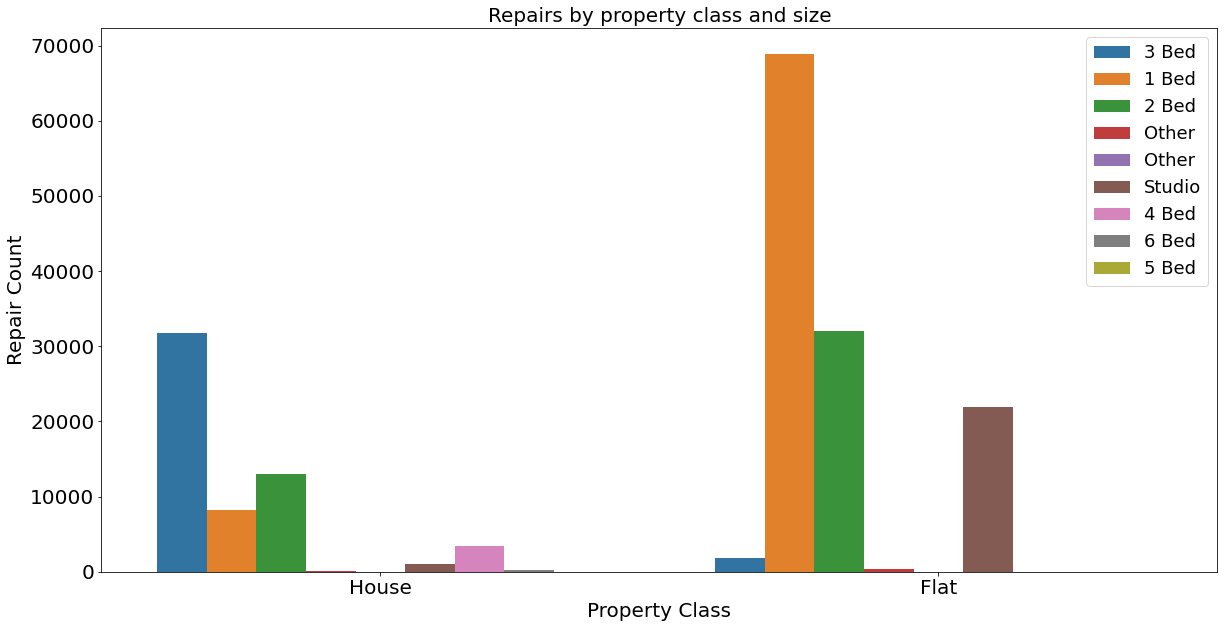

In [56]:
job_prop = job1.merge(prop_final, how='left', left_on='pr-seq-no', right_on='seq-no')
plt.figure(figsize = (20,10))
ax = sns.countplot(x='property_class', data=job_prop, hue = 'property_size', order = job_prop['property_class'].value_counts().index[:-6])
plt.title('Repairs by property class and size', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=20) 
ax.set_xlabel('Property Class', fontsize=20)
ax.set_ylabel('Repair Count', fontsize=20)
plt.legend(loc = 'upper right', fontsize = 18)
plt.show()

### Repair Count by marital status

2          N
4          M
13         D
18         N
22         W
          ..
5031364    S
5031415    M
5031497    M
5031647    D
5031795    M
Name: apermarsts-cde, Length: 441144, dtype: object


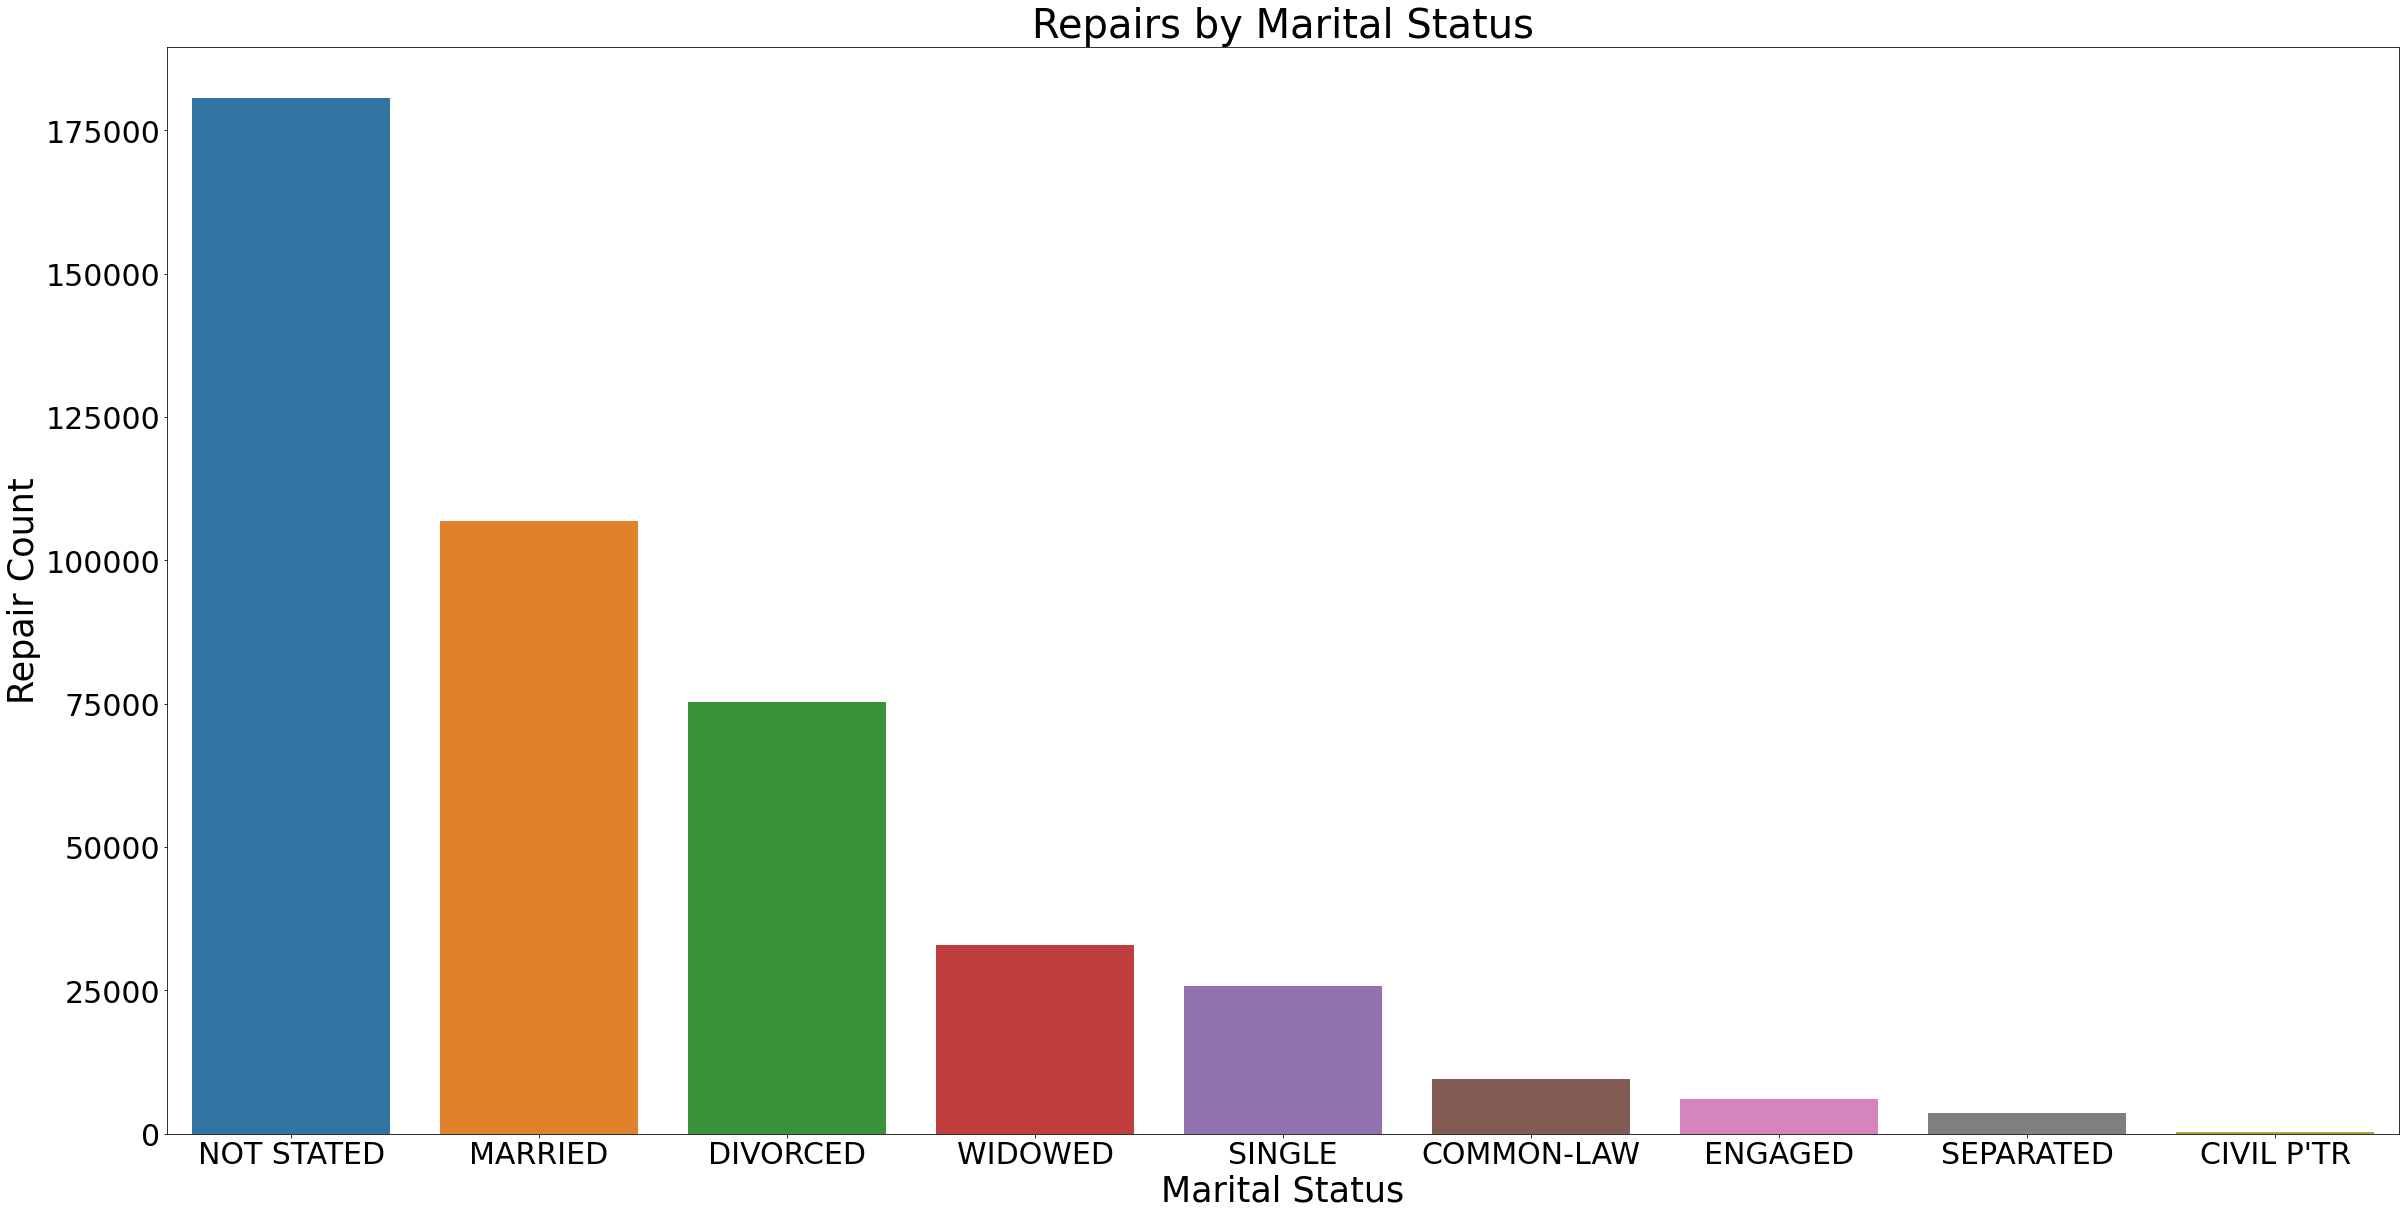

In [57]:
print(filtered_job_tenancy_person_prop['apermarsts-cde'])

# change instances of 's' to 'S' 
filtered_job_tenancy_person_prop.loc[filtered_job_tenancy_person_prop['apermarsts-cde'] == 's', 'apermarsts-cde'] = 'S'

marital_status_map = {
    
    'A': 'SEPARATED',
    'C': 'CIVIL P\'TR',
    'D': 'DIVORCED',
    'E': 'ENGAGED',
    'L': 'COMMON-LAW',
    'M': 'MARRIED',
    'N': 'NOT STATED',
    'S': 'SINGLE',
    'W': 'WIDOWED'
}


plt.figure(figsize = (40,20))
ax = sns.countplot(x='apermarsts-cde', data=filtered_job_tenancy_person_prop, order = filtered_job_tenancy_person_prop['apermarsts-cde'].value_counts().index)
plt.title('Repairs by Marital Status', fontsize = 40)
ax.set_xticklabels([marital_status_map[label] for label in filtered_job_tenancy_person_prop['apermarsts-cde'].unique()])
ax.tick_params(axis='x', labelsize=30)  
ax.tick_params(axis='y', labelsize=30) 
ax.set_xlabel('Marital Status', fontsize=35)
ax.set_ylabel('Repair Count', fontsize=35)
plt.show()

2          NaN
4           EW
13          EW
18         NaN
22          EW
          ... 
5031364     EW
5031415     EW
5031497     EW
5031647     EW
5031795     EW
Name: eth-cde, Length: 441144, dtype: object


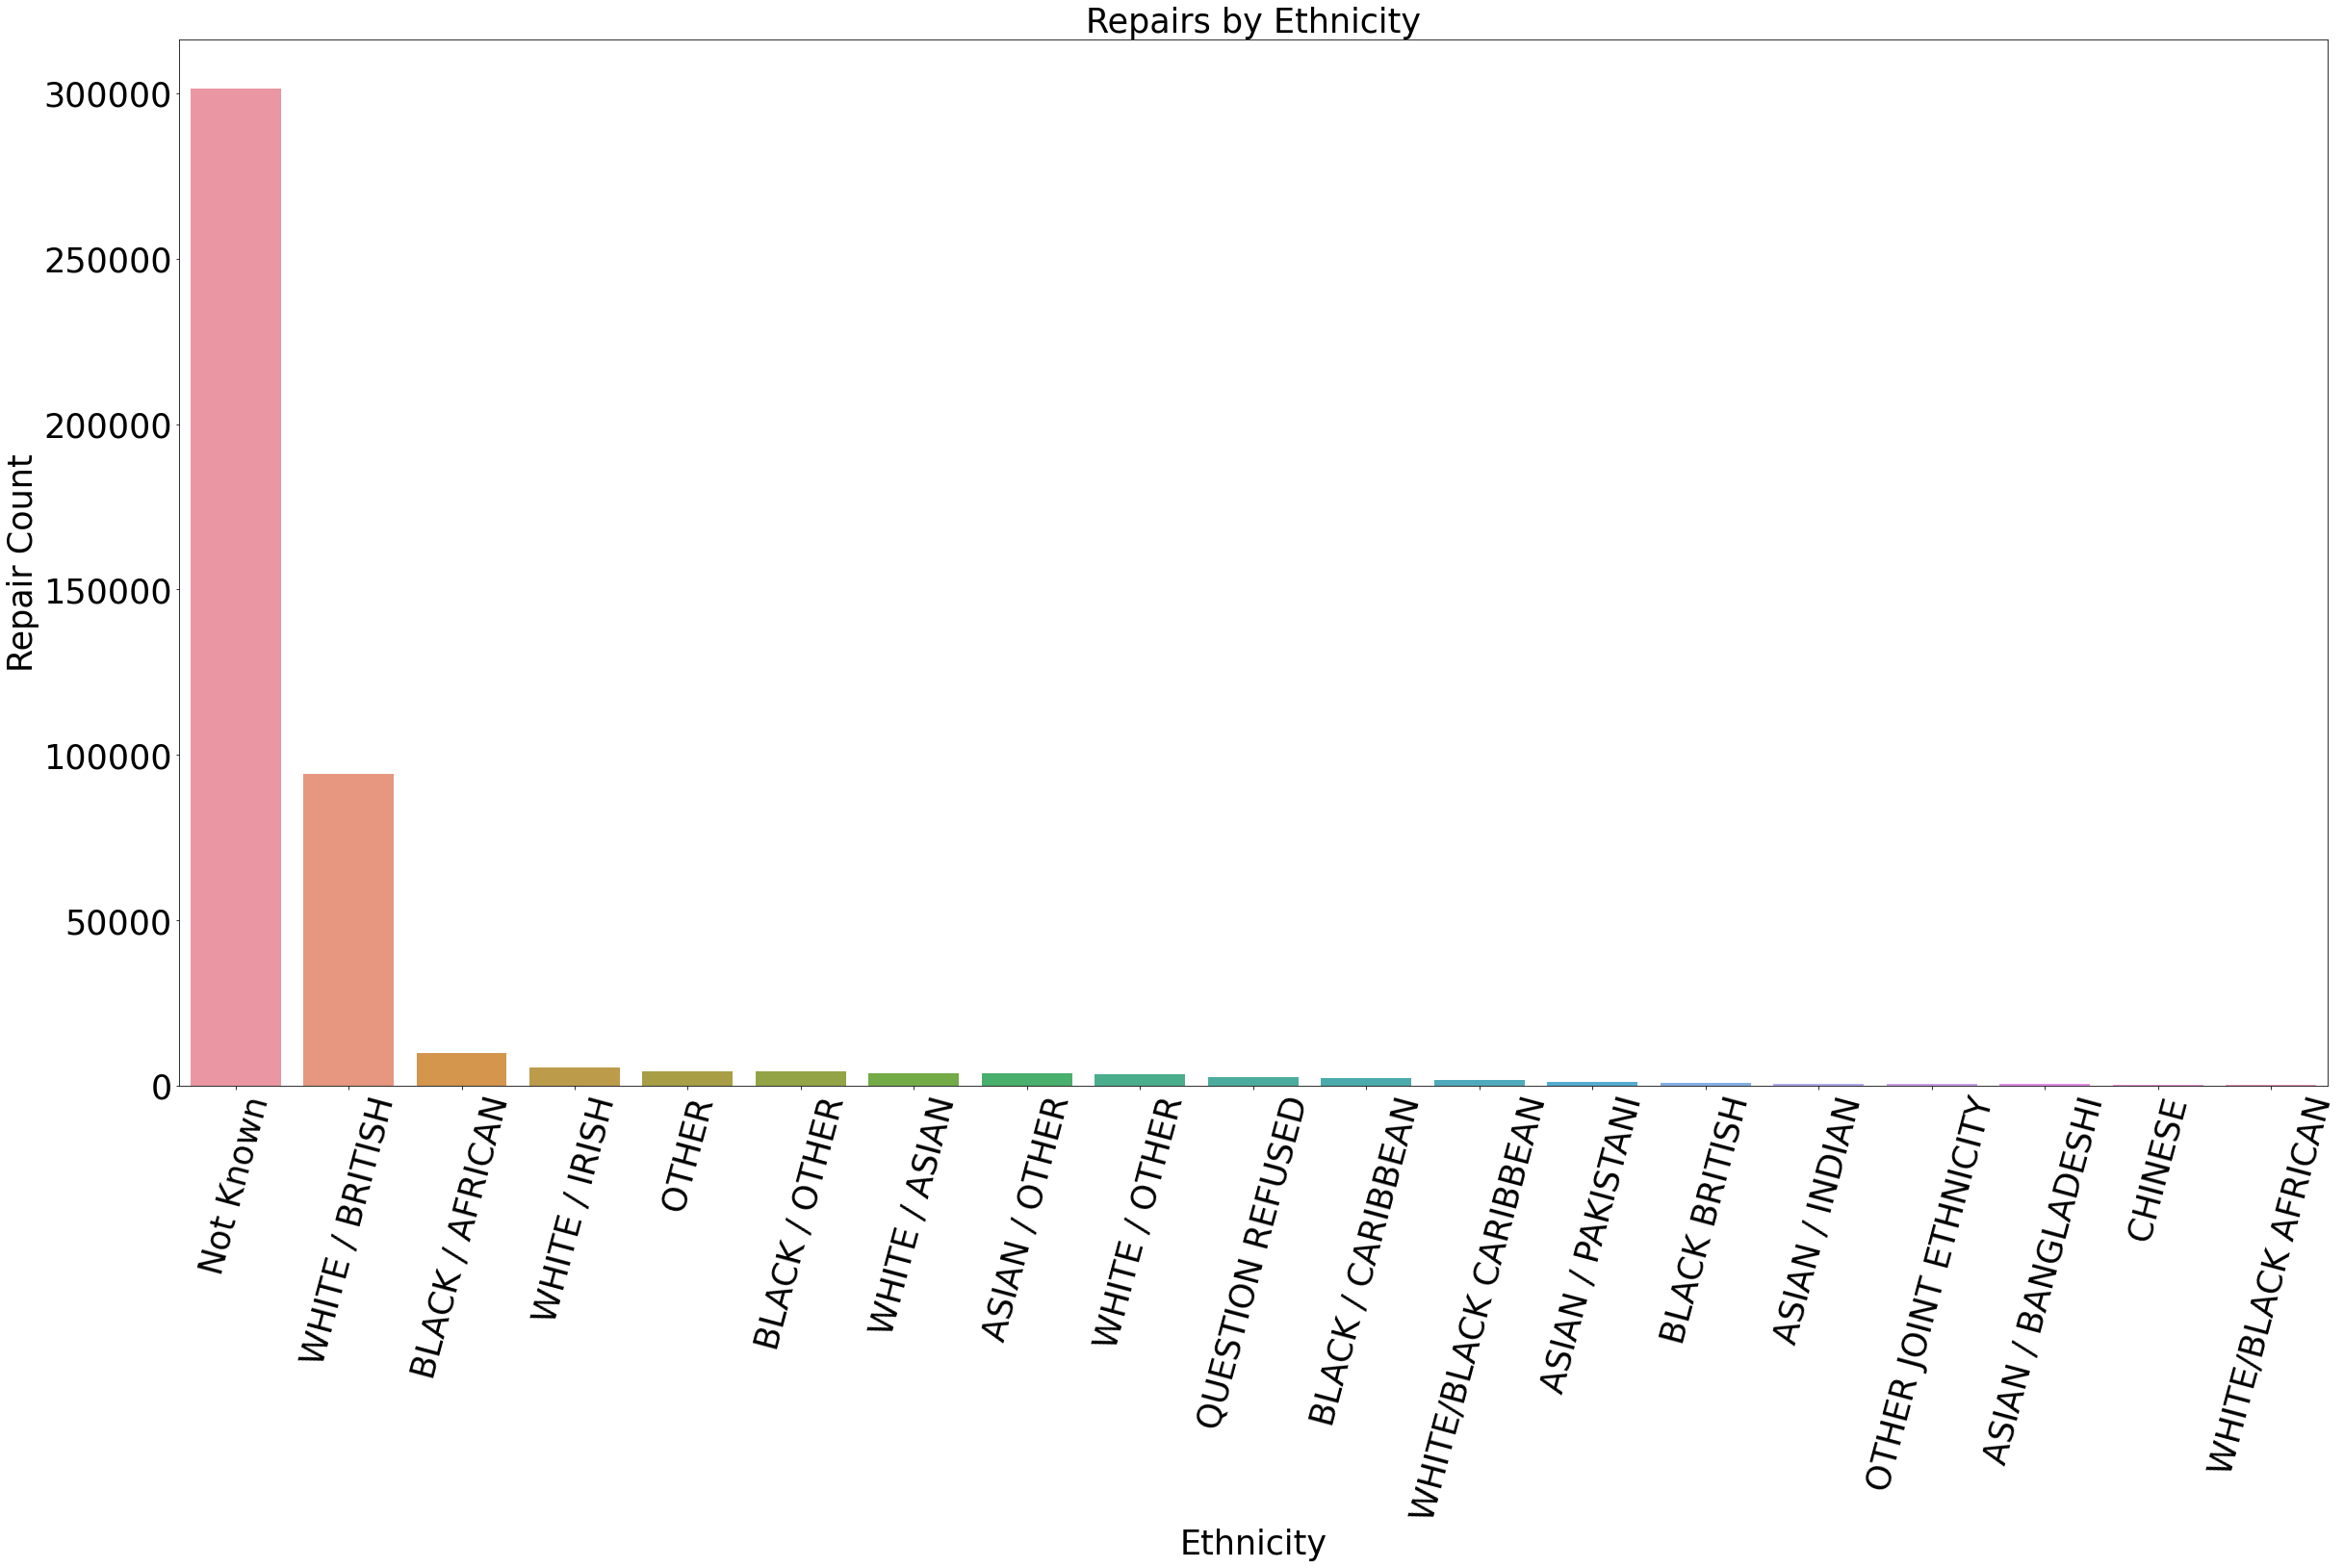

In [58]:
print(filtered_job_tenancy_person_prop['eth-cde'])

# changing instances of 's' to 'S' 
filtered_job_tenancy_person_prop['eth-cde'].fillna('NK', inplace=True)


ethnicity_map_dict = {
    'AB': 'BLACK / AFRICAN',
    'AM': 'WHITE/BLACK AFRICAN',
    'BA': 'ASIAN / BANGLADESHI',
    'BB': 'BLACK BRITISH',
    'CB': 'BLACK / CARIBBEAN',
    'CM': 'WHITE/BLACK CARIBBEAN',
    'EA': 'ASIAN / OTHER',
    'EB': 'BLACK / OTHER',
    'EW': 'WHITE / BRITISH',
    'IA': 'ASIAN / INDIAN',
    'IM': 'WHITE / ASIAN',
    'MM': 'OTHER JOINT ETHNICITY',
    'NK': 'Not Known',
    'OO': 'CHINESE',
    'OR': 'OTHER',
    'OW': 'WHITE / OTHER',
    'PA': 'ASIAN / PAKISTANI',
    'RZ': 'QUESTION REFUSED',
    'WW': 'WHITE / IRISH'
}

plt.figure(figsize = (40,20))
ax = sns.countplot(x='eth-cde', data=filtered_job_tenancy_person_prop, order = filtered_job_tenancy_person_prop['eth-cde'].value_counts().index)
plt.title('Repairs by Ethnicity', fontsize = 35)
ax.set_xticklabels([ethnicity_map_dict[label] for label in filtered_job_tenancy_person_prop['eth-cde'].unique()])
ax.tick_params(axis='x', labelsize=35)  
ax.tick_params(axis='y', labelsize=35) 
ax.set_xlabel('Ethnicity', fontsize=35)
ax.set_ylabel('Repair Count', fontsize=35)
plt.xticks(rotation = 75)

plt.show()

##### Ethnicity/marital status combined

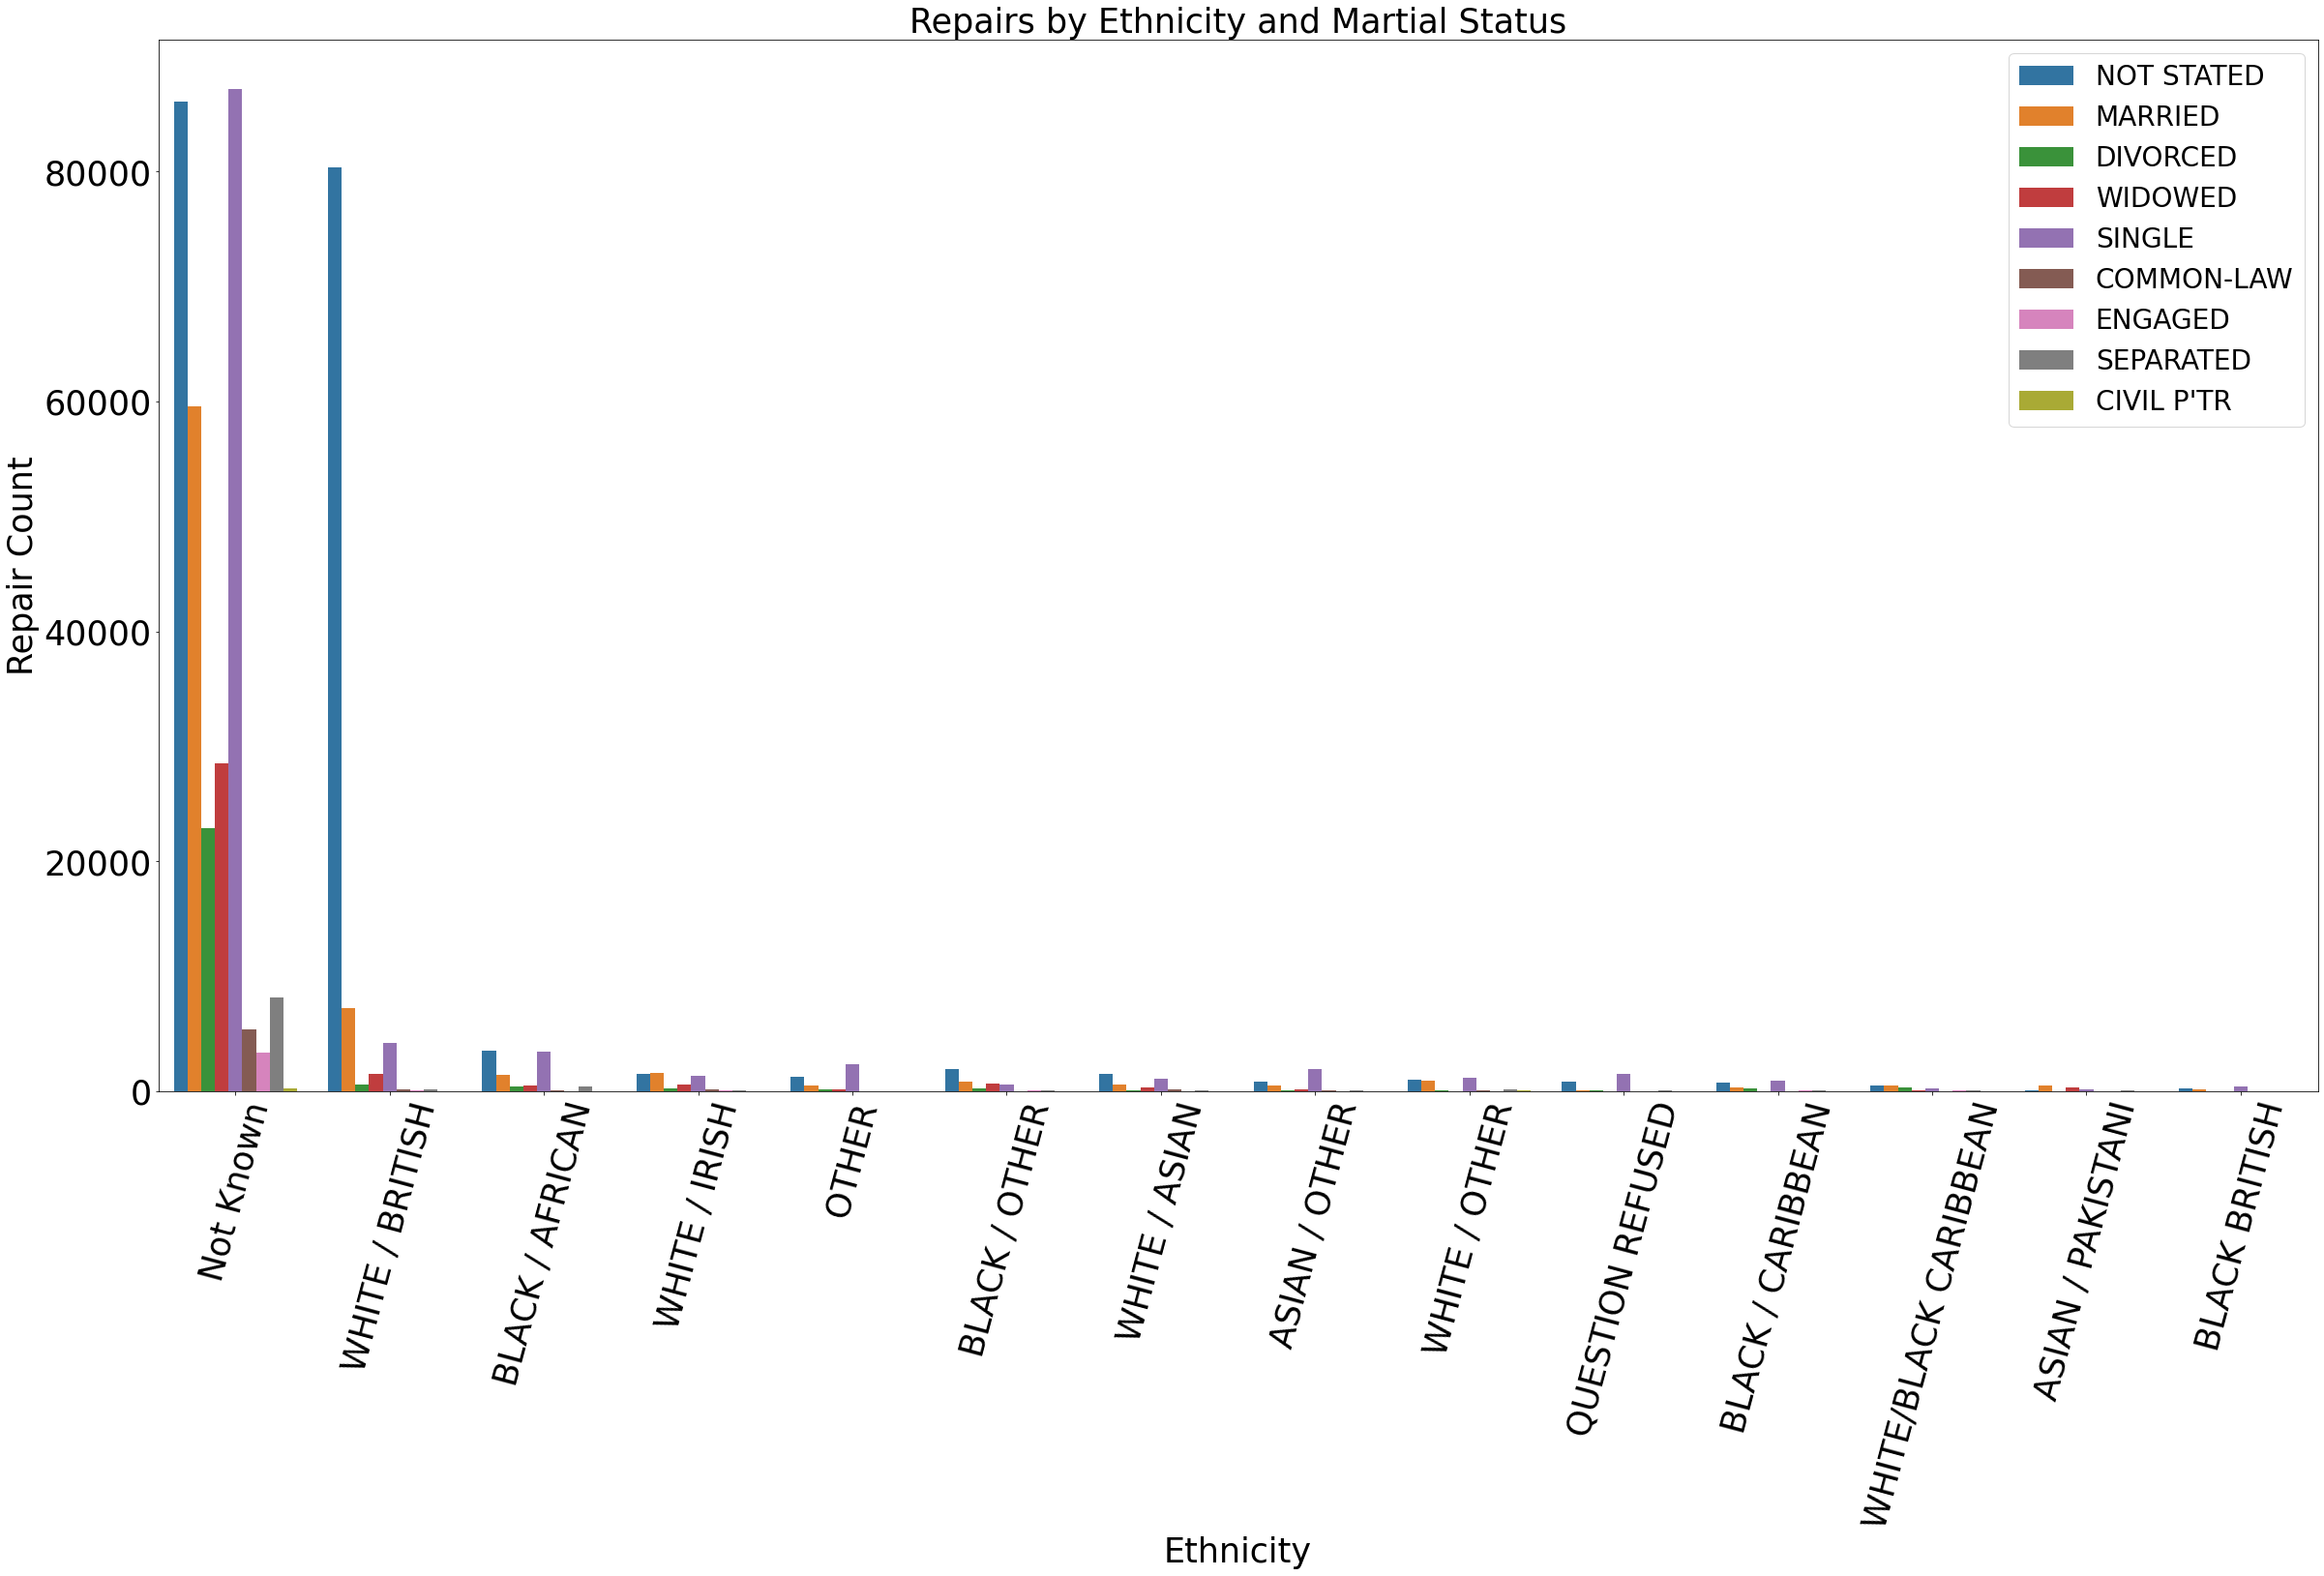

In [59]:
plt.figure(figsize = (40,20))

marital_status_map = {
    
    'A': 'SEPARATED',
    'C': 'CIVIL P\'TR',
    'D': 'DIVORCED',
    'E': 'ENGAGED',
    'L': 'COMMON-LAW',
    'M': 'MARRIED',
    'N': 'NOT STATED',
    'S': 'SINGLE',
    'W': 'WIDOWED'
}

ax = sns.countplot(x='eth-cde', data=filtered_job_tenancy_person_prop, order = filtered_job_tenancy_person_prop['eth-cde'].value_counts().index[:-5], hue = 'apermarsts-cde')
plt.title('Repairs by Ethnicity and Martial Status', fontsize = 35)
ax.set_xticklabels([ethnicity_map_dict[label] for label in filtered_job_tenancy_person_prop['eth-cde'].unique()[:-5]])
ax.tick_params(axis='x', labelsize=35)  
ax.tick_params(axis='y', labelsize=35) 
ax.set_xlabel('Ethnicity', fontsize=35)
ax.set_ylabel('Repair Count', fontsize=35)
plt.xticks(rotation = 75)
plt.legend(loc = 'upper right', fontsize = 32)

legend_labels = [marital_status_map[label] for label in filtered_job_tenancy_person_prop['apermarsts-cde'].unique()]
ax.legend(labels=legend_labels, loc='upper right', fontsize=28)

plt.show()

### Identifying high and low repair demand properties

In [60]:
repair_count_by_prop = pd.DataFrame(job_prop.groupby('pr-seq-no').size(), columns = ['repair_count'])
repair_count_by_prop.reset_index()
repair_count_by_prop.describe()

repair_count
count   7990.000000
mean     103.763329
std      116.031963
min        1.000000
25%       15.000000
50%       99.000000
75%      158.000000
max     3081.000000

###### 1.5*IQR+Q3:

In [61]:
1.5*(repair_count_by_prop.describe().iloc[6]-repair_count_by_prop.describe().iloc[4]) + repair_count_by_prop.describe().iloc[6]

repair_count    372.5
dtype: float64

#### High demand properties



In [62]:
len(repair_count_by_prop[repair_count_by_prop['repair_count']>372.5])

98

In [63]:
# gettting index of properties with total repari count greater than 1.5*IQR + Q3 value
high_demand_properties_idx = list(repair_count_by_prop[repair_count_by_prop['repair_count']>372.5].index)
high_demand_properties = properties[properties['seq-no'].isin(high_demand_properties_idx)]

job_prop_with_repair_counts = job_prop.merge(repair_count_by_prop, how='left', left_on='pr-seq-no', right_on='pr-seq-no')
high_demand_properties_all_jobs = job_prop_with_repair_counts[job_prop_with_repair_counts['seq-no'].isin(high_demand_properties_idx)]

##### Construction Year

C:\Users\adeel\AppData\Local\Temp/ipykernel_27108/2918723292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_demand_properties.loc[:, 'construction-yr'] = high_demand_properties['construction-yr'].astype(int).astype(str)


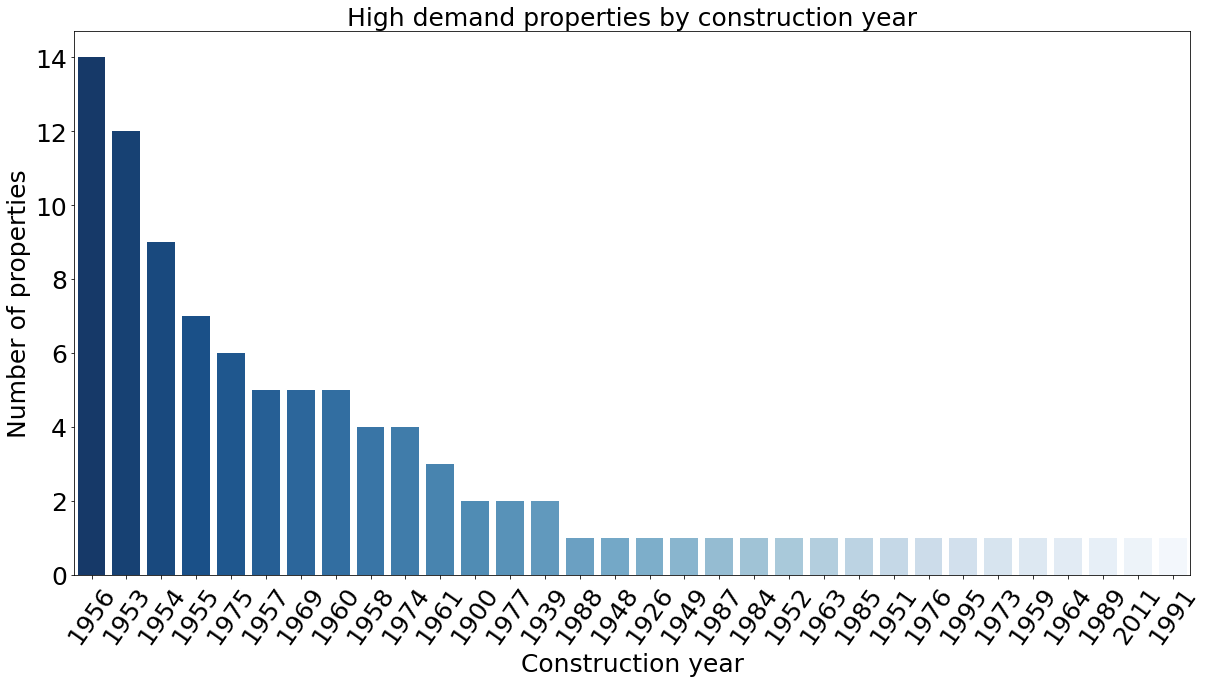

In [64]:
plt.figure(figsize = (20,10))
high_demand_properties.loc[:, 'construction-yr'] = high_demand_properties['construction-yr'].astype(int).astype(str)

ax = sns.countplot(data = high_demand_properties, x = 'construction-yr', order = high_demand_properties['construction-yr'].value_counts().index, palette = 'Blues_r')
plt.title('High demand properties by construction year', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Construction year', fontsize=25)
ax.set_ylabel('Number of properties', fontsize=25)
plt.xticks(rotation=55)

plt.show()

###### Location
More than one-third of these high demand properties are located in Matson which is understandable as 20% of all properties owned by GCH are located in Matson. Matson, with its 41 identified high demand properties, contributes to the majority of recorded ‘high demand repairs’. However, locations such as Robinswood, Abbeydale, and Kingsholm contribute significantly to the repair demand despite the lower number of properties in the areas. With a single high demand property identified in Robinswood and Abbeydale, the repair demand averages to 2194 and 2086 respectively.

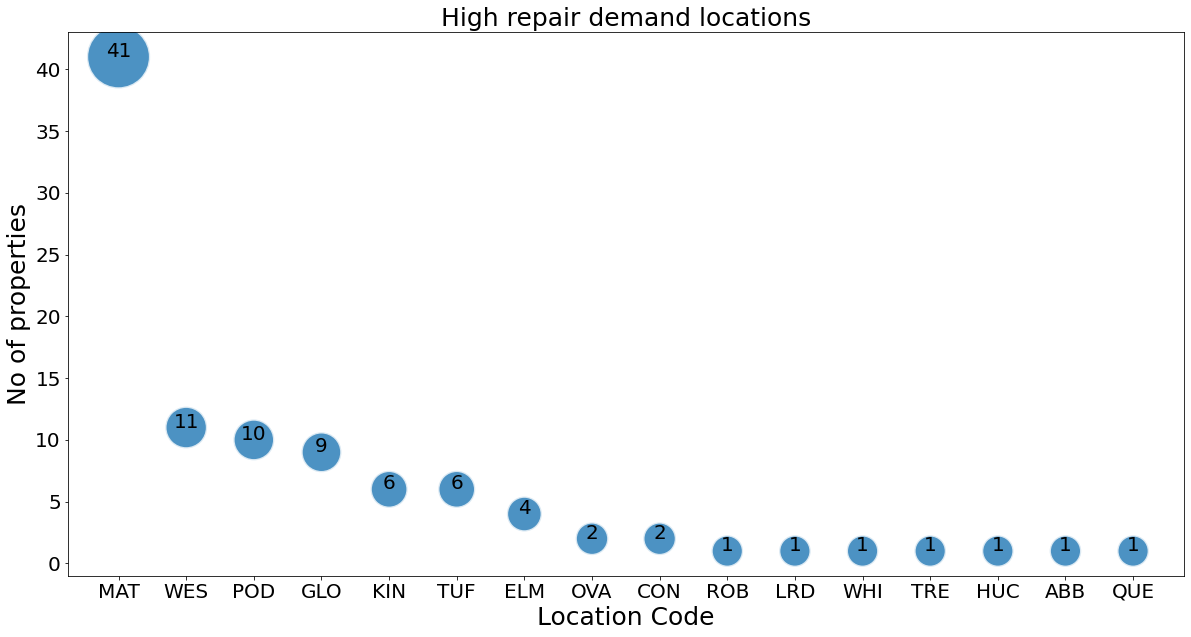

In [65]:

high_count_locs = high_demand_properties['location_code'].value_counts().reset_index()
high_count_locs.columns = ['location_code', 'count']

high_count_locs = high_count_locs.sort_values(by='count', ascending=False)

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=high_count_locs, x='location_code', y='count', size='count', sizes=(1000, 4000), alpha = 0.8)
plt.title('High repair demand locations', fontsize=25)
plt.xlabel('Location Code', fontsize=25)
plt.ylabel('No of properties', fontsize=25)

for line in range(0, high_count_locs.shape[0]):
    ax.text(high_count_locs['location_code'].iloc[line], high_count_locs['count'].iloc[line],
            high_count_locs['count'].iloc[line], horizontalalignment='center', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend().set_visible(False)

plt.grid(False)
plt.show()

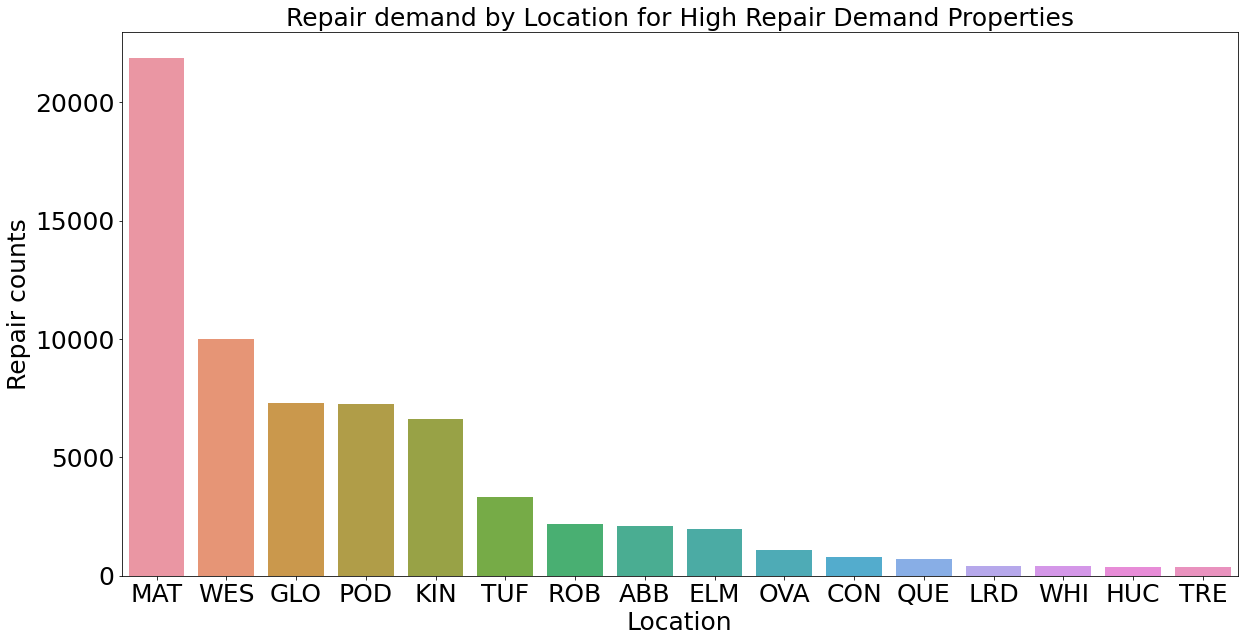

In [66]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = high_demand_properties_all_jobs, x = 'location_code', order = high_demand_properties_all_jobs['location_code'].value_counts().index)
plt.title('Repair demand by Location for High Repair Demand Properties', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Location', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.grid(False)
plt.show()

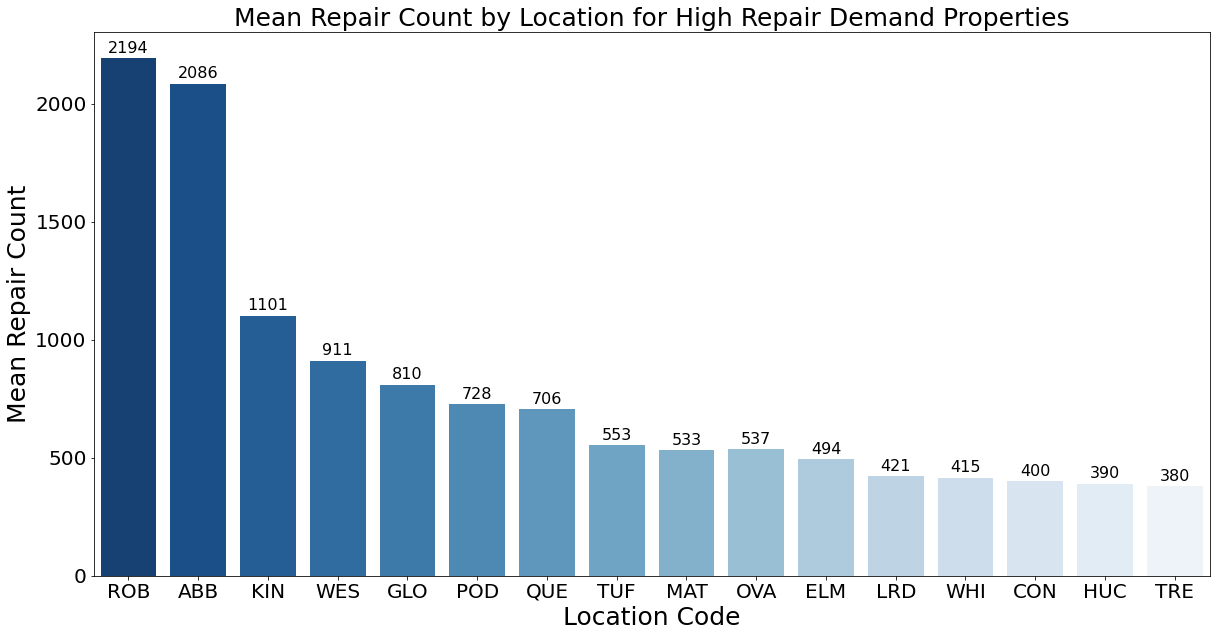

In [67]:
high_demand_repair_loc = pd.DataFrame(high_demand_properties_all_jobs.groupby('location_code')['repair_count'].size().sort_values(ascending = False))
high_demand_repair_loc = high_demand_repair_loc.reset_index()
high_demand_loc_merge = high_demand_repair_loc.merge(high_count_locs, on = 'location_code', how = 'inner')
high_demand_loc_merge['mean_repair_count'] = high_demand_loc_merge['repair_count']/high_demand_loc_merge['count']
high_demand_loc_merge['mean_repair_count'] = high_demand_loc_merge['mean_repair_count'].round().astype(int)
mean_repair_count_high_loc = high_demand_properties_all_jobs.groupby('location_code')['repair_count'].mean().reset_index()

mean_repair_count_high_loc = mean_repair_count_high_loc.sort_values(by='repair_count', ascending=False)

plt.figure(figsize=(20, 10))
ax = sns.barplot(data=high_demand_loc_merge, x='location_code', y='mean_repair_count', order=mean_repair_count_high_loc['location_code'], palette = 'Blues_r')
plt.title('Mean Repair Count by Location for High Repair Demand Properties', fontsize=25)
plt.xlabel('Location Code', fontsize=25)
plt.ylabel('Mean Repair Count', fontsize=25)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=16, color='black', xytext=(0, 10), textcoords='offset points')

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.grid(False)
plt.show()


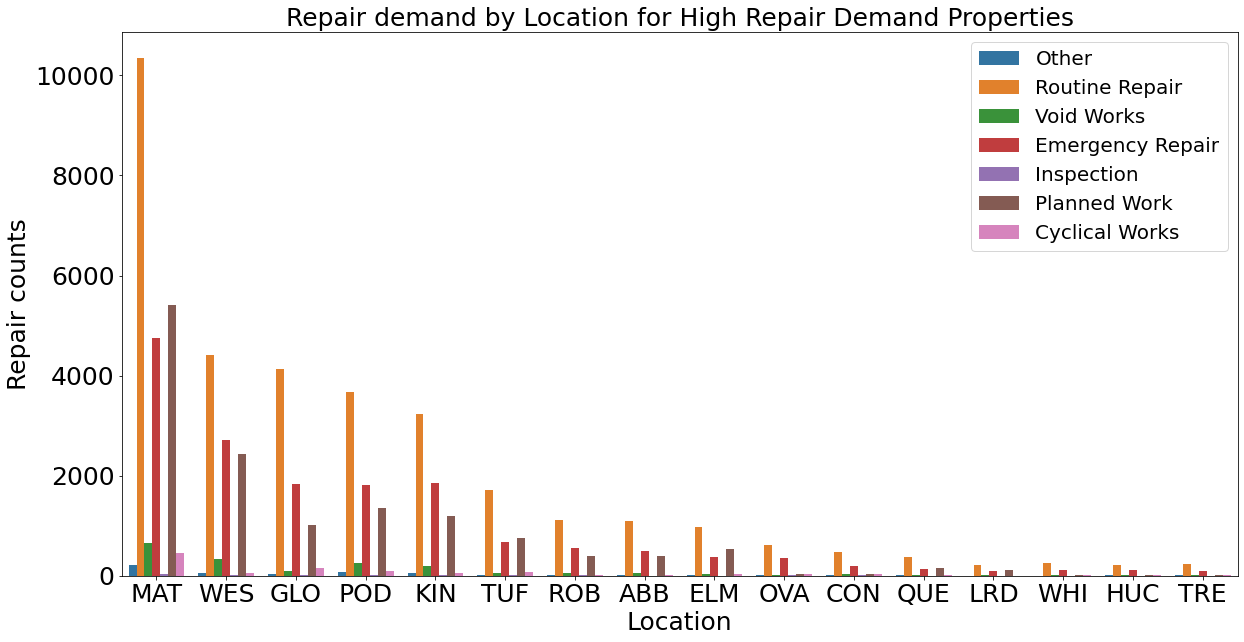

In [68]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = high_demand_properties_all_jobs, x = 'location_code', order = high_demand_properties_all_jobs['location_code'].value_counts().index, hue = 'priority')
plt.title('Repair demand by Location for High Repair Demand Properties', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Location', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.grid(False)
plt.legend(loc = 'upper right', fontsize = 20)
plt.show()

###### highest demand properties by property class

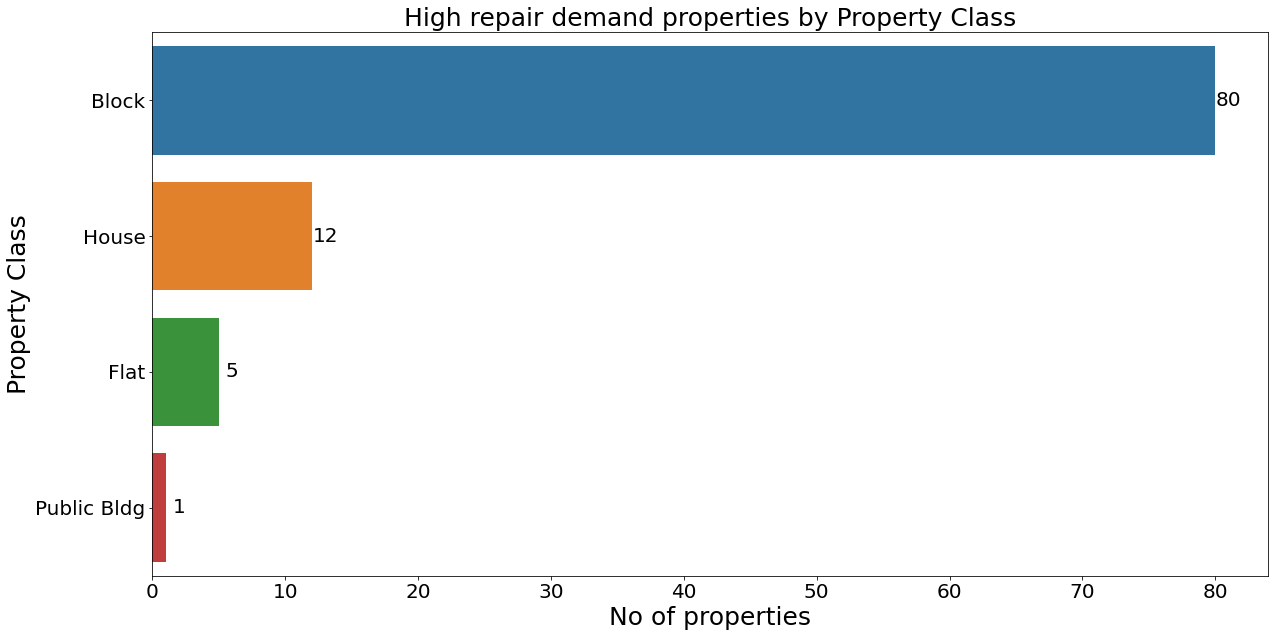

In [69]:
high_count_classes = high_demand_properties['property_class'].value_counts().reset_index()
high_count_classes.columns = ['property_class', 'count']

high_count_classes = high_count_classes.sort_values(by='count', ascending=False)

plt.figure(figsize=(20, 10))
ax = sns.barplot(data=high_count_classes, y='property_class', x='count', orient = 'h')
plt.title('High repair demand properties by Property Class', fontsize=25)

plt.xlabel('No of properties', fontsize=25)
plt.ylabel('Property Class', fontsize=25)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

for p in ax.patches:
    ax.annotate(str(int(p.get_width())), (p.get_width() + 1, p.get_y() + p.get_height() / 2), fontsize=20, color='black', ha='center', va='center')

plt.show()

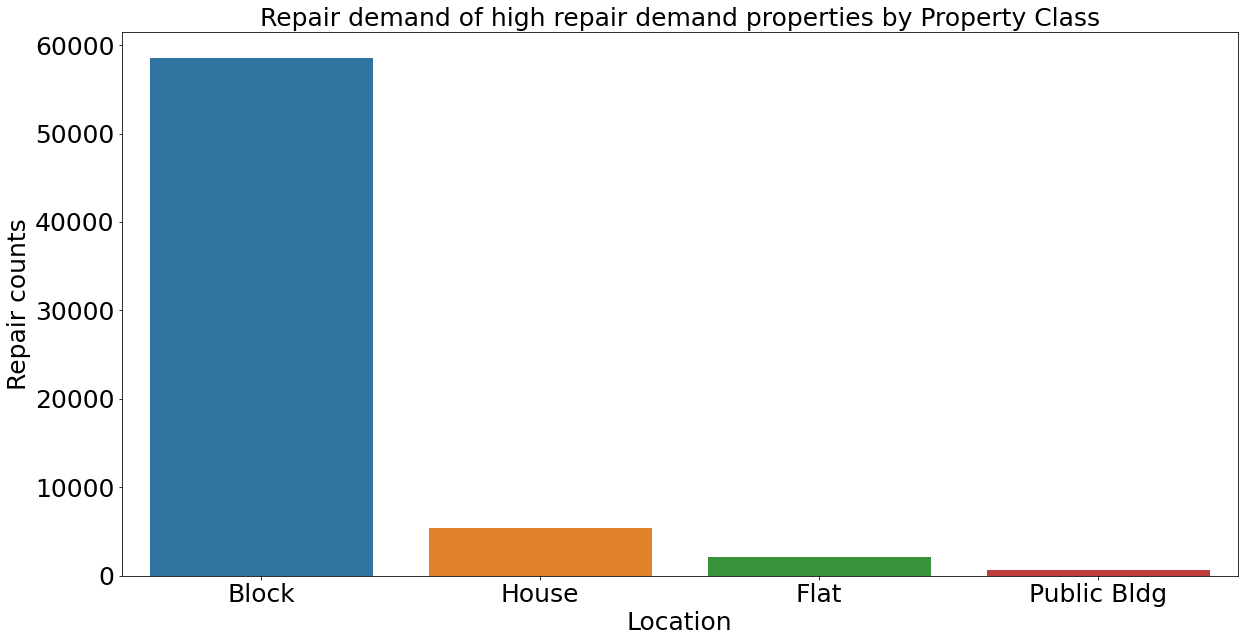

In [70]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = high_demand_properties_all_jobs, x = 'property_class', order = high_demand_properties_all_jobs['property_class'].value_counts().index)
plt.title('Repair demand of high repair demand properties by Property Class', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Location', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.show()

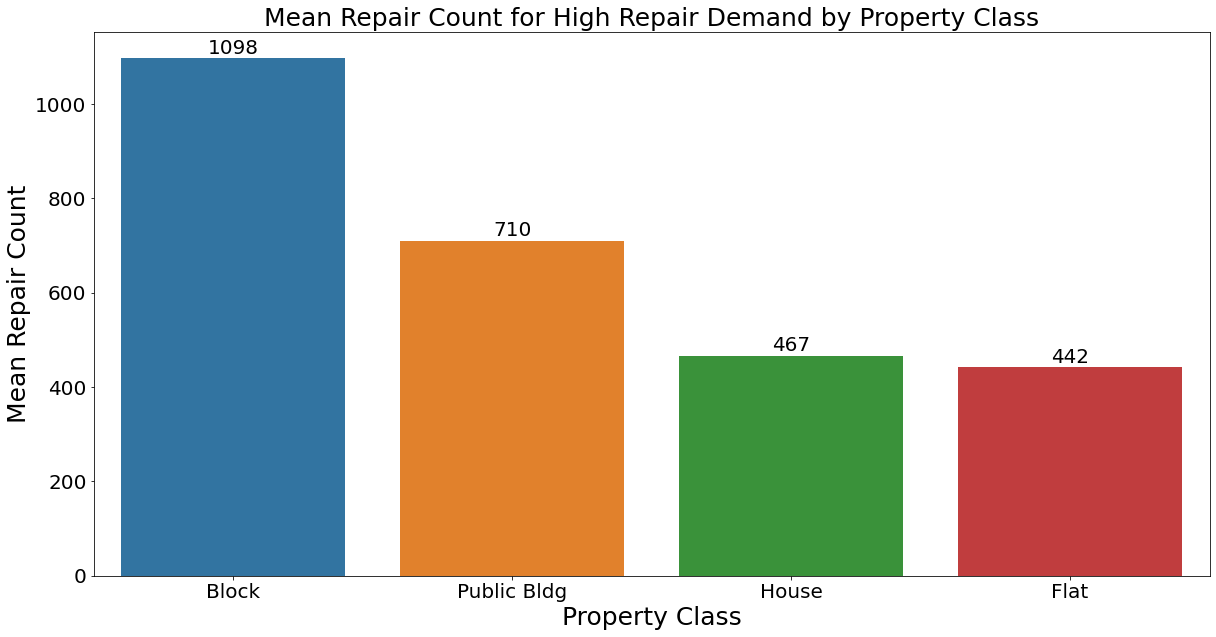

In [71]:
mean_repair_count_high_prop_class = high_demand_properties_all_jobs.groupby('property_class')['repair_count'].mean().reset_index()

mean_repair_count_high_prop_class = mean_repair_count_high_prop_class.sort_values(by='repair_count', ascending=False)

plt.figure(figsize=(20, 10))
ax = sns.barplot(data=mean_repair_count_high_prop_class, x='property_class', y='repair_count', order=mean_repair_count_high_prop_class['property_class'])
plt.title('Mean Repair Count for High Repair Demand by Property Class', fontsize=25)
plt.xlabel('Property Class', fontsize=25)
plt.ylabel('Mean Repair Count', fontsize=25)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=20, color='black', xytext=(0, 10), textcoords='offset points')

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.show()

##### Repair counts of high demand properties by property style

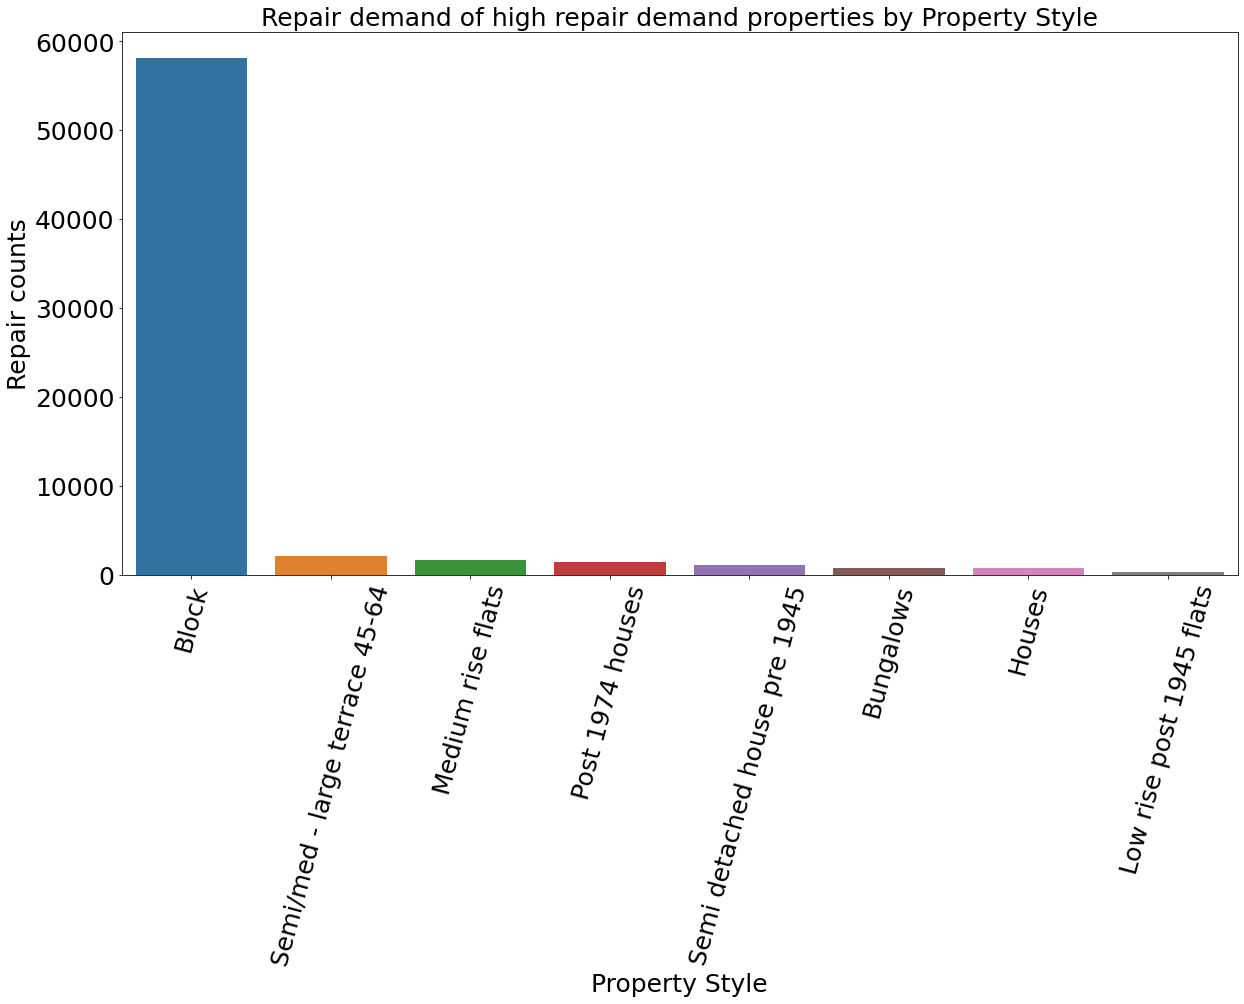

In [72]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = high_demand_properties_all_jobs, x = 'property_style', order = high_demand_properties_all_jobs['property_style'].value_counts().index)
plt.title('Repair demand of high repair demand properties by Property Style', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Property Style', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.xticks(rotation = 75)
plt.show()

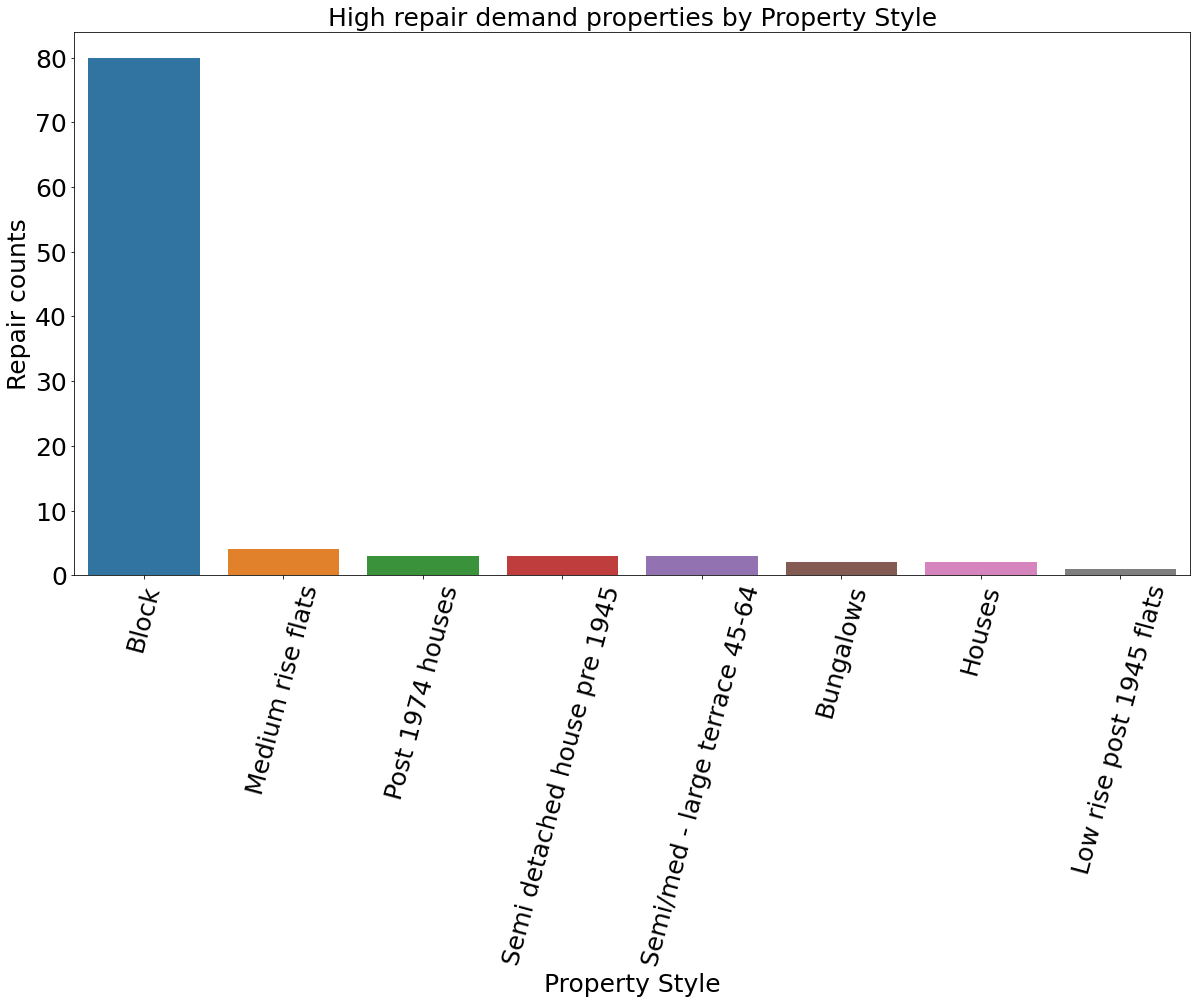

In [73]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = high_demand_properties, x = 'property_style', order = high_demand_properties['property_style'].value_counts().index)
plt.title('High repair demand properties by Property Style', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Property Style', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.xticks(rotation = 75)
plt.show()

##### Repair demand of high repair demand by Priority Type

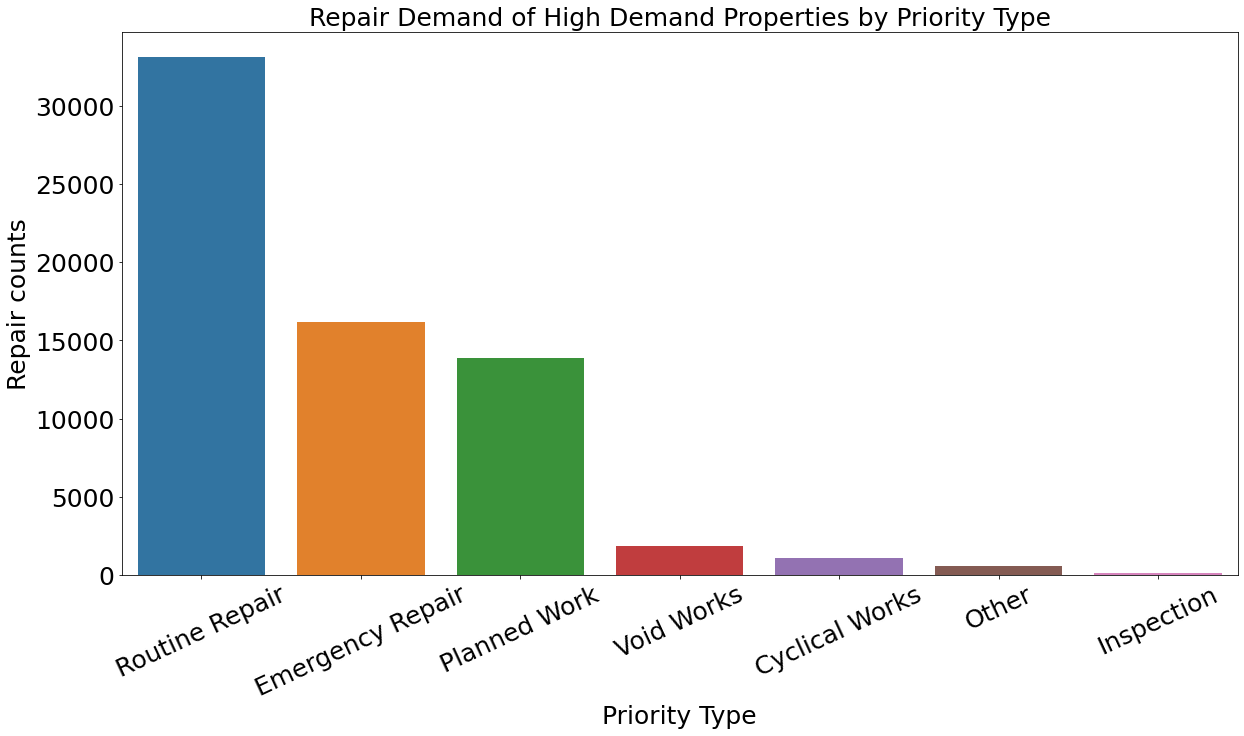

In [74]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = high_demand_properties_all_jobs, x = 'priority', order = high_demand_properties_all_jobs['priority'].value_counts().index)
plt.title('Repair Demand of High Demand Properties by Priority Type', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Priority Type', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.xticks(rotation = 25)
plt.grid(False)
plt.show()

In [75]:
# plt.figure(figsize = (20,10))
# ax = sns.countplot(data = high_demand_properties_all_jobs, x = 'sor', order = high_demand_properties_all_jobs['sor'].value_counts().index)
# plt.title('Repair demand of high repair demand by Trade Type', fontsize = 25)
# ax.tick_params(axis='x', labelsize=20)  
# ax.tick_params(axis='y', labelsize=25) 
# ax.set_xlabel('Trade Type', fontsize=25)
# ax.set_ylabel('Repair counts', fontsize=25)
# plt.xticks(rotation = 75)
# plt.show()

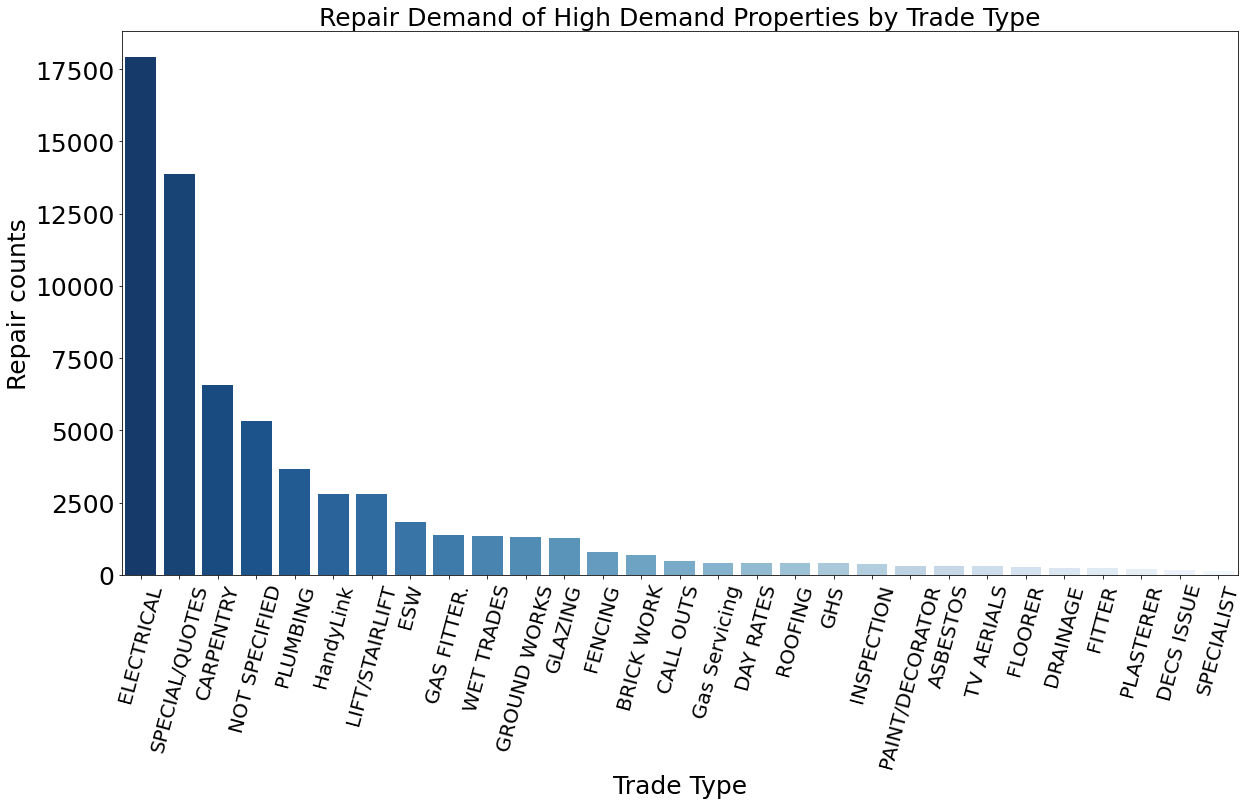

In [76]:
# Filtering out trade types whose value_counts are less than 100
# Plotting the rest
trade_value_counts_high = high_demand_properties_all_jobs['sor'].value_counts()
trade_value_counts_high = trade_value_counts_high[trade_value_counts_high > 100].index

filtered_high_demand_trade = high_demand_properties_all_jobs[high_demand_properties_all_jobs['sor'].isin(trade_value_counts_high)]

plt.figure(figsize=(20, 10))
ax = sns.countplot(data=filtered_high_demand_trade, x='sor', order=filtered_high_demand_trade['sor'].value_counts().index, palette = 'Blues_r')
plt.title('Repair Demand of High Demand Properties by Trade Type', fontsize = 25)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Trade Type', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.xticks(rotation = 75)
plt.show()

#### Lowest demand properties

In [77]:
len(repair_count_by_prop[repair_count_by_prop['repair_count']<15])

1995

In [78]:
# gettting index of properties with total repari counts less than 25% quartile value
low_demand_properties_idx = list(repair_count_by_prop[repair_count_by_prop['repair_count']<15].index)
low_demand_properties = properties[properties['seq-no'].isin(low_demand_properties_idx)]

job_prop_with_repair_counts = job_prop.merge(repair_count_by_prop, how='left', left_on='pr-seq-no', right_on='pr-seq-no')
low_demand_properties_all_jobs = job_prop_with_repair_counts[job_prop_with_repair_counts['seq-no'].isin(low_demand_properties_idx)]

In [79]:
low_demand_cons_yr = pd.DataFrame(low_demand_properties['construction-yr'].value_counts())
low_demand_cons_yr = low_demand_cons_yr.reset_index() 
low_demand_cons_yr.columns = ['construction-yr','count']
low_demand_cons_yr = low_demand_cons_yr.drop(low_demand_cons_yr[low_demand_cons_yr['construction-yr']==0].index, axis = 0)
low_demand_cons_yr.loc[:, 'construction-yr'] = low_demand_cons_yr['construction-yr'].astype(int).astype(str)
low_demand_cons_yr = low_demand_cons_yr.drop(low_demand_cons_yr[low_demand_cons_yr['count']<5].index, axis =0)

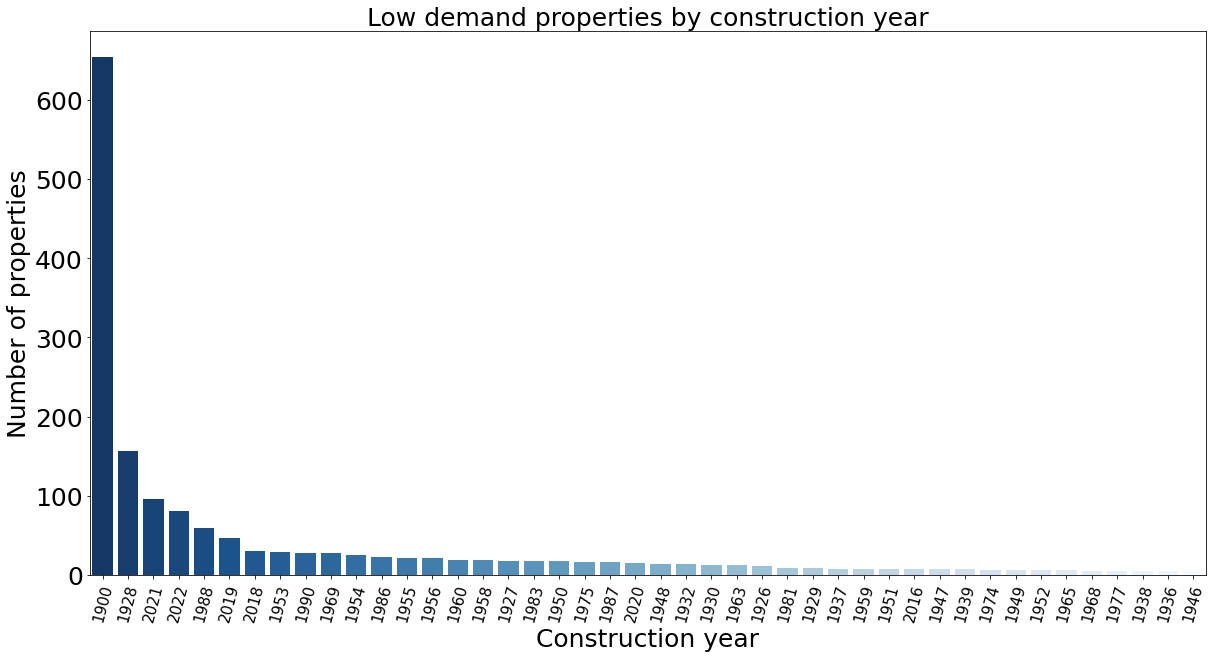

In [80]:
plt.figure(figsize = (20,10))
ax = sns.barplot(data = low_demand_cons_yr, x = 'construction-yr', y = 'count', palette = 'Blues_r')#, order = low_demand_cons_yr['construction-yr'].value_counts().index)
plt.title('Low demand properties by construction year', fontsize = 25)
ax.tick_params(axis='x', labelsize=15)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Construction year', fontsize=25)
ax.set_ylabel('Number of properties', fontsize=25)
plt.xticks(rotation = 75)
plt.show()

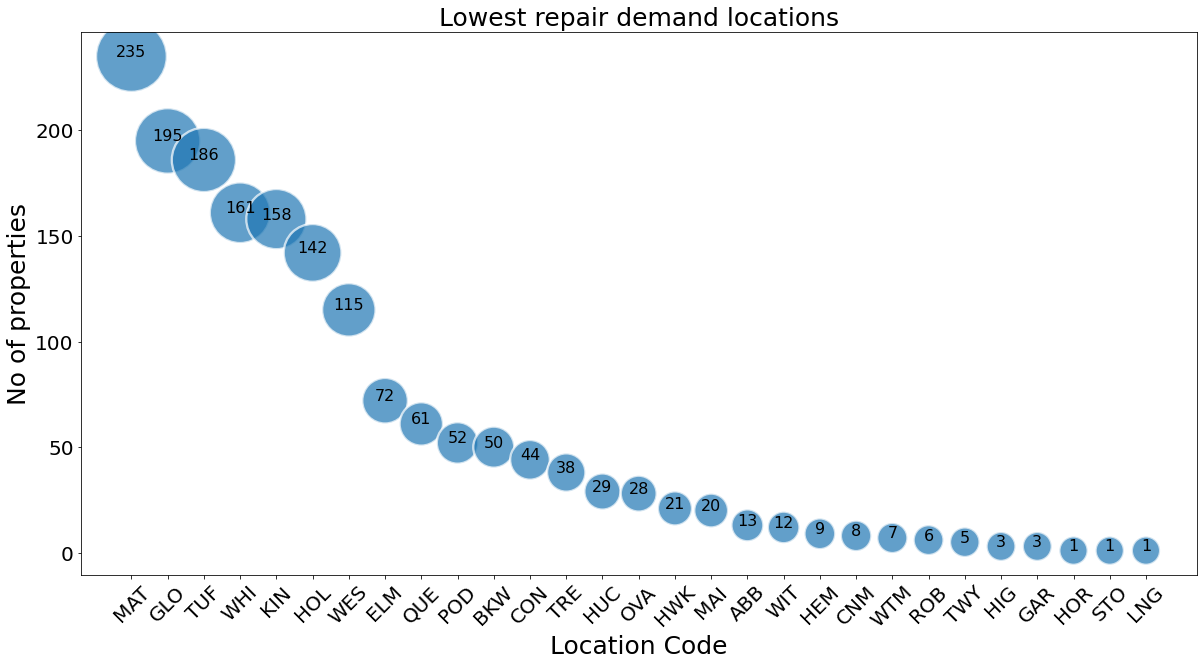

In [81]:
low_count_locs = low_demand_properties['location_code'].value_counts().reset_index()
low_count_locs.columns = ['location_code', 'count']

low_count_locs = low_count_locs.sort_values(by='count', ascending=False)

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=low_count_locs, x='location_code', y='count', size='count', sizes=(800, 5000), alpha = 0.7)
plt.title('Lowest repair demand locations', fontsize=25)
plt.xlabel('Location Code', fontsize=25)
plt.ylabel('No of properties', fontsize=25)

for line in range(0, low_count_locs.shape[0]):
    ax.text(low_count_locs['location_code'].iloc[line], low_count_locs['count'].iloc[line],
            low_count_locs['count'].iloc[line], horizontalalignment='center', fontsize=16)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend().set_visible(False)
plt.xticks(rotation = 45)
plt.show()

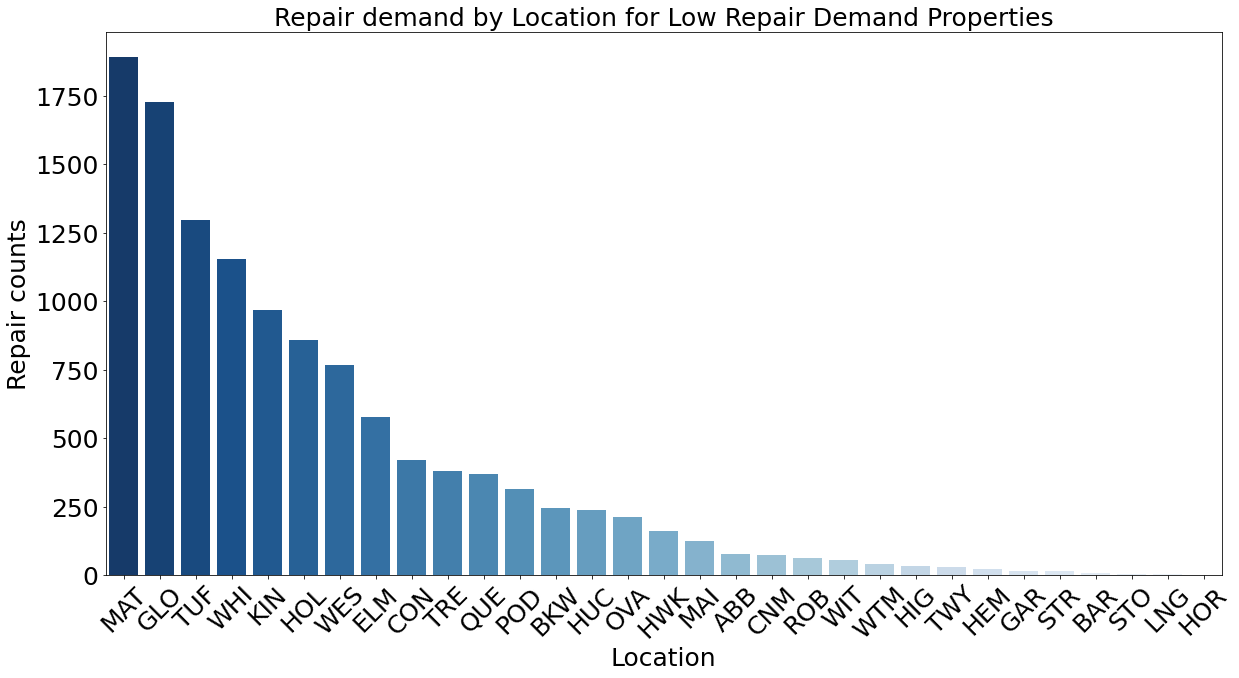

In [82]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = low_demand_properties_all_jobs, x = 'location_code', order = low_demand_properties_all_jobs['location_code'].value_counts().index, palette = 'Blues_r')
plt.title('Repair demand by Location for Low Repair Demand Properties', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Location', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.xticks(rotation = 45)
plt.grid(False)
plt.show()

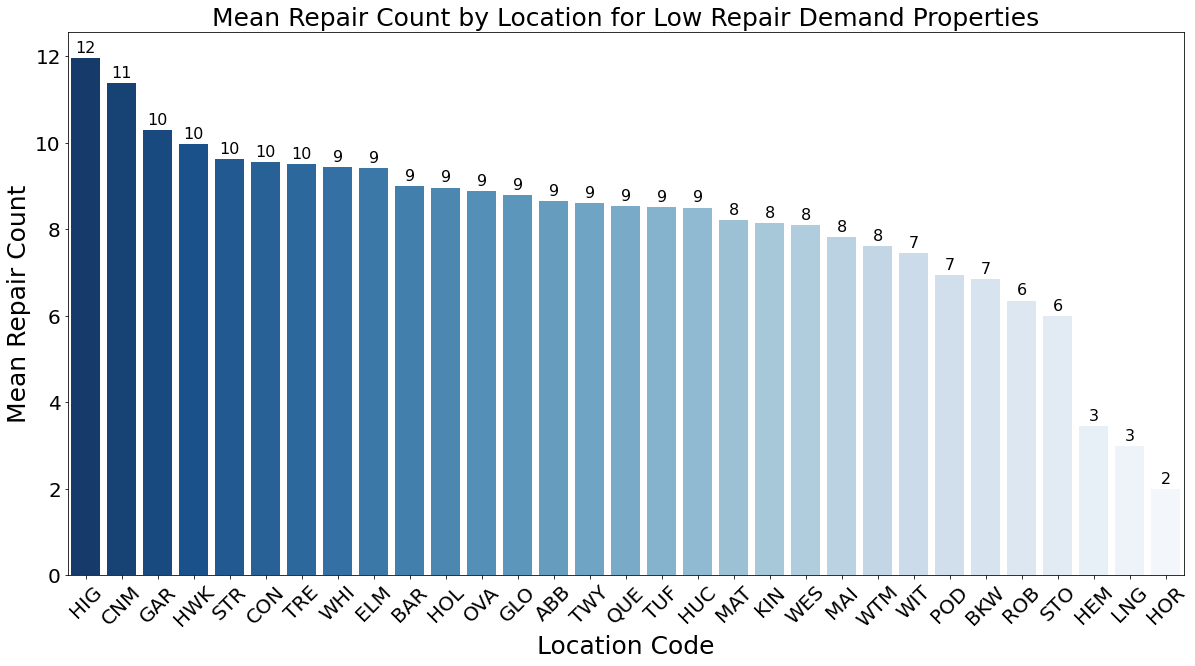

In [83]:
mean_repair_count_low_loc = low_demand_properties_all_jobs.groupby('location_code')['repair_count'].mean().reset_index()

mean_repair_count_low_loc = mean_repair_count_low_loc.sort_values(by='repair_count', ascending=False)

plt.figure(figsize=(20, 10))
ax = sns.barplot(data=mean_repair_count_low_loc, x='location_code', y='repair_count', order=mean_repair_count_low_loc['location_code'],palette = 'Blues_r')
plt.title('Mean Repair Count by Location for Low Repair Demand Properties', fontsize=25)
plt.xlabel('Location Code', fontsize=25)
plt.ylabel('Mean Repair Count', fontsize=25)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=16, color='black', xytext=(0, 10), textcoords='offset points')

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.xticks(rotation = 45)
plt.grid(False)
plt.show()


###### lowest demand properties by property class

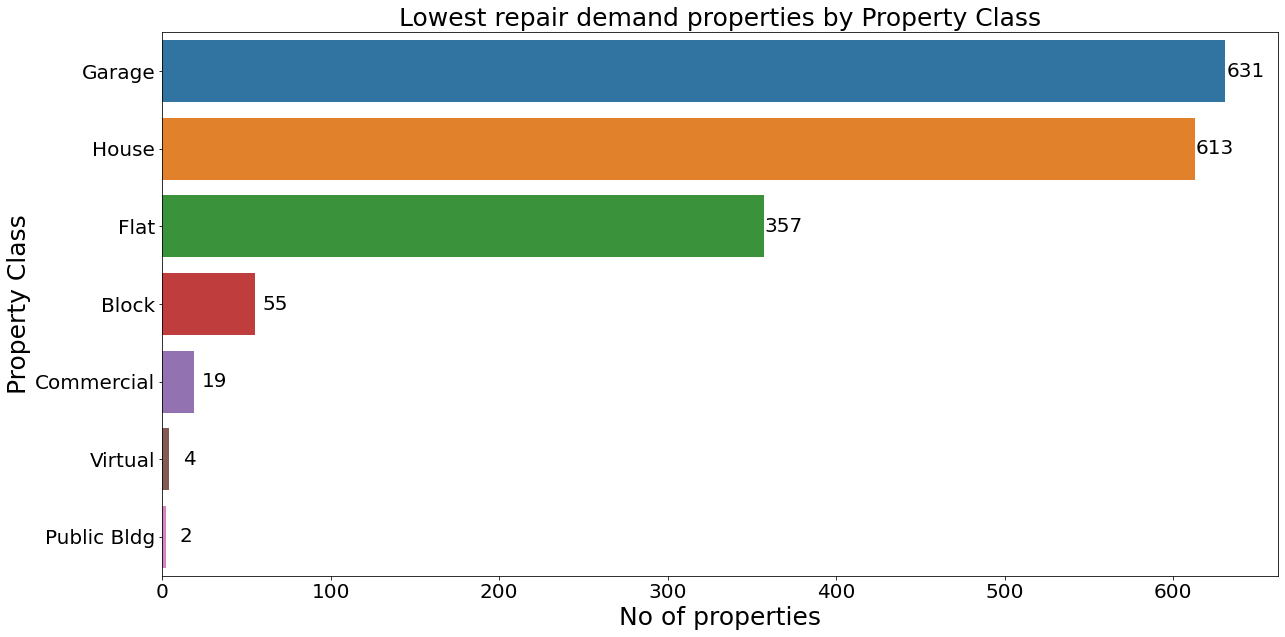

In [84]:
low_count_classes = low_demand_properties['property_class'].value_counts().reset_index()
low_count_classes.columns = ['property_class', 'count']

low_count_classes = low_count_classes.sort_values(by='count', ascending=False)

plt.figure(figsize=(20, 10))
ax = sns.barplot(data=low_count_classes, y='property_class', x='count', orient = 'h')
plt.title('Lowest repair demand properties by Property Class', fontsize=25)

plt.xlabel('No of properties', fontsize=25)
plt.ylabel('Property Class', fontsize=25)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

for p in ax.patches:
    ax.annotate(str(int(p.get_width())), (p.get_width() + 12, p.get_y() + p.get_height() / 2), fontsize=20, color='black', ha='center', va='center')

plt.show()

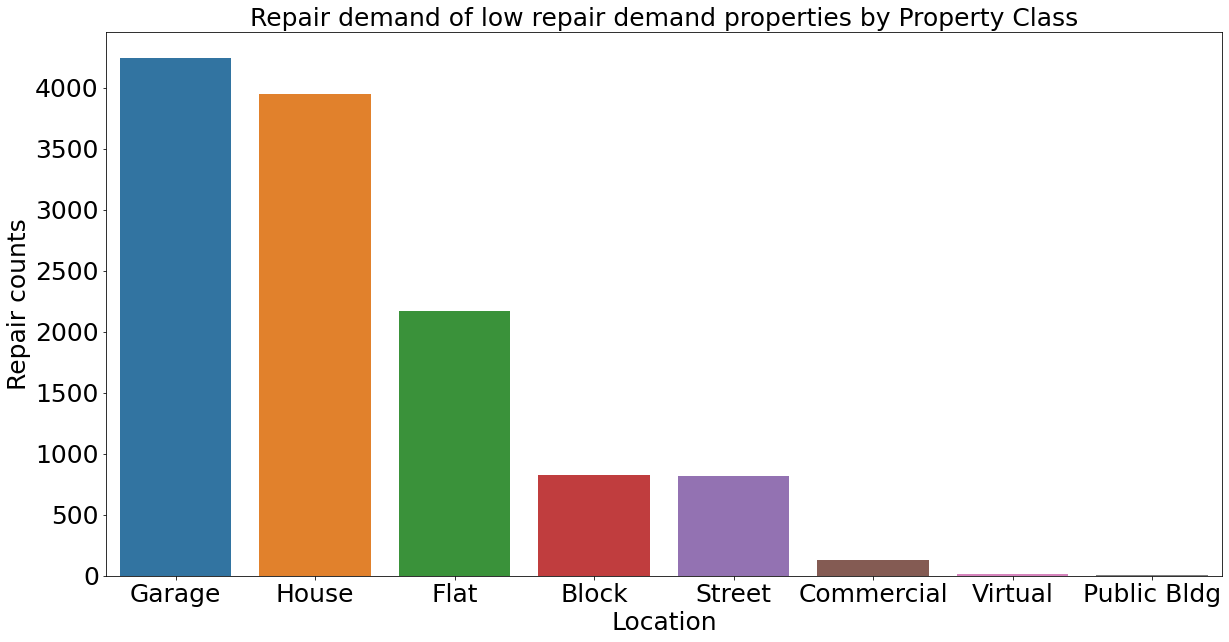

In [85]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = low_demand_properties_all_jobs, x = 'property_class', order = low_demand_properties_all_jobs['property_class'].value_counts().index)
plt.title('Repair demand of low repair demand properties by Property Class', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Location', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.show()

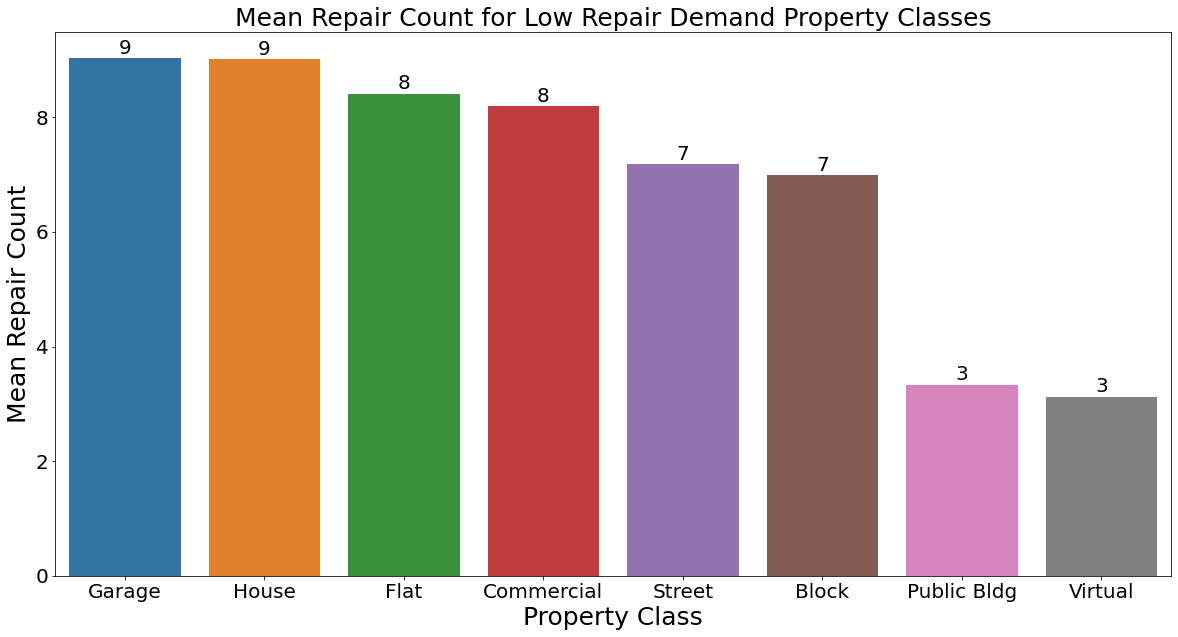

In [86]:
mean_repair_count_low_prop_class = low_demand_properties_all_jobs.groupby('property_class')['repair_count'].mean().reset_index()

mean_repair_count_low_prop_class = mean_repair_count_low_prop_class.sort_values(by='repair_count', ascending=False)

plt.figure(figsize=(20, 10))
ax = sns.barplot(data=mean_repair_count_low_prop_class, x='property_class', y='repair_count', order=mean_repair_count_low_prop_class['property_class'])
plt.title('Mean Repair Count for Low Repair Demand Property Classes', fontsize=25)
plt.xlabel('Property Class', fontsize=25)
plt.ylabel('Mean Repair Count', fontsize=25)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=20, color='black', xytext=(0, 10), textcoords='offset points')

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.show()

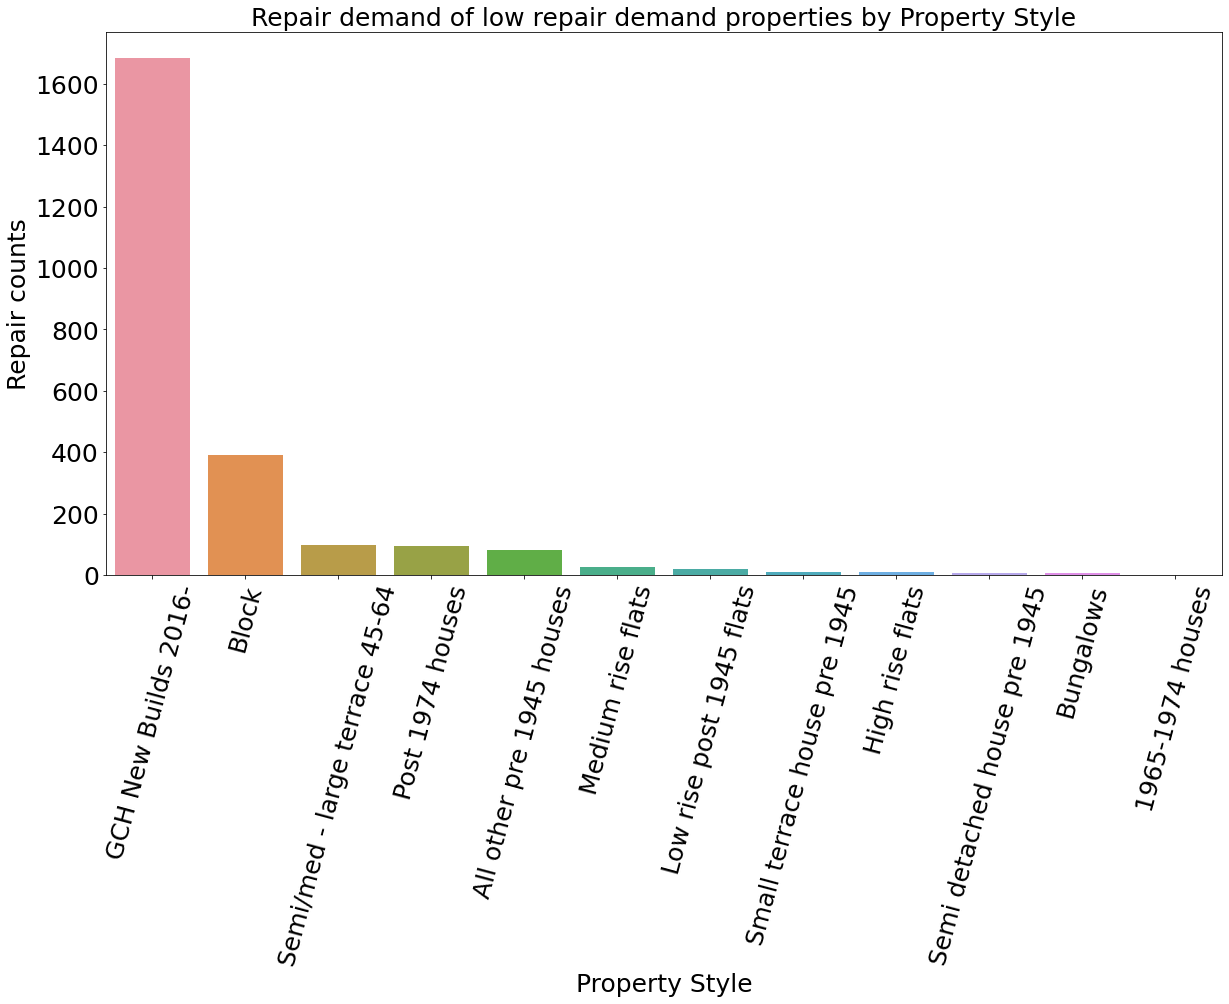

In [87]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = low_demand_properties_all_jobs, x = 'property_style', order = low_demand_properties_all_jobs['property_style'].value_counts().index)
plt.title('Repair demand of low repair demand properties by Property Style', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Property Style', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.xticks(rotation = 75)
plt.show()

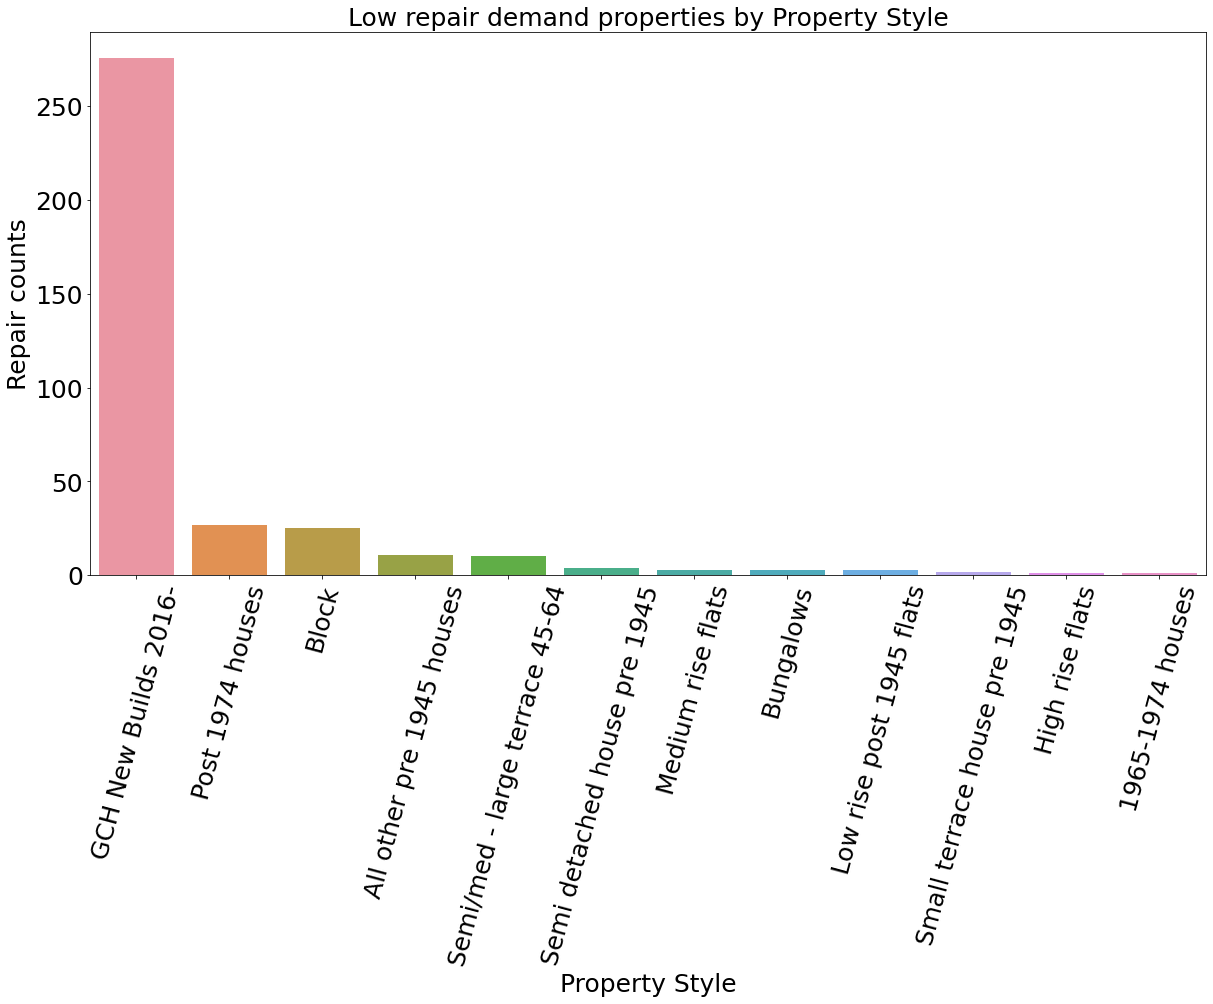

In [88]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = low_demand_properties, x = 'property_style', order = low_demand_properties['property_style'].value_counts().index)
plt.title('Low repair demand properties by Property Style', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Property Style', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.xticks(rotation = 75)
plt.show()

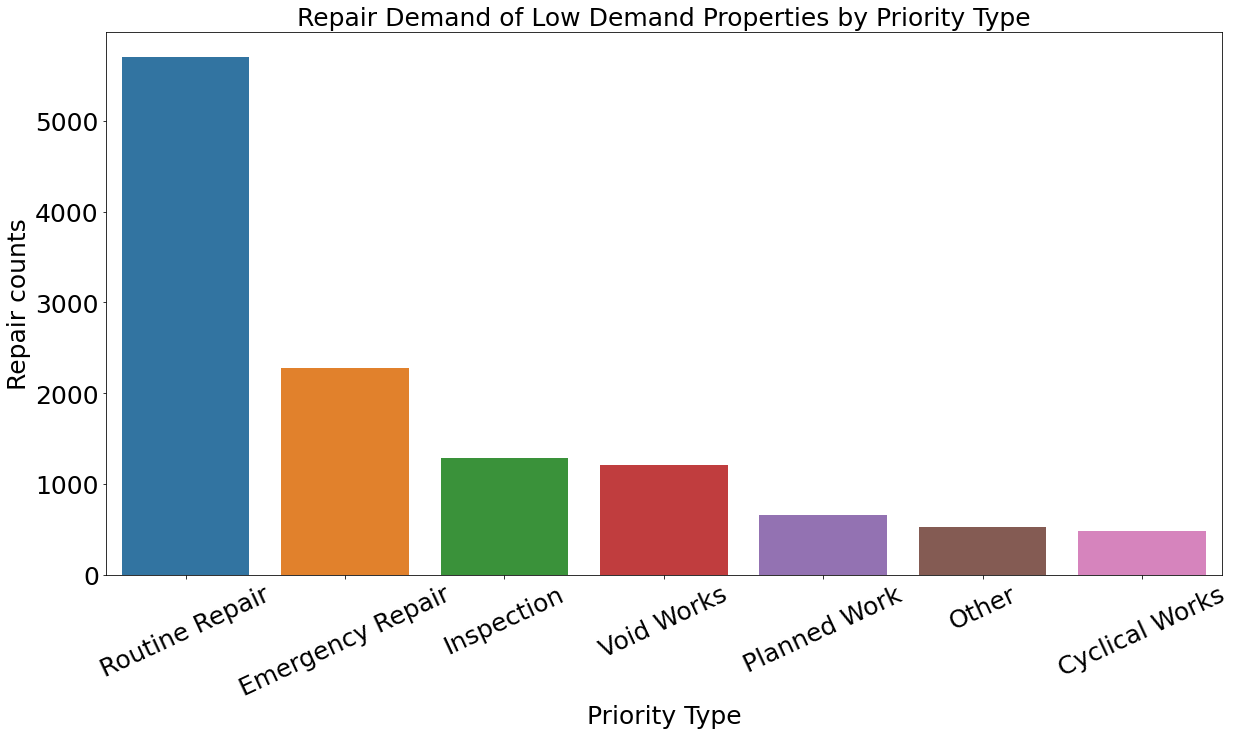

In [89]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = low_demand_properties_all_jobs, x = 'priority', order = low_demand_properties_all_jobs['priority'].value_counts().index)
plt.title('Repair Demand of Low Demand Properties by Priority Type', fontsize = 25)
ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Priority Type', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.xticks(rotation = 25)
plt.show()

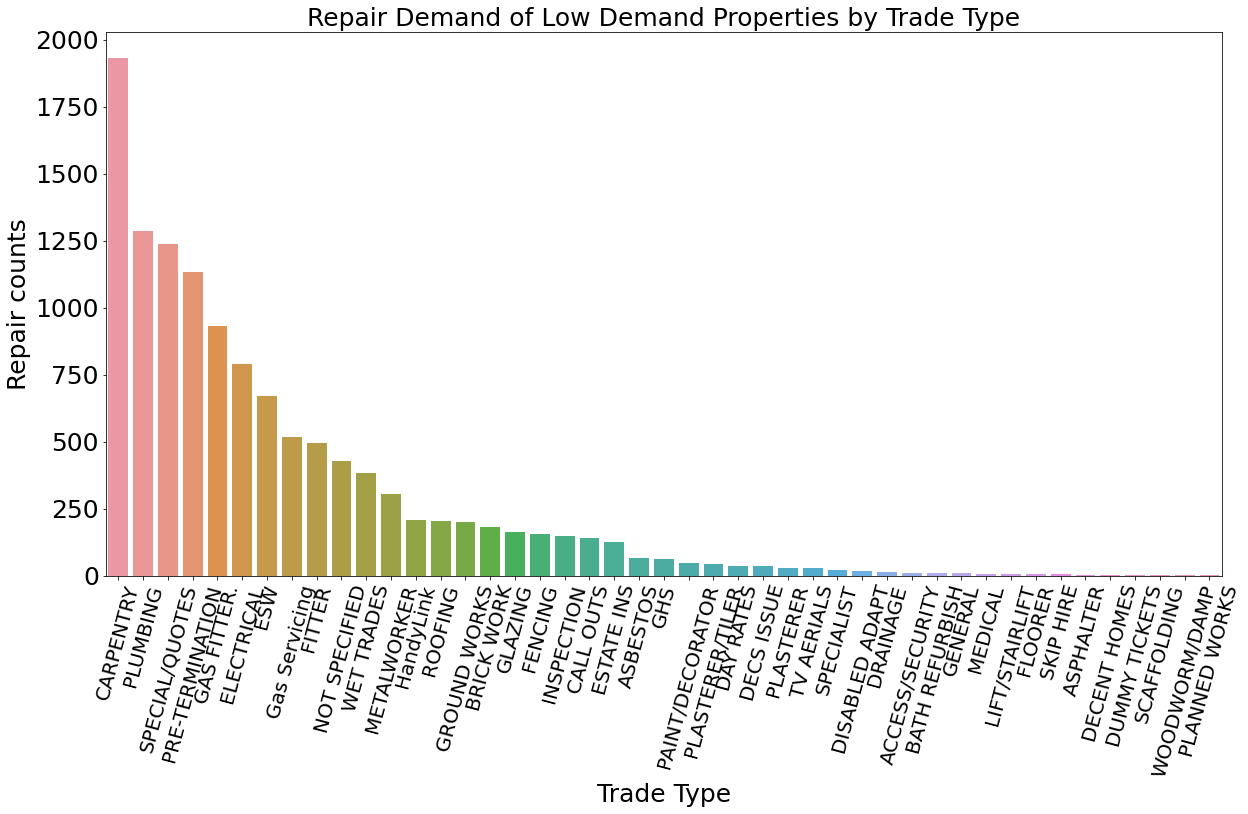

In [90]:
plt.figure(figsize = (20,10))
ax = sns.countplot(data = low_demand_properties_all_jobs, x = 'sor', order = low_demand_properties_all_jobs['sor'].value_counts().index)
plt.title('Repair Demand of Low Demand Properties by Trade Type', fontsize = 25)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Trade Type', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.xticks(rotation = 75)
plt.show()

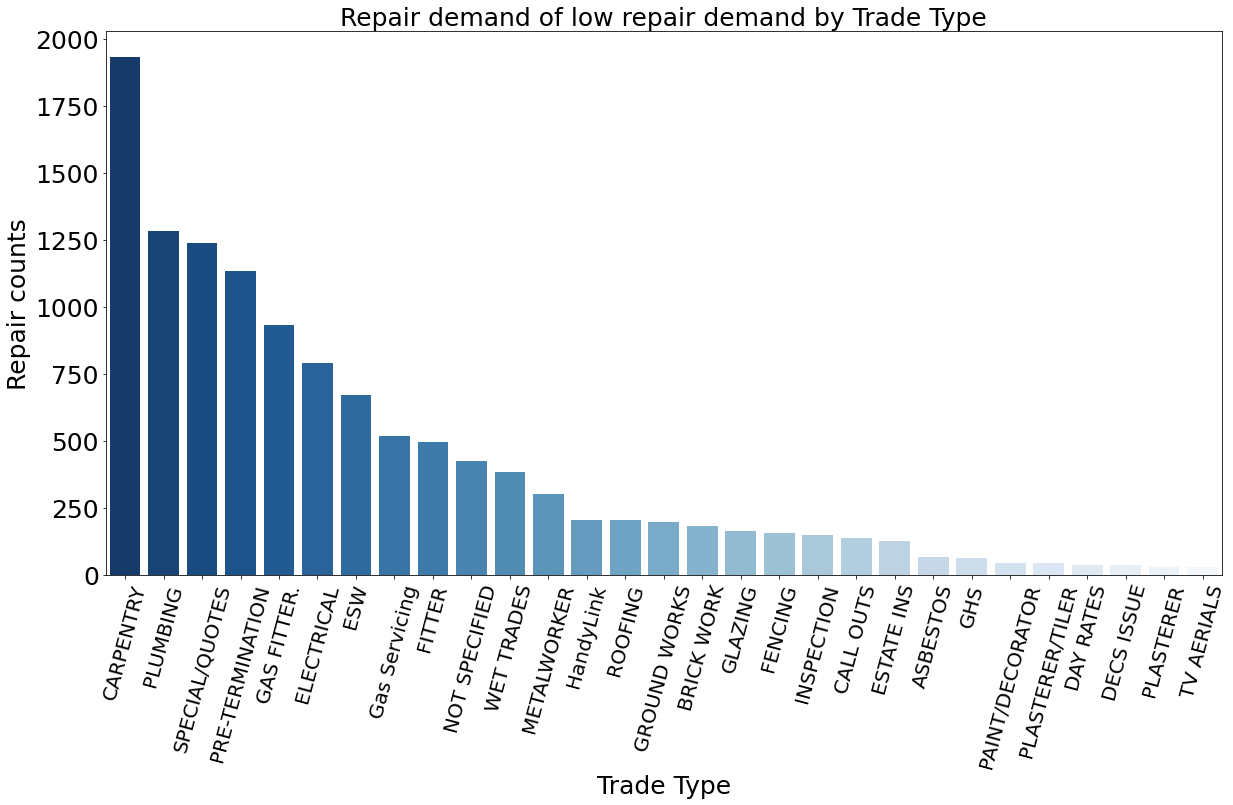

In [91]:
# filtering out trade types whose value_counts are less than 25
# plotting the rest
trade_value_counts_low = low_demand_properties_all_jobs['sor'].value_counts()
trade_value_counts_low = trade_value_counts_low[trade_value_counts_low > 25].index

filtered_low_demand_trade = low_demand_properties_all_jobs[low_demand_properties_all_jobs['sor'].isin(trade_value_counts_low)]

plt.figure(figsize=(20, 10))
ax = sns.countplot(data=filtered_low_demand_trade, x='sor', order=filtered_low_demand_trade['sor'].value_counts().index, palette = 'Blues_r')
plt.title('Repair demand of low repair demand by Trade Type', fontsize = 25)
ax.tick_params(axis='x', labelsize=20)  
ax.tick_params(axis='y', labelsize=25) 
ax.set_xlabel('Trade Type', fontsize=25)
ax.set_ylabel('Repair counts', fontsize=25)
plt.xticks(rotation = 75)
plt.show()

##### comparison between high and low demand properties by property style (number of properties)

In [92]:
high_demand_properties_style_df = pd.DataFrame(high_demand_properties['property_style'].value_counts())
high_demand_properties_style_df = high_demand_properties_style_df.reset_index()
high_demand_properties_style_df.columns = ['property_style', 'high_count']
low_demand_properties_style_df = pd.DataFrame(low_demand_properties['property_style'].value_counts())
low_demand_properties_style_df = low_demand_properties_style_df.reset_index()
low_demand_properties_style_df.columns = ['property_style', 'low_count']
low_demand_properties_style_df = low_demand_properties_style_df.drop([9,10,11], axis = 0)

In [93]:
# function to replace negative values on left side of x-axis to positive (without negative sign) for diverging plots
def neg_to_pos(x, pos):
    return str(abs(int(x)))


##### No of properties by property style (high vs low demand)

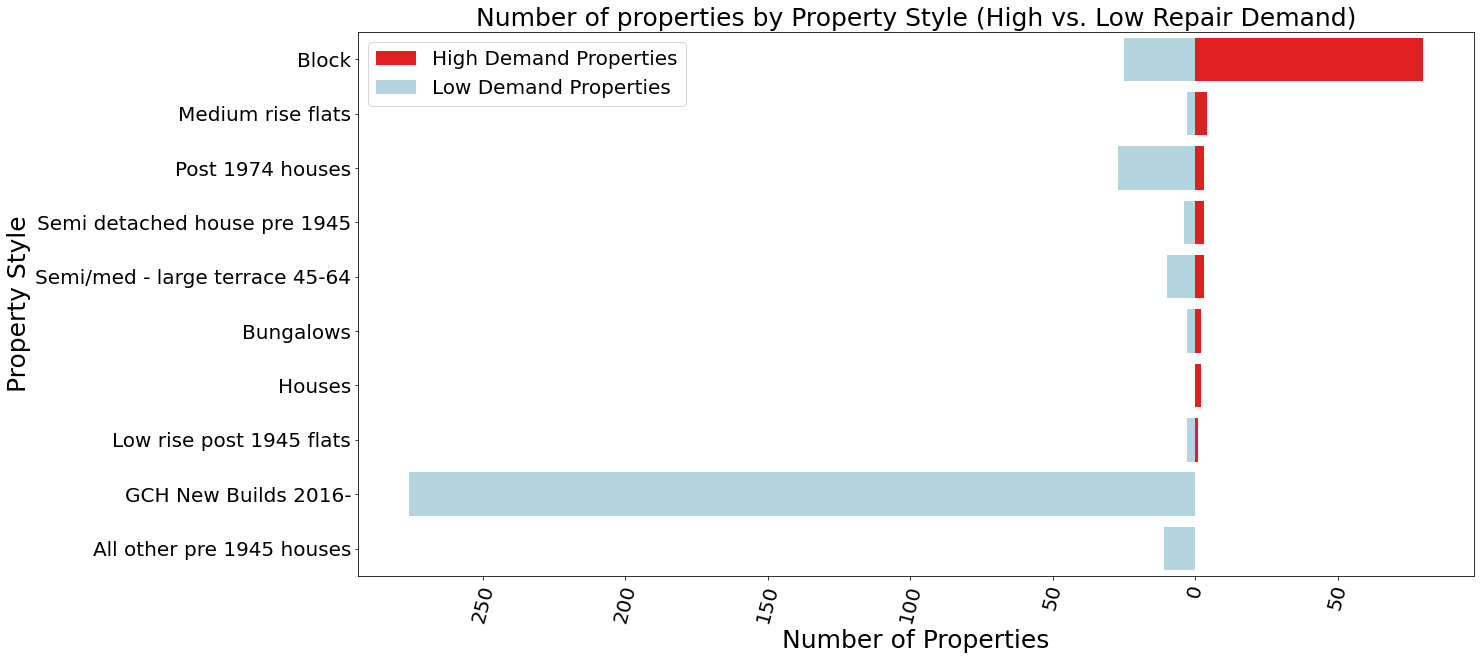

In [94]:
low_demand_properties_style_df['low_count'] = -low_demand_properties_style_df['low_count']

high_and_low_style = high_demand_properties_style_df.merge(low_demand_properties_style_df, on='property_style', how='outer')

plt.figure(figsize=(20, 10))

# high repair demand property styles 
sns.barplot(x='high_count', y='property_style', data=high_and_low_style, color='red', label='High Demand Properties', order=high_demand_properties_style_df['property_style'])


# low repair demand property styles 
sns.barplot(x='low_count', y='property_style', data=high_and_low_style, color='lightblue', label='Low Demand Properties')



plt.title('Number of properties by Property Style (High vs. Low Repair Demand)', fontsize=25)
plt.xlabel('Number of Properties', fontsize=25)
plt.ylabel('Property Style', fontsize=25)
plt.xticks(rotation=75)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)


ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(neg_to_pos))

plt.legend(fontsize=20)

plt.show()

##### Repair count comparison between high and low demand properties by property style

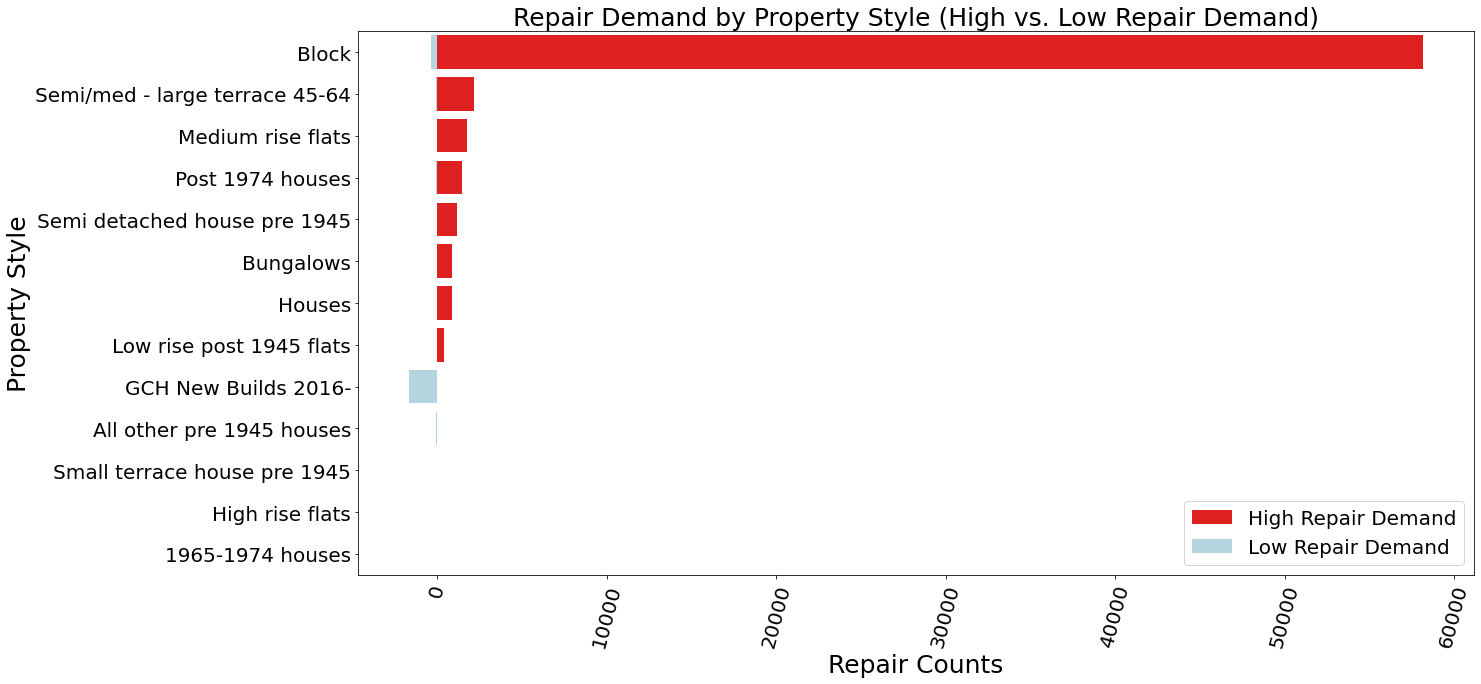

In [95]:
high_demand_properties_styles = high_demand_properties_all_jobs['property_style'].value_counts().reset_index()
high_demand_properties_styles.columns = ['property_style', 'high_demand_count']

low_demand_properties_styles = low_demand_properties_all_jobs['property_style'].value_counts().reset_index()
low_demand_properties_styles.columns = ['property_style', 'low_demand_count']


high_and_low_style = high_demand_properties_styles.merge(low_demand_properties_styles, on='property_style', how='outer').fillna(0)
high_and_low_style['low_demand_count'] = -high_and_low_style['low_demand_count']

plt.figure(figsize=(20, 10))

# high repair demand property styles 
sns.barplot(x='high_demand_count', y='property_style', data=high_and_low_style, color='red', label='High Repair Demand', order=high_demand_properties_styles['property_style'])

# low repair demand property styles 
sns.barplot(x='low_demand_count', y='property_style', data=high_and_low_style, color='lightblue', label='Low Repair Demand')


plt.title('Repair Demand by Property Style (High vs. Low Repair Demand)', fontsize=25)
plt.xlabel('Repair Counts', fontsize=25)
plt.ylabel('Property Style', fontsize=25)
plt.xticks(rotation=75)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)


plt.legend(fontsize=20)

plt.show()

##### comparison between high and low demand properties by property class (number of properties)

In [96]:
high_demand_properties_class_df = pd.DataFrame(high_demand_properties['property_class'].value_counts())
high_demand_properties_class_df = high_demand_properties_class_df.reset_index()
high_demand_properties_class_df.columns = ['property_class', 'high_count']
low_demand_properties_class_df = pd.DataFrame(low_demand_properties['property_class'].value_counts())
low_demand_properties_class_df = low_demand_properties_class_df.reset_index()
low_demand_properties_class_df.columns = ['property_class', 'low_count']

##### No of properties by property class (high vs low demand)

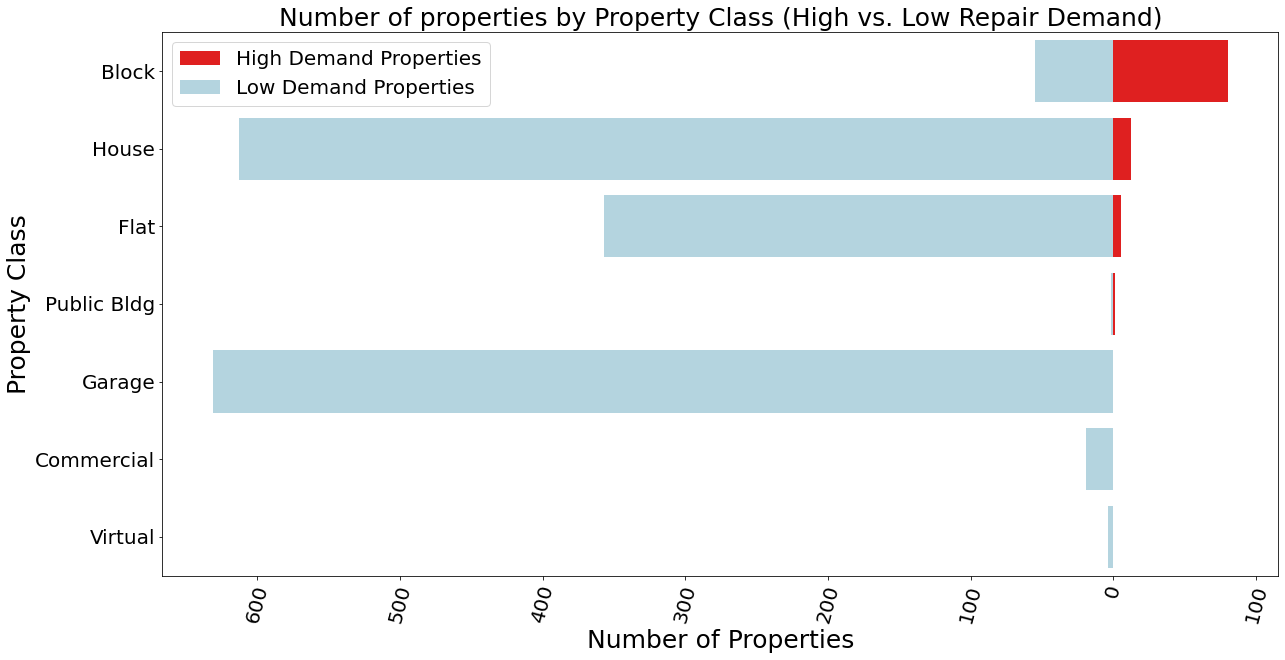

In [97]:
low_demand_properties_class_df['low_count'] = -low_demand_properties_class_df['low_count']

high_and_low_class = high_demand_properties_class_df.merge(low_demand_properties_class_df, on='property_class', how='outer')

plt.figure(figsize=(20, 10))

# high repair demand property styles 
sns.barplot(x='high_count', y='property_class', data=high_and_low_class, color='red', label='High Demand Properties', order=high_demand_properties_class_df['property_class'])

# low repair demand property styles 
sns.barplot(x='low_count', y='property_class', data=high_and_low_class, color='lightblue', label='Low Demand Properties')

plt.title('Number of properties by Property Class (High vs. Low Repair Demand)', fontsize=25)
plt.xlabel('Number of Properties', fontsize=25)
plt.ylabel('Property Class', fontsize=25)
plt.xticks(rotation=75)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

def neg_to_pos(x, pos):
    return str(abs(int(x)))


ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(neg_to_pos))

plt.legend(fontsize=20)

plt.show()

##### Repair count comparison between high and low demand properties by property class

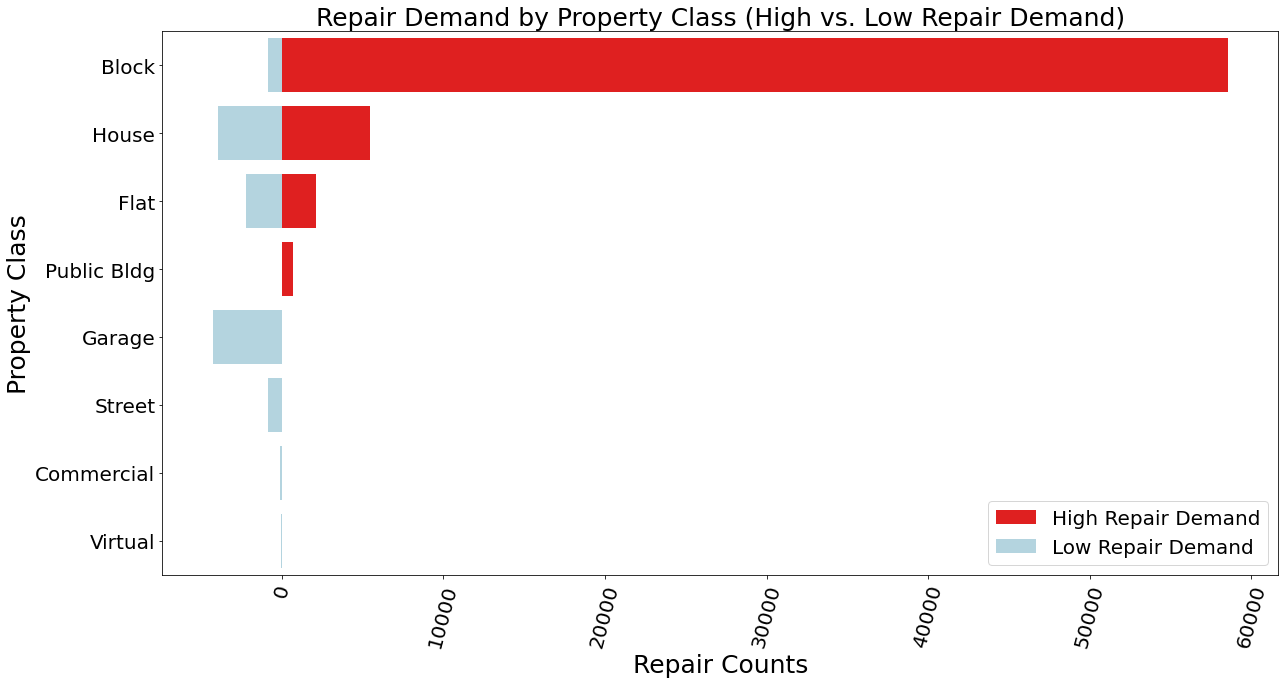

In [98]:
high_demand_properties_class = high_demand_properties_all_jobs['property_class'].value_counts().reset_index()
high_demand_properties_class.columns = ['property_class', 'high_demand_count']

low_demand_properties_class = low_demand_properties_all_jobs['property_class'].value_counts().reset_index()
low_demand_properties_class.columns = ['property_class', 'low_demand_count']

high_and_low_class = high_demand_properties_class.merge(low_demand_properties_class, on='property_class', how='outer').fillna(0)
high_and_low_class['low_demand_count'] = -high_and_low_class['low_demand_count']

plt.figure(figsize=(20, 10))

# high repair demand property styles 
sns.barplot(x='high_demand_count', y='property_class', data=high_and_low_class, color='red', label='High Repair Demand', order=high_demand_properties_class['property_class'])

# low repair demand property styles 
sns.barplot(x='low_demand_count', y='property_class', data=high_and_low_class, color='lightblue', label='Low Repair Demand')

plt.title('Repair Demand by Property Class (High vs. Low Repair Demand)', fontsize=25)
plt.xlabel('Repair Counts', fontsize=25)
plt.ylabel('Property Class', fontsize=25)
plt.xticks(rotation=75)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)


plt.legend(fontsize=20)

plt.show()